In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [2]:
def true_disc(x): #[-4,3.75]
    y  = np.zeros((np.shape(x)[0],))
    
    y = 0.2*np.sin(6*x)*np.exp(-1*x)
    y[x>0] = 1 + 0.1*x[x>0]*np.exp(x[x>0]) + 10
    
    return 50*y

In [3]:
# Domain bounds
label = "Regr_disc_swish"
loss_thresh = 0.1

lb = np.array(-4.0)  # [-1. 0.]
ub = np.array(3.75) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_disc(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_disc(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Sigmoid()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(model_NN.beta.cpu().detach().numpy())
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 3000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    beta_val = []
    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=0.08)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    beta_full.append(beta_val)
                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"beta": beta_full, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 290535.5 Test MSE 271169.8659319279 Test RE 0.9959756368706306
1 Train Loss 288215.3 Test MSE 248724.45909660502 Test RE 0.953865737489905
2 Train Loss 264321.03 Test MSE 185332.6928574938 Test RE 0.8233870264685385
3 Train Loss 196232.38 Test MSE 99540.41490129808 Test RE 0.6034311497331454
4 Train Loss 95461.766 Test MSE 436852.6154115057 Test RE 1.264140868541831
5 Train Loss 409005.44 Test MSE 91044.98622293091 Test RE 0.5771065707769378
6 Train Loss 86638.76 Test MSE 152220.19306770223 Test RE 0.7462152771697322
7 Train Loss 160542.1 Test MSE 192126.44709596975 Test RE 0.8

132 Train Loss 10768.415 Test MSE 11826.152597107382 Test RE 0.20799348949301028
133 Train Loss 9719.561 Test MSE 14597.437601896338 Test RE 0.2310821053006294
134 Train Loss 12222.442 Test MSE 10968.29942112382 Test RE 0.20030770294648428
135 Train Loss 9509.087 Test MSE 10316.915207175247 Test RE 0.19426874402781366
136 Train Loss 10124.572 Test MSE 9436.6577846151 Test RE 0.18579631869004057
137 Train Loss 9725.913 Test MSE 9613.234331143514 Test RE 0.18752655103614158
138 Train Loss 9062.404 Test MSE 10055.74572224353 Test RE 0.19179405586952092
139 Train Loss 8048.139 Test MSE 12062.823133024882 Test RE 0.21006441158981043
140 Train Loss 9260.434 Test MSE 10257.587717502332 Test RE 0.19370936683903234
141 Train Loss 8133.193 Test MSE 7602.404627407285 Test RE 0.1667644563969263
142 Train Loss 6983.506 Test MSE 15234.451367774369 Test RE 0.23607033222232948
143 Train Loss 16780.764 Test MSE 11068.546143608082 Test RE 0.20122099482532638
144 Train Loss 9067.817 Test MSE 14052.250615

288 Train Loss 837.4177 Test MSE 2247.1857217809547 Test RE 0.09066663240835839
289 Train Loss 2197.8833 Test MSE 9492.79458737326 Test RE 0.18634813194762959
290 Train Loss 7419.488 Test MSE 6982.661128102839 Test RE 0.1598227079507474
291 Train Loss 7970.1694 Test MSE 4943.364447081625 Test RE 0.13447430757507492
292 Train Loss 3518.1768 Test MSE 12043.689985933226 Test RE 0.20989775125489538
293 Train Loss 9110.608 Test MSE 2730.1369278119632 Test RE 0.09993559820799029
294 Train Loss 1983.663 Test MSE 5437.393964114754 Test RE 0.14103386318304956
295 Train Loss 5819.567 Test MSE 2194.922756603915 Test RE 0.08960610966873857
296 Train Loss 1630.468 Test MSE 6223.8110433379725 Test RE 0.1508885208744709
297 Train Loss 5116.0635 Test MSE 4962.001140473155 Test RE 0.1347275560285559
298 Train Loss 3976.1785 Test MSE 4169.365988703206 Test RE 0.12349887785871053
299 Train Loss 4401.2446 Test MSE 3633.665054452045 Test RE 0.11529233844226544
300 Train Loss 2294.5393 Test MSE 6716.0463599

405 Train Loss 14947.865 Test MSE 11563.725698088449 Test RE 0.20567281512437807
406 Train Loss 8649.936 Test MSE 11991.182009910599 Test RE 0.20943969624809297
407 Train Loss 10138.947 Test MSE 9852.518971895333 Test RE 0.18984608332797487
408 Train Loss 7186.3286 Test MSE 6120.294365911491 Test RE 0.1496284431479012
409 Train Loss 4968.647 Test MSE 11463.371755735565 Test RE 0.20477842113123057
410 Train Loss 11267.91 Test MSE 4030.610031457953 Test RE 0.12142647636464397
411 Train Loss 3966.7258 Test MSE 8450.701712798691 Test RE 0.17582247455749087
412 Train Loss 7321.39 Test MSE 4522.14461433613 Test RE 0.12861754779655568
413 Train Loss 3443.9922 Test MSE 7226.74179967939 Test RE 0.1625920366005409
414 Train Loss 5616.71 Test MSE 7799.075183003418 Test RE 0.1689077416505525
415 Train Loss 5512.472 Test MSE 2749.8775991732246 Test RE 0.10029624724102294
416 Train Loss 2470.626 Test MSE 4414.799314869133 Test RE 0.12708183730265168
417 Train Loss 4978.819 Test MSE 4132.865903855097

531 Train Loss 823.6051 Test MSE 1923.3683736599314 Test RE 0.08388015747273558
532 Train Loss 899.18604 Test MSE 1196.1945884426339 Test RE 0.06614985834294176
533 Train Loss 885.5333 Test MSE 2094.7166682680713 Test RE 0.08753679589232485
534 Train Loss 1023.6415 Test MSE 1319.1751368834157 Test RE 0.0694671098341038
535 Train Loss 1053.5267 Test MSE 2568.655200200485 Test RE 0.0969350653593968
536 Train Loss 1288.7255 Test MSE 1547.8852757081686 Test RE 0.07524842015846968
537 Train Loss 1253.4493 Test MSE 2607.649857576509 Test RE 0.09766807765942712
538 Train Loss 1322.4207 Test MSE 1358.8671236699156 Test RE 0.07050444489111495
539 Train Loss 1069.8873 Test MSE 2080.3742218155876 Test RE 0.08723660057425486
540 Train Loss 988.6083 Test MSE 1114.4951386522528 Test RE 0.0638509099813614
541 Train Loss 771.2782 Test MSE 1462.1355165334883 Test RE 0.07313441892546829
542 Train Loss 651.9732 Test MSE 929.4108942873718 Test RE 0.05830850161359302
543 Train Loss 555.3773 Test MSE 1143.5

684 Train Loss 466.64923 Test MSE 904.4210127709423 Test RE 0.0575192644623345
685 Train Loss 443.7102 Test MSE 1169.3431540189658 Test RE 0.06540319892192534
686 Train Loss 487.90253 Test MSE 803.4558935486488 Test RE 0.054213696754419775
687 Train Loss 464.5933 Test MSE 849.1456370414656 Test RE 0.0557338562457619
688 Train Loss 426.8531 Test MSE 1009.6041579814715 Test RE 0.06077200530629832
689 Train Loss 456.00085 Test MSE 789.5571907580528 Test RE 0.05374273923736426
690 Train Loss 455.20172 Test MSE 939.839369977325 Test RE 0.058634715017085656
691 Train Loss 419.18362 Test MSE 1002.0922616713948 Test RE 0.06054549804762533
692 Train Loss 430.84467 Test MSE 755.8980398597072 Test RE 0.0525847255280367
693 Train Loss 446.98074 Test MSE 891.880417252672 Test RE 0.05711909476153809
694 Train Loss 418.82504 Test MSE 857.190851097982 Test RE 0.05599725849287541
695 Train Loss 407.96237 Test MSE 764.5445007770744 Test RE 0.052884619776208154
696 Train Loss 425.48825 Test MSE 976.71395

834 Train Loss 674.38983 Test MSE 1209.39363417144 Test RE 0.06651381236858209
835 Train Loss 651.501 Test MSE 1123.898017316848 Test RE 0.06411969595970754
836 Train Loss 660.5759 Test MSE 1275.924363647281 Test RE 0.06831883736126344
837 Train Loss 632.6576 Test MSE 1246.3816429939448 Test RE 0.06752327898521303
838 Train Loss 632.4038 Test MSE 1143.995791223223 Test RE 0.06469045640218672
839 Train Loss 612.5301 Test MSE 1242.5074031037325 Test RE 0.06741825297301114
840 Train Loss 620.579 Test MSE 1134.4889505435576 Test RE 0.06442110012396353
841 Train Loss 586.80316 Test MSE 1079.718852438147 Test RE 0.06284682527244037
842 Train Loss 601.0641 Test MSE 1182.580576884905 Test RE 0.06577235204686718
843 Train Loss 580.63934 Test MSE 1143.9967107550974 Test RE 0.06469048240093826
844 Train Loss 573.5129 Test MSE 1102.9064239315956 Test RE 0.06351807605817983
845 Train Loss 570.1545 Test MSE 1198.8324245081046 Test RE 0.06622275467285729
846 Train Loss 561.61035 Test MSE 1109.4782474

988 Train Loss 516.05566 Test MSE 1565.239981681857 Test RE 0.07566908251828146
989 Train Loss 654.0553 Test MSE 1137.7199426148181 Test RE 0.06451276962730859
990 Train Loss 562.5109 Test MSE 898.4107037385324 Test RE 0.05732782440522371
991 Train Loss 512.4889 Test MSE 1380.5226085936495 Test RE 0.07106401872452496
992 Train Loss 685.0971 Test MSE 664.8472464147643 Test RE 0.04931612435507429
993 Train Loss 616.86694 Test MSE 969.6435953552899 Test RE 0.05955717211214377
994 Train Loss 421.79877 Test MSE 1218.3112546015511 Test RE 0.06675858608010134
995 Train Loss 477.88052 Test MSE 924.7278567609482 Test RE 0.058161416109620515
996 Train Loss 513.2495 Test MSE 955.1643290215304 Test RE 0.059110828900883705
997 Train Loss 424.0 Test MSE 769.8065540831852 Test RE 0.05306629952372778
998 Train Loss 437.74997 Test MSE 660.9750980530722 Test RE 0.04917230319449384
999 Train Loss 457.5599 Test MSE 1166.5565238837366 Test RE 0.06532522213835151
1000 Train Loss 462.80386 Test MSE 960.79053

1143 Train Loss 369.87112 Test MSE 635.6664978049116 Test RE 0.04822171626113377
1144 Train Loss 412.24542 Test MSE 977.1132990356848 Test RE 0.05978613300839691
1145 Train Loss 397.2814 Test MSE 667.341240137107 Test RE 0.04940853578966563
1146 Train Loss 327.5688 Test MSE 649.0708649392461 Test RE 0.048727492067195385
1147 Train Loss 326.17166 Test MSE 880.0362237150825 Test RE 0.05673855566611063
1148 Train Loss 363.19873 Test MSE 597.1022058968841 Test RE 0.04673608609190537
1149 Train Loss 376.43198 Test MSE 862.9723942523913 Test RE 0.05618578505887764
1150 Train Loss 345.01663 Test MSE 634.7244312492974 Test RE 0.048185970386496434
1151 Train Loss 306.0816 Test MSE 616.2784077215309 Test RE 0.04748063054105412
1152 Train Loss 302.59552 Test MSE 769.386284970597 Test RE 0.05305181200654929
1153 Train Loss 321.07678 Test MSE 557.980254531828 Test RE 0.04517908355788181
1154 Train Loss 345.445 Test MSE 886.102297595253 Test RE 0.05693376876617096
1155 Train Loss 346.0289 Test MSE 5

1302 Train Loss 257.6026 Test MSE 460.78533985987804 Test RE 0.041056065587809054
1303 Train Loss 253.46501 Test MSE 705.2794104539918 Test RE 0.05079355438632401
1304 Train Loss 275.36414 Test MSE 445.94665838213496 Test RE 0.04038959132083222
1305 Train Loss 311.70798 Test MSE 1049.7984246659103 Test RE 0.06196992352395151
1306 Train Loss 399.8643 Test MSE 548.3133462377934 Test RE 0.04478601387563307
1307 Train Loss 297.13876 Test MSE 667.4162165419366 Test RE 0.04941131125903136
1308 Train Loss 229.2085 Test MSE 465.9499711996725 Test RE 0.041285509300120565
1309 Train Loss 218.47017 Test MSE 517.8859567916567 Test RE 0.043525630325955196
1310 Train Loss 205.38217 Test MSE 517.1307437772612 Test RE 0.04349388287802074
1311 Train Loss 201.28397 Test MSE 597.69093016377 Test RE 0.04675912058159483
1312 Train Loss 206.57938 Test MSE 452.61777301063665 Test RE 0.0406905728106815
1313 Train Loss 208.24796 Test MSE 727.6155990164933 Test RE 0.05159160066832155
1314 Train Loss 274.2995 Te

1455 Train Loss 1074.6813 Test MSE 2250.8424547181926 Test RE 0.09074037106096428
1456 Train Loss 1406.8373 Test MSE 880.6996844256316 Test RE 0.056759939280322226
1457 Train Loss 1271.4496 Test MSE 1314.4782579040477 Test RE 0.06934333189779902
1458 Train Loss 665.9379 Test MSE 1232.8599700814314 Test RE 0.06715600884681402
1459 Train Loss 585.36816 Test MSE 1523.9346493066246 Test RE 0.07466398638643021
1460 Train Loss 849.3995 Test MSE 1166.4046696448954 Test RE 0.06532097020776383
1461 Train Loss 472.73288 Test MSE 820.1387141052102 Test RE 0.054773646967441345
1462 Train Loss 586.2092 Test MSE 652.8563578370545 Test RE 0.048869379047068486
1463 Train Loss 628.0773 Test MSE 1521.1967230120686 Test RE 0.07459688495515833
1464 Train Loss 704.7734 Test MSE 1273.0298383281668 Test RE 0.06824130028681778
1465 Train Loss 729.63635 Test MSE 964.4578165287261 Test RE 0.059397698892109184
1466 Train Loss 530.8701 Test MSE 1269.5383319932207 Test RE 0.06814765419923957
1467 Train Loss 617.53

1609 Train Loss 481.65677 Test MSE 904.3590612900374 Test RE 0.057517294436988047
1610 Train Loss 493.769 Test MSE 652.0629935718111 Test RE 0.048839676491069725
1611 Train Loss 440.06262 Test MSE 903.2013366397964 Test RE 0.05748046696585483
1612 Train Loss 417.85855 Test MSE 1117.01468696808 Test RE 0.06392304337461154
1613 Train Loss 455.77505 Test MSE 493.0294219445403 Test RE 0.042468255380596294
1614 Train Loss 338.5157 Test MSE 505.1709521402223 Test RE 0.04298799472735668
1615 Train Loss 330.4967 Test MSE 863.7732066730829 Test RE 0.056211848372923486
1616 Train Loss 362.30835 Test MSE 633.7010248136341 Test RE 0.048147108067851344
1617 Train Loss 376.3483 Test MSE 715.9984264910422 Test RE 0.05117808553087456
1618 Train Loss 285.08252 Test MSE 859.3082675618639 Test RE 0.05606637751413583
1619 Train Loss 325.7561 Test MSE 446.71239163645384 Test RE 0.04042425285217229
1620 Train Loss 386.20627 Test MSE 942.4334696368755 Test RE 0.0587155796232996
1621 Train Loss 378.1383 Test 

1764 Train Loss 173.97232 Test MSE 504.90671475612163 Test RE 0.04297675049310867
1765 Train Loss 159.92096 Test MSE 406.71596619498706 Test RE 0.03857212918427718
1766 Train Loss 172.43213 Test MSE 548.9518449484322 Test RE 0.04481208244788003
1767 Train Loss 163.70213 Test MSE 439.37485156436014 Test RE 0.04009088096723011
1768 Train Loss 156.50188 Test MSE 535.4255131410735 Test RE 0.04425654765019446
1769 Train Loss 141.32117 Test MSE 432.85149270121155 Test RE 0.03979215518204269
1770 Train Loss 138.2095 Test MSE 410.82644133283026 Test RE 0.0387665538035816
1771 Train Loss 130.86954 Test MSE 583.7152479330063 Test RE 0.04620920756462104
1772 Train Loss 139.83847 Test MSE 415.7253294135069 Test RE 0.03899700416758525
1773 Train Loss 130.91737 Test MSE 481.8795690223679 Test RE 0.04198529978089646
1774 Train Loss 123.65066 Test MSE 367.5935303797175 Test RE 0.03667008624996077
1775 Train Loss 114.10008 Test MSE 413.491069067252 Test RE 0.038892070890831215
1776 Train Loss 113.30024

1921 Train Loss 779.3034 Test MSE 2442.807251283426 Test RE 0.09453064084330069
1922 Train Loss 1523.8911 Test MSE 1924.8725674468074 Test RE 0.0839129508144818
1923 Train Loss 785.6482 Test MSE 1597.013732646918 Test RE 0.07643325011215044
1924 Train Loss 893.91876 Test MSE 887.3796277698518 Test RE 0.05697478944287864
1925 Train Loss 1221.4913 Test MSE 2925.8931175059975 Test RE 0.10345636865894885
1926 Train Loss 1471.0872 Test MSE 2299.51181264437 Test RE 0.09171615176663736
1927 Train Loss 853.65 Test MSE 2878.823866807654 Test RE 0.10262083618615486
1928 Train Loss 1692.1099 Test MSE 2243.7001589071047 Test RE 0.09059628956029302
1929 Train Loss 833.61273 Test MSE 2231.983383559497 Test RE 0.09035942952306493
1930 Train Loss 1089.0366 Test MSE 830.6830757297689 Test RE 0.055124629428085034
1931 Train Loss 718.18805 Test MSE 491.84120436838526 Test RE 0.04241704954437911
1932 Train Loss 572.2159 Test MSE 1803.3467453846426 Test RE 0.08122086717290557
1933 Train Loss 1260.9672 Test

2072 Train Loss 1685.5033 Test MSE 2915.492114885974 Test RE 0.10327232093218651
2073 Train Loss 3425.9114 Test MSE 5513.967890756513 Test RE 0.14202346961989934
2074 Train Loss 3524.5542 Test MSE 3141.2798377433105 Test RE 0.10719667512531313
2075 Train Loss 1217.6647 Test MSE 5899.428584064664 Test RE 0.14690378171412113
2076 Train Loss 4200.9565 Test MSE 4260.422154792078 Test RE 0.12484016069960312
2077 Train Loss 2267.0352 Test MSE 3025.333500473406 Test RE 0.10519973118494523
2078 Train Loss 1674.5706 Test MSE 1427.0352072486764 Test RE 0.07225124679182685
2079 Train Loss 1522.5565 Test MSE 1324.8305453386097 Test RE 0.06961585608801807
2080 Train Loss 1513.9736 Test MSE 4195.109277425298 Test RE 0.12387955622347203
2081 Train Loss 3292.5918 Test MSE 2239.36285045264 Test RE 0.09050868112130185
2082 Train Loss 1528.1235 Test MSE 3475.1518448772654 Test RE 0.11274957009725135
2083 Train Loss 2063.7227 Test MSE 5545.579056362654 Test RE 0.14242999277656332
2084 Train Loss 3160.268 

2228 Train Loss 272.84277 Test MSE 575.3160451779434 Test RE 0.04587554587920048
2229 Train Loss 193.72948 Test MSE 533.9699099669194 Test RE 0.04419634897440849
2230 Train Loss 215.94759 Test MSE 452.48108888922286 Test RE 0.04068442836001887
2231 Train Loss 224.7763 Test MSE 469.0961045542332 Test RE 0.041424656425801794
2232 Train Loss 183.0424 Test MSE 679.4858611933478 Test RE 0.04985608981031889
2233 Train Loss 180.90073 Test MSE 561.3072824138569 Test RE 0.045313576374878074
2234 Train Loss 177.96712 Test MSE 514.6118880632193 Test RE 0.04338782793124745
2235 Train Loss 150.01407 Test MSE 516.8381295108317 Test RE 0.043481575805145035
2236 Train Loss 160.98347 Test MSE 383.5250532628144 Test RE 0.03745629969940163
2237 Train Loss 148.61305 Test MSE 463.10201227723815 Test RE 0.04115914417618104
2238 Train Loss 129.25114 Test MSE 585.9408587243249 Test RE 0.04629721782840946
2239 Train Loss 141.9088 Test MSE 486.0843394324343 Test RE 0.04216807896461722
2240 Train Loss 130.8486 T

2384 Train Loss 39.411674 Test MSE 285.29703430208497 Test RE 0.03230551214652426
2385 Train Loss 29.239233 Test MSE 398.7028017588489 Test RE 0.0381902626849615
2386 Train Loss 23.80827 Test MSE 339.66577611956177 Test RE 0.03524957597638548
2387 Train Loss 19.935024 Test MSE 288.74888924932947 Test RE 0.03250035935402388
2388 Train Loss 22.563242 Test MSE 349.9393435483538 Test RE 0.03577868612394714
2389 Train Loss 22.971 Test MSE 308.6653049995969 Test RE 0.03360252476779837
2390 Train Loss 19.592096 Test MSE 307.379940857115 Test RE 0.033532486867856134
2391 Train Loss 19.97855 Test MSE 351.3309612588039 Test RE 0.03584975679897306
2392 Train Loss 20.749107 Test MSE 309.0718372669438 Test RE 0.0336246458409734
2393 Train Loss 20.092327 Test MSE 328.8809144442986 Test RE 0.03468545033494818
2394 Train Loss 18.317507 Test MSE 338.2957339968366 Test RE 0.035178414552975906
2395 Train Loss 18.316914 Test MSE 298.8553517067533 Test RE 0.03306423815968425
2396 Train Loss 20.45954 Test M

2543 Train Loss 16.18299 Test MSE 342.3885195308888 Test RE 0.03539057337843955
2544 Train Loss 11.491185 Test MSE 391.08348043435365 Test RE 0.03782358916070868
2545 Train Loss 13.398804 Test MSE 319.5806057003934 Test RE 0.034191504380756806
2546 Train Loss 16.78195 Test MSE 392.54155847992973 Test RE 0.03789403247980389
2547 Train Loss 15.667927 Test MSE 323.8389854448687 Test RE 0.03441854973984571
2548 Train Loss 11.531805 Test MSE 339.5010383388136 Test RE 0.03524102692377501
2549 Train Loss 10.976935 Test MSE 382.2292829185938 Test RE 0.03739297159867809
2550 Train Loss 13.030848 Test MSE 308.4247409608577 Test RE 0.03358942783955433
2551 Train Loss 14.725719 Test MSE 368.3963304183851 Test RE 0.03671010693678548
2552 Train Loss 12.239514 Test MSE 341.1531494735921 Test RE 0.035326669420868755
2553 Train Loss 10.226556 Test MSE 331.8498592985359 Test RE 0.034841658583775845
2554 Train Loss 10.384608 Test MSE 361.5810176028236 Test RE 0.036368954216502644
2555 Train Loss 11.98066

2696 Train Loss 13112.426 Test MSE 12391.769802496445 Test RE 0.21290931877260552
2697 Train Loss 12590.081 Test MSE 12041.86574781974 Test RE 0.20988185421757705
2698 Train Loss 12907.021 Test MSE 12089.828589167419 Test RE 0.2102994193371716
2699 Train Loss 12553.593 Test MSE 44389.75437605056 Test RE 0.40296689857118706
2700 Train Loss 44938.664 Test MSE 54668.59140939672 Test RE 0.4471950048296073
2701 Train Loss 57614.773 Test MSE 56155.30573666477 Test RE 0.45323495828624694
2702 Train Loss 58720.207 Test MSE 33906.09544488698 Test RE 0.3521817863220131
2703 Train Loss 36811.094 Test MSE 23584.738542757626 Test RE 0.2937267736016116
2704 Train Loss 20707.133 Test MSE 51824.65863843891 Test RE 0.4354078221267673
2705 Train Loss 47689.14 Test MSE 15657.740912346746 Test RE 0.2393274718299004
2706 Train Loss 14975.29 Test MSE 33814.067938402426 Test RE 0.3517035178413783
2707 Train Loss 36659.668 Test MSE 30496.21894978898 Test RE 0.3340034865887236
2708 Train Loss 33167.633 Test MS

2851 Train Loss 12329.221 Test MSE 12040.058111957187 Test RE 0.20986610067018663
2852 Train Loss 12317.37 Test MSE 11881.677730997817 Test RE 0.20848119427175535
2853 Train Loss 12305.641 Test MSE 11695.41791462706 Test RE 0.20684064072550418
2854 Train Loss 12299.692 Test MSE 11854.113913839312 Test RE 0.20823923037108838
2855 Train Loss 12293.004 Test MSE 11689.120978434281 Test RE 0.2067849506386556
2856 Train Loss 12236.577 Test MSE 11767.504074227187 Test RE 0.20747710547768522
2857 Train Loss 12254.96 Test MSE 11884.525098823626 Test RE 0.20850617336553698
2858 Train Loss 12239.489 Test MSE 11663.506336971624 Test RE 0.20655826005723787
2859 Train Loss 12220.21 Test MSE 11654.412329355499 Test RE 0.206477717867226
2860 Train Loss 12208.575 Test MSE 11746.322971312835 Test RE 0.20729029554726075
2861 Train Loss 12191.202 Test MSE 11621.226924533754 Test RE 0.2061835403857956
2862 Train Loss 12193.602 Test MSE 11676.907553604171 Test RE 0.20667689236342024
2863 Train Loss 12174.03

6 Train Loss 99473.52 Test MSE 129798.26905167245 Test RE 0.6890685875768512
7 Train Loss 133349.02 Test MSE 190898.95858158087 Test RE 0.8356603210474943
8 Train Loss 202187.77 Test MSE 218249.69150987713 Test RE 0.8935211174967757
9 Train Loss 232398.03 Test MSE 228232.0435836412 Test RE 0.9137266909246434
10 Train Loss 243351.69 Test MSE 231093.07267093126 Test RE 0.9194359176039434
11 Train Loss 246462.75 Test MSE 229255.46167278118 Test RE 0.9157730259887971
12 Train Loss 244387.1 Test MSE 224401.8967001887 Test RE 0.9060272575998632
13 Train Loss 238997.73 Test MSE 215537.9800274743 Test RE 0.8879528511199903
14 Train Loss 229168.78 Test MSE 201609.3728386857 Test RE 0.8587828464634513
15 Train Loss 213679.95 Test MSE 179529.29908356443 Test RE 0.8103929784751107
16 Train Loss 189002.4 Test MSE 150461.79668819136 Test RE 0.7418927440765792
17 Train Loss 155997.39 Test MSE 111555.63281775721 Test RE 0.6388130122888906
18 Train Loss 109875.48 Test MSE 122130.0937702487 Test RE 0.66

160 Train Loss 2886.4387 Test MSE 3463.690188909409 Test RE 0.11256348267481711
161 Train Loss 2814.771 Test MSE 3778.2213641836242 Test RE 0.117563281954711
162 Train Loss 2915.4812 Test MSE 3539.472334399192 Test RE 0.11378820928778981
163 Train Loss 2972.6746 Test MSE 4025.603505243856 Test RE 0.12135103942961031
164 Train Loss 3208.9863 Test MSE 4640.1845542057545 Test RE 0.13028536346417954
165 Train Loss 4170.829 Test MSE 5520.779746586932 Test RE 0.14211116915067848
166 Train Loss 4093.4785 Test MSE 4967.376539920025 Test RE 0.13480051231958953
167 Train Loss 4429.9653 Test MSE 3970.679103270176 Test RE 0.1205203535372763
168 Train Loss 3227.919 Test MSE 3817.6040914888817 Test RE 0.11817441077253002
169 Train Loss 3172.6006 Test MSE 3945.0032730519715 Test RE 0.12013005772571633
170 Train Loss 3484.0056 Test MSE 5411.718306810696 Test RE 0.14070048453828032
171 Train Loss 4165.2197 Test MSE 4566.264042797325 Test RE 0.1292434410031496
172 Train Loss 4108.3135 Test MSE 4629.9251

312 Train Loss 3102.9275 Test MSE 5337.1258553634825 Test RE 0.13972744695426612
313 Train Loss 3758.0393 Test MSE 2298.617223151605 Test RE 0.091698309656261
314 Train Loss 2031.2167 Test MSE 1688.1301568828085 Test RE 0.07858342728842099
315 Train Loss 1160.598 Test MSE 1386.738329953006 Test RE 0.07122381982250763
316 Train Loss 993.319 Test MSE 1820.695563727902 Test RE 0.08161061842413314
317 Train Loss 1562.4796 Test MSE 4064.126069310002 Test RE 0.1219302845967996
318 Train Loss 2907.2935 Test MSE 2797.725043056579 Test RE 0.10116505384021322
319 Train Loss 2566.9968 Test MSE 3921.0395290852307 Test RE 0.11976463965018473
320 Train Loss 2770.5447 Test MSE 2638.465831416213 Test RE 0.09824348028883569
321 Train Loss 2401.7922 Test MSE 4511.27555177108 Test RE 0.12846288741906126
322 Train Loss 3112.713 Test MSE 2103.944535669982 Test RE 0.08772939718405524
323 Train Loss 1917.9092 Test MSE 1824.8262936648036 Test RE 0.08170314362202179
324 Train Loss 1222.8524 Test MSE 1216.95606

463 Train Loss 16785.316 Test MSE 17935.383911822908 Test RE 0.2561435005669149
464 Train Loss 16091.011 Test MSE 18252.115140096954 Test RE 0.25839529511313364
465 Train Loss 16146.897 Test MSE 17731.377583828642 Test RE 0.2546825800775397
466 Train Loss 15746.057 Test MSE 17198.830970168077 Test RE 0.2508288378509552
467 Train Loss 15479.929 Test MSE 17150.617792462876 Test RE 0.2504770191007169
468 Train Loss 15464.381 Test MSE 16870.186531152147 Test RE 0.24842079318032956
469 Train Loss 14960.197 Test MSE 16996.27767818294 Test RE 0.24934743825880923
470 Train Loss 14916.419 Test MSE 16348.568968201447 Test RE 0.24455011630964166
471 Train Loss 14387.287 Test MSE 16192.319411749406 Test RE 0.2433786809036071
472 Train Loss 14347.964 Test MSE 15766.596814277424 Test RE 0.2401579583145642
473 Train Loss 13783.796 Test MSE 15974.544580602076 Test RE 0.24173650824685158
474 Train Loss 13901.347 Test MSE 15458.627486102469 Test RE 0.237800885672013
475 Train Loss 13446.016 Test MSE 154

617 Train Loss 11201.612 Test MSE 10513.12397444629 Test RE 0.19610736066942047
618 Train Loss 8875.004 Test MSE 12447.070262930021 Test RE 0.21338386263943818
619 Train Loss 10123.872 Test MSE 10603.565166243592 Test RE 0.19694908012017634
620 Train Loss 9356.295 Test MSE 10378.98873951792 Test RE 0.19485229359633163
621 Train Loss 9104.913 Test MSE 11700.326679658312 Test RE 0.20688404343227257
622 Train Loss 9640.014 Test MSE 10284.559354237696 Test RE 0.19396387252078967
623 Train Loss 8809.033 Test MSE 10560.510722691968 Test RE 0.196548829923267
624 Train Loss 9352.078 Test MSE 11052.481186076171 Test RE 0.20107491509168873
625 Train Loss 9206.681 Test MSE 10201.539056900323 Test RE 0.19317941658654944
626 Train Loss 8638.235 Test MSE 10614.218903619449 Test RE 0.1970479957662235
627 Train Loss 9390.115 Test MSE 10448.214407138981 Test RE 0.19550102553525867
628 Train Loss 8763.182 Test MSE 10068.552869234756 Test RE 0.19191615288375408
629 Train Loss 8579.321 Test MSE 10061.0010

773 Train Loss 8121.922 Test MSE 9918.240181960196 Test RE 0.19047821490047975
774 Train Loss 7461.3594 Test MSE 6155.126174645431 Test RE 0.1500536216311322
775 Train Loss 5003.8926 Test MSE 4975.284623254057 Test RE 0.13490777112503788
776 Train Loss 4323.6377 Test MSE 10019.926676082012 Test RE 0.19145216134668006
777 Train Loss 8315.634 Test MSE 16370.744735786337 Test RE 0.2447159182456729
778 Train Loss 15476.627 Test MSE 8814.07539131003 Test RE 0.17956280552967344
779 Train Loss 6941.377 Test MSE 11016.462483725356 Test RE 0.2007470082804089
780 Train Loss 8720.95 Test MSE 15148.802864842643 Test RE 0.23540579996382965
781 Train Loss 14236.872 Test MSE 8302.116699512979 Test RE 0.17426991474139128
782 Train Loss 6782.762 Test MSE 4438.035630900909 Test RE 0.12741583192091163
783 Train Loss 3627.556 Test MSE 7653.059975845589 Test RE 0.16731911555781967
784 Train Loss 6565.7285 Test MSE 8546.603198870276 Test RE 0.1768173072220277
785 Train Loss 6721.3745 Test MSE 4841.022715652

923 Train Loss 10107.103 Test MSE 3319.989282451261 Test RE 0.11020374233764131
924 Train Loss 2953.7356 Test MSE 13066.304273833415 Test RE 0.21862729704731043
925 Train Loss 13465.492 Test MSE 15881.684677369076 Test RE 0.2410328779873292
926 Train Loss 15210.712 Test MSE 10081.084305785384 Test RE 0.19203554626984595
927 Train Loss 8573.576 Test MSE 14796.49660371504 Test RE 0.23265235405230844
928 Train Loss 11738.269 Test MSE 7141.346435469184 Test RE 0.1616285410273685
929 Train Loss 5670.684 Test MSE 10697.757972744172 Test RE 0.19782190780341397
930 Train Loss 10096.69 Test MSE 7947.625876550559 Test RE 0.1705087652288804
931 Train Loss 7915.9277 Test MSE 6784.014492988636 Test RE 0.1575329425895943
932 Train Loss 6159.1987 Test MSE 4814.613885791829 Test RE 0.13271155376594437
933 Train Loss 4141.756 Test MSE 6604.4209711743915 Test RE 0.15543376817143317
934 Train Loss 4522.6357 Test MSE 8379.805997556674 Test RE 0.17508340494369665
935 Train Loss 6654.051 Test MSE 4043.52295

1072 Train Loss 1506.3511 Test MSE 3946.8750792136816 Test RE 0.12015855371169878
1073 Train Loss 3045.1973 Test MSE 3863.869609519563 Test RE 0.11888833172604114
1074 Train Loss 3453.4485 Test MSE 2972.084854929896 Test RE 0.1042698152782378
1075 Train Loss 2062.583 Test MSE 2804.2234353119343 Test RE 0.10128247583245405
1076 Train Loss 2049.6362 Test MSE 3535.62966872551 Test RE 0.11372642482596464
1077 Train Loss 3095.307 Test MSE 3964.072640602955 Test RE 0.1204200502064602
1078 Train Loss 2850.513 Test MSE 2564.70613666754 Test RE 0.09686052246715335
1079 Train Loss 2053.1733 Test MSE 2447.8170340366755 Test RE 0.09462752433985251
1080 Train Loss 2121.2156 Test MSE 2973.2029619422688 Test RE 0.10428942673862786
1081 Train Loss 2128.807 Test MSE 2349.6797206922033 Test RE 0.09271122856003337
1082 Train Loss 1888.4602 Test MSE 2218.461917309532 Test RE 0.0900853127820801
1083 Train Loss 1652.8457 Test MSE 2279.039026135769 Test RE 0.09130695986814906
1084 Train Loss 1671.688 Test MS

1220 Train Loss 717.739 Test MSE 963.871543526478 Test RE 0.05937964286086258
1221 Train Loss 712.2146 Test MSE 949.0913816869792 Test RE 0.05892261554528687
1222 Train Loss 710.6111 Test MSE 968.3266870463171 Test RE 0.05951671498779319
1223 Train Loss 713.08057 Test MSE 950.6067626785413 Test RE 0.05896963662253993
1224 Train Loss 714.8199 Test MSE 977.6005781148663 Test RE 0.05980103859853186
1225 Train Loss 715.35846 Test MSE 949.3634664027924 Test RE 0.05893106088288745
1226 Train Loss 714.1806 Test MSE 980.1116673792831 Test RE 0.05987779256286114
1227 Train Loss 717.75586 Test MSE 959.4516253166719 Test RE 0.05924334112339759
1228 Train Loss 724.1274 Test MSE 1016.3603178093357 Test RE 0.0609750060409858
1229 Train Loss 741.43463 Test MSE 996.0469284242706 Test RE 0.06036259502685765
1230 Train Loss 758.90015 Test MSE 1119.1830316337566 Test RE 0.06398505687855328
1231 Train Loss 800.97107 Test MSE 1083.3761901215096 Test RE 0.06295317598864841
1232 Train Loss 839.68744 Test MSE

1356 Train Loss 3903.9846 Test MSE 4396.646548138604 Test RE 0.12682030070323164
1357 Train Loss 3967.2742 Test MSE 3668.9215756861254 Test RE 0.11585031424893076
1358 Train Loss 2155.3787 Test MSE 1604.7860618811012 Test RE 0.07661901662409752
1359 Train Loss 1252.2749 Test MSE 6463.270928348504 Test RE 0.15376382801167923
1360 Train Loss 6110.04 Test MSE 15092.457854494918 Test RE 0.23496760366074443
1361 Train Loss 12420.639 Test MSE 8781.535404368648 Test RE 0.1792310421928567
1362 Train Loss 7714.219 Test MSE 5495.786860059805 Test RE 0.1417891315602075
1363 Train Loss 4400.2573 Test MSE 7306.167750471474 Test RE 0.1634830839087963
1364 Train Loss 5483.3726 Test MSE 5573.726417032391 Test RE 0.1427909969304759
1365 Train Loss 5096.7837 Test MSE 5191.939341130698 Test RE 0.13781383137592043
1366 Train Loss 4297.0703 Test MSE 3686.0961983724665 Test RE 0.11612115165232763
1367 Train Loss 2921.6943 Test MSE 3122.7205050506636 Test RE 0.10687953590722146
1368 Train Loss 2567.9875 Test

1475 Train Loss 801.01044 Test MSE 1456.9200943499798 Test RE 0.07300386754670317
1476 Train Loss 1053.9661 Test MSE 1262.1692482907265 Test RE 0.06794958352383562
1477 Train Loss 985.26056 Test MSE 1340.3620684310176 Test RE 0.07002273444943165
1478 Train Loss 894.5703 Test MSE 914.9257787968103 Test RE 0.057852340548630525
1479 Train Loss 689.0395 Test MSE 991.6379132977212 Test RE 0.06022884893607428
1480 Train Loss 760.8714 Test MSE 1503.203452440473 Test RE 0.0741543929698745
1481 Train Loss 1104.1096 Test MSE 1526.2207565629408 Test RE 0.07471996841776525
1482 Train Loss 1199.9713 Test MSE 2170.7691700700198 Test RE 0.0891117195857975
1483 Train Loss 1364.4015 Test MSE 1063.038789623901 Test RE 0.06235949044530508
1484 Train Loss 833.63904 Test MSE 928.7275127710425 Test RE 0.05828706100002843
1485 Train Loss 713.22614 Test MSE 1600.0831304066455 Test RE 0.07650666570812237
1486 Train Loss 1224.244 Test MSE 2004.0024962463817 Test RE 0.08562037604267454
1487 Train Loss 1584.0183 

1577 Train Loss 713.9324 Test MSE 1138.7921231416117 Test RE 0.06454316069465962
1578 Train Loss 861.7435 Test MSE 1643.858436508012 Test RE 0.07754614435069089
1579 Train Loss 1135.9302 Test MSE 1322.102296650922 Test RE 0.06954413851976667
1580 Train Loss 1051.4392 Test MSE 1215.7732101445986 Test RE 0.066689012481734
1581 Train Loss 831.48096 Test MSE 906.6201829368994 Test RE 0.05758915328984693
1582 Train Loss 685.4547 Test MSE 1153.688004053636 Test RE 0.0649639151252533
1583 Train Loss 878.5692 Test MSE 1849.2920526942135 Test RE 0.08224902406403387
1584 Train Loss 1274.4006 Test MSE 1583.462847090696 Test RE 0.076108285877079
1585 Train Loss 1287.3202 Test MSE 1799.2822579912267 Test RE 0.08112928539224223
1586 Train Loss 1139.0247 Test MSE 908.213612849145 Test RE 0.05763973896868199
1587 Train Loss 685.511 Test MSE 1232.5655317857334 Test RE 0.06714798908706707
1588 Train Loss 937.1696 Test MSE 2534.4332259668718 Test RE 0.09628717135876325
1589 Train Loss 1784.4884 Test MSE 

1679 Train Loss 1841.6863 Test MSE 3603.1789838484483 Test RE 0.11480767438692605
1680 Train Loss 2340.0503 Test MSE 1760.9165781493532 Test RE 0.0802596742816436
1681 Train Loss 1344.6421 Test MSE 1937.8509977859328 Test RE 0.08419536660320957
1682 Train Loss 1676.0771 Test MSE 3682.1353837435477 Test RE 0.11605874715296344
1683 Train Loss 2738.959 Test MSE 1886.7810810641633 Test RE 0.08307852135191206
1684 Train Loss 1485.3813 Test MSE 1357.6836775619743 Test RE 0.07047373681669074
1685 Train Loss 905.58136 Test MSE 1654.0014697221911 Test RE 0.07778501636057959
1686 Train Loss 1026.482 Test MSE 1229.7917324666291 Test RE 0.06707239069166894
1687 Train Loss 961.0576 Test MSE 1091.3595977642694 Test RE 0.06318470146709766
1688 Train Loss 830.6688 Test MSE 1230.9101732145725 Test RE 0.06710288343468536
1689 Train Loss 989.871 Test MSE 1029.9665582666842 Test RE 0.061381792082196684
1690 Train Loss 767.697 Test MSE 1331.6824783439304 Test RE 0.06979564814388263
1691 Train Loss 895.3139

1781 Train Loss 938.8975 Test MSE 1117.248826059942 Test RE 0.0639297425251572
1782 Train Loss 874.63354 Test MSE 1016.9484815087942 Test RE 0.06099264648675815
1783 Train Loss 788.6172 Test MSE 1142.4947929517837 Test RE 0.06464800338995089
1784 Train Loss 873.38257 Test MSE 1286.3475864611212 Test RE 0.06859732332636667
1785 Train Loss 952.0244 Test MSE 1189.960150173009 Test RE 0.06597725015158322
1786 Train Loss 973.6492 Test MSE 1035.9842512963803 Test RE 0.061560845867329246
1787 Train Loss 748.85535 Test MSE 1009.9608915710223 Test RE 0.06078274094992286
1788 Train Loss 792.9464 Test MSE 1177.2127824687366 Test RE 0.06562291021869769
1789 Train Loss 893.75275 Test MSE 1354.9088717721609 Test RE 0.07040168360055775
1790 Train Loss 965.5899 Test MSE 1456.959321477913 Test RE 0.07300485034349037
1791 Train Loss 1193.0736 Test MSE 1765.1181319608277 Test RE 0.08035536718240421
1792 Train Loss 1176.6838 Test MSE 927.9353417884968 Test RE 0.058262197319351845
1793 Train Loss 706.2223 

1883 Train Loss 1047.819 Test MSE 1135.6602178367152 Test RE 0.06445434631048018
1884 Train Loss 859.1685 Test MSE 1057.0518760204677 Test RE 0.06218364172553586
1885 Train Loss 797.4405 Test MSE 1123.772275645706 Test RE 0.06411610900469916
1886 Train Loss 838.5534 Test MSE 1018.6259801612358 Test RE 0.06104293070747932
1887 Train Loss 765.22723 Test MSE 1186.8037285881267 Test RE 0.06588968827006683
1888 Train Loss 900.77057 Test MSE 1436.2514866977353 Test RE 0.07248418288305612
1889 Train Loss 1092.1554 Test MSE 1420.8213536628612 Test RE 0.07209377048437149
1890 Train Loss 1133.3525 Test MSE 1853.4897077314672 Test RE 0.08234231850384952
1891 Train Loss 1171.046 Test MSE 1023.6915837780703 Test RE 0.06119452501903879
1892 Train Loss 766.5991 Test MSE 1769.7252656466508 Test RE 0.08046016658850885
1893 Train Loss 1405.0398 Test MSE 4452.810977537747 Test RE 0.12762775549688873
1894 Train Loss 3144.7825 Test MSE 1560.0770864008255 Test RE 0.07554418338443722
1895 Train Loss 1283.394

2008 Train Loss 678.9715 Test MSE 859.7055760956121 Test RE 0.056079337401084554
2009 Train Loss 651.0 Test MSE 886.9302789828458 Test RE 0.056960362249850946
2010 Train Loss 667.85333 Test MSE 919.2194345890565 Test RE 0.05798792930229382
2011 Train Loss 701.4673 Test MSE 1126.9562568372944 Test RE 0.06420687476460467
2012 Train Loss 809.7466 Test MSE 1182.3760536598493 Test RE 0.06576666425041108
2013 Train Loss 930.30554 Test MSE 1969.37566341 Test RE 0.0848774425333868
2014 Train Loss 1338.1788 Test MSE 1344.4389723522943 Test RE 0.07012914570122798
2015 Train Loss 1073.3708 Test MSE 1791.9874903692082 Test RE 0.08096465853928347
2016 Train Loss 1208.8561 Test MSE 1086.231364675396 Test RE 0.06303607611074777
2017 Train Loss 854.84314 Test MSE 1014.9953380244351 Test RE 0.06093404733152601
2018 Train Loss 745.63806 Test MSE 895.5091105047662 Test RE 0.05723517382093665
2019 Train Loss 678.3036 Test MSE 910.0993011935639 Test RE 0.05769954550725625
2020 Train Loss 678.54987 Test MSE

2155 Train Loss 3727.3643 Test MSE 3546.199755536443 Test RE 0.11389629571045357
2156 Train Loss 2285.9763 Test MSE 4865.292405146222 Test RE 0.13340818482488967
2157 Train Loss 4317.749 Test MSE 2934.1327105781047 Test RE 0.1036019377298143
2158 Train Loss 1930.149 Test MSE 3884.763603610606 Test RE 0.11920934449992578
2159 Train Loss 2555.1028 Test MSE 3244.710960750121 Test RE 0.10894718410225317
2160 Train Loss 2720.766 Test MSE 1497.0241777814226 Test RE 0.07400182139452814
2161 Train Loss 1040.3102 Test MSE 3276.4612858359524 Test RE 0.10947892446980192
2162 Train Loss 2208.5269 Test MSE 1372.495443734022 Test RE 0.07085711366135035
2163 Train Loss 1064.7968 Test MSE 1612.8811820203807 Test RE 0.07681202052257571
2164 Train Loss 1289.6857 Test MSE 2179.4431756294193 Test RE 0.08928957933996436
2165 Train Loss 1471.042 Test MSE 1493.8349252422856 Test RE 0.07392295281870785
2166 Train Loss 1174.646 Test MSE 1673.818162085678 Test RE 0.07824960245498302
2167 Train Loss 1335.3827 Te

2304 Train Loss 618.2638 Test MSE 795.78705643073 Test RE 0.05395434658049844
2305 Train Loss 601.04913 Test MSE 792.9465821084511 Test RE 0.05385796844958796
2306 Train Loss 593.4329 Test MSE 777.3939137877215 Test RE 0.053327174059502526
2307 Train Loss 585.5588 Test MSE 773.7660967234351 Test RE 0.05320259920739786
2308 Train Loss 582.3064 Test MSE 767.5715263010383 Test RE 0.0529892081646136
2309 Train Loss 579.0642 Test MSE 765.8093175137578 Test RE 0.052928346276471284
2310 Train Loss 577.18854 Test MSE 763.2529337779024 Test RE 0.0528399311407009
2311 Train Loss 575.3207 Test MSE 760.4152906580014 Test RE 0.0527416147873191
2312 Train Loss 572.7355 Test MSE 757.9583338640416 Test RE 0.05265633986351854
2313 Train Loss 571.4066 Test MSE 753.6388063976588 Test RE 0.052506083921240516
2314 Train Loss 569.0108 Test MSE 754.1626251968199 Test RE 0.052524328003238606
2315 Train Loss 567.78296 Test MSE 749.7808536349016 Test RE 0.052371519528865436
2316 Train Loss 566.837 Test MSE 759.

2457 Train Loss 4630.794 Test MSE 1822.4318506696638 Test RE 0.08164952269991012
2458 Train Loss 1491.674 Test MSE 3891.971355387174 Test RE 0.11931988316703772
2459 Train Loss 3718.5852 Test MSE 5347.936009499779 Test RE 0.13986888180141224
2460 Train Loss 3409.5376 Test MSE 1958.8913473903517 Test RE 0.0846512110757046
2461 Train Loss 1620.5848 Test MSE 7676.702720469571 Test RE 0.1675773673287576
2462 Train Loss 7961.0728 Test MSE 15918.859542193997 Test RE 0.24131481052472986
2463 Train Loss 12653.868 Test MSE 10824.462895103874 Test RE 0.19898996693960197
2464 Train Loss 7947.232 Test MSE 13927.874856206923 Test RE 0.2257202017626717
2465 Train Loss 12896.971 Test MSE 9054.1076239664 Test RE 0.18199138416365832
2466 Train Loss 7728.5283 Test MSE 9212.920963069948 Test RE 0.18358055333038942
2467 Train Loss 9719.169 Test MSE 8170.882882954135 Test RE 0.1728870622228525
2468 Train Loss 8540.905 Test MSE 5568.718343456018 Test RE 0.1427268326289805
2469 Train Loss 5006.3335 Test MSE 

2610 Train Loss 599.40826 Test MSE 799.8761979646866 Test RE 0.054092790817190005
2611 Train Loss 599.2687 Test MSE 796.6386054890771 Test RE 0.05398320636665402
2612 Train Loss 600.02124 Test MSE 807.1514117540066 Test RE 0.05433823243646361
2613 Train Loss 603.0303 Test MSE 808.4314755009478 Test RE 0.0543813029464224
2614 Train Loss 611.0674 Test MSE 853.5475855538693 Test RE 0.05587813092640449
2615 Train Loss 633.1108 Test MSE 894.4881923404504 Test RE 0.05720253926073834
2616 Train Loss 682.21405 Test MSE 1133.7691220618835 Test RE 0.06440065942212382
2617 Train Loss 820.5672 Test MSE 1220.4941734209792 Test RE 0.06681836692600457
2618 Train Loss 955.6077 Test MSE 2088.369532777105 Test RE 0.08740407402263398
2619 Train Loss 1382.8856 Test MSE 943.9634083984264 Test RE 0.05876321949168466
2620 Train Loss 750.44824 Test MSE 1092.362466876403 Test RE 0.06321372555560684
2621 Train Loss 855.61273 Test MSE 2980.0703474205193 Test RE 0.10440979904767501
2622 Train Loss 2097.211 Test M

2761 Train Loss 623.6176 Test MSE 782.82893269673 Test RE 0.053513263360956805
2762 Train Loss 591.7595 Test MSE 759.6012036250387 Test RE 0.05271337511152707
2763 Train Loss 569.8965 Test MSE 809.9861546657587 Test RE 0.05443356765486956
2764 Train Loss 604.75024 Test MSE 782.3500794478452 Test RE 0.053496893935387445
2765 Train Loss 596.6121 Test MSE 771.1517588215687 Test RE 0.05311264485478265
2766 Train Loss 573.3871 Test MSE 747.2680598508841 Test RE 0.05228368768282393
2767 Train Loss 562.7989 Test MSE 741.6418822449685 Test RE 0.052086493998219414
2768 Train Loss 563.57733 Test MSE 782.5553427207171 Test RE 0.053503911399601686
2769 Train Loss 586.8567 Test MSE 758.7250627519082 Test RE 0.05268296595243641
2770 Train Loss 575.36475 Test MSE 749.3469371788332 Test RE 0.05235636299822543
2771 Train Loss 556.22546 Test MSE 724.6477940547907 Test RE 0.05148627702052579
2772 Train Loss 547.42303 Test MSE 716.2169326432507 Test RE 0.0511858941189146
2773 Train Loss 543.2053 Test MSE 

2914 Train Loss 1428.4275 Test MSE 3385.3905070327187 Test RE 0.1112839129518089
2915 Train Loss 2454.392 Test MSE 1130.8957153548854 Test RE 0.06431899963865086
2916 Train Loss 837.5135 Test MSE 3495.4894136132466 Test RE 0.113079009948832
2917 Train Loss 3074.245 Test MSE 4987.849809822196 Test RE 0.13507801991606427
2918 Train Loss 2955.9338 Test MSE 2428.899462384161 Test RE 0.09426115809427128
2919 Train Loss 1321.9957 Test MSE 3029.2017176253103 Test RE 0.10526696433623368
2920 Train Loss 2779.446 Test MSE 2003.0707500417045 Test RE 0.08560046944685046
2921 Train Loss 1267.3787 Test MSE 2735.802854997075 Test RE 0.10003924398933202
2922 Train Loss 1878.6663 Test MSE 2163.8727510603544 Test RE 0.08897005536789937
2923 Train Loss 1823.3047 Test MSE 1254.3737645803712 Test RE 0.06773942141657494
2924 Train Loss 827.79626 Test MSE 2897.1233552089625 Test RE 0.10294647854288529
2925 Train Loss 1685.4166 Test MSE 1186.7848185447924 Test RE 0.06588916333835587
2926 Train Loss 977.4062 T

69 Train Loss 16800.697 Test MSE 15151.670521018063 Test RE 0.23542807997360424
70 Train Loss 15699.676 Test MSE 15668.67664739088 Test RE 0.23941103321377238
71 Train Loss 16077.601 Test MSE 14923.4228804712 Test RE 0.23364808434704104
72 Train Loss 15471.099 Test MSE 15169.483106007394 Test RE 0.23556642613444959
73 Train Loss 15580.477 Test MSE 15121.399439815574 Test RE 0.23519278494080903
74 Train Loss 15720.12 Test MSE 14664.572511240594 Test RE 0.2316128792734313
75 Train Loss 15081.141 Test MSE 14317.648990306861 Test RE 0.22885681911668818
76 Train Loss 14800.289 Test MSE 14162.16206533102 Test RE 0.22761075627591887
77 Train Loss 14717.697 Test MSE 14571.22544503315 Test RE 0.23087453866583346
78 Train Loss 14772.132 Test MSE 15181.332167411965 Test RE 0.23565841002650467
79 Train Loss 15472.837 Test MSE 14881.75161710244 Test RE 0.2333216439156536
80 Train Loss 14891.977 Test MSE 14506.448128219026 Test RE 0.23036078326568854
81 Train Loss 15019.698 Test MSE 13747.7203643289

226 Train Loss 14016.403 Test MSE 13192.269069361431 Test RE 0.21967859998008293
227 Train Loss 13291.896 Test MSE 13307.54492841053 Test RE 0.22063630328424483
228 Train Loss 13394.887 Test MSE 12693.193728322081 Test RE 0.21548321970767847
229 Train Loss 12923.7295 Test MSE 12161.617046913645 Test RE 0.2109228659747026
230 Train Loss 12316.954 Test MSE 12583.589098953631 Test RE 0.21455086316234212
231 Train Loss 12670.442 Test MSE 14201.729432480817 Test RE 0.2279284929570061
232 Train Loss 14666.122 Test MSE 18828.563680214327 Test RE 0.2624439693156616
233 Train Loss 18771.725 Test MSE 16060.241683063954 Test RE 0.24238405125017592
234 Train Loss 16678.947 Test MSE 12680.410746729354 Test RE 0.2153746886342494
235 Train Loss 12974.283 Test MSE 15445.081391314636 Test RE 0.23769667269013603
236 Train Loss 15592.233 Test MSE 13306.688620216011 Test RE 0.2206292044649297
237 Train Loss 14285.947 Test MSE 13106.161416785792 Test RE 0.21896049089569247
238 Train Loss 13327.238 Test MSE

379 Train Loss 6194.55 Test MSE 5150.665286536013 Test RE 0.13726495310102846
380 Train Loss 6043.949 Test MSE 5304.295051295235 Test RE 0.13929702419298784
381 Train Loss 6204.619 Test MSE 5045.868845007872 Test RE 0.13586136723627013
382 Train Loss 5889.67 Test MSE 5251.48785014974 Test RE 0.1386019001859175
383 Train Loss 6072.52 Test MSE 4983.365971755672 Test RE 0.1350172919301999
384 Train Loss 5777.5884 Test MSE 4935.573593055513 Test RE 0.13436829851735926
385 Train Loss 5787.1035 Test MSE 4946.121137214888 Test RE 0.13451179746015632
386 Train Loss 5813.747 Test MSE 4836.73704258924 Test RE 0.1330161091861522
387 Train Loss 5688.236 Test MSE 4816.836391280081 Test RE 0.13274218115712766
388 Train Loss 5594.5894 Test MSE 4763.090936999071 Test RE 0.13199954627680272
389 Train Loss 5557.351 Test MSE 4632.676669251248 Test RE 0.13017991900379244
390 Train Loss 5472.2563 Test MSE 4617.884046094723 Test RE 0.1299719137485445
391 Train Loss 5471.221 Test MSE 4513.116304940762 Test R

533 Train Loss 1713.279 Test MSE 1084.5935469654846 Test RE 0.0629885353420778
534 Train Loss 1666.4133 Test MSE 1066.8340015732147 Test RE 0.06247070775317898
535 Train Loss 1624.3354 Test MSE 1042.5073836340928 Test RE 0.061754352380576354
536 Train Loss 1607.6395 Test MSE 1049.9688719103524 Test RE 0.06197495409636838
537 Train Loss 1612.6456 Test MSE 1059.4541275172694 Test RE 0.06225426076306433
538 Train Loss 1607.2683 Test MSE 1045.9013452182521 Test RE 0.06185479367934678
539 Train Loss 1607.2565 Test MSE 1095.417178807266 Test RE 0.06330205013586554
540 Train Loss 1633.9647 Test MSE 1114.611042411506 Test RE 0.06385423003536775
541 Train Loss 1719.9243 Test MSE 1367.600993840333 Test RE 0.07073065920465293
542 Train Loss 1933.7426 Test MSE 1722.5068639559893 Test RE 0.07937952255534415
543 Train Loss 2538.142 Test MSE 3130.4229128400084 Test RE 0.107011267638457
544 Train Loss 3954.8035 Test MSE 5382.079138277948 Test RE 0.14031465782123345
545 Train Loss 6958.709 Test MSE 728

688 Train Loss 4133.66 Test MSE 3998.574552862148 Test RE 0.12094296201925478
689 Train Loss 4487.0503 Test MSE 3404.876677815588 Test RE 0.11160372625419464
690 Train Loss 3918.0676 Test MSE 4160.1947370316275 Test RE 0.12336297436178251
691 Train Loss 4560.0674 Test MSE 2637.8024666157366 Test RE 0.09823112929251247
692 Train Loss 3296.0754 Test MSE 2760.606610985036 Test RE 0.10049171631344213
693 Train Loss 3435.1995 Test MSE 3640.8891419200445 Test RE 0.11540688785350486
694 Train Loss 3852.9915 Test MSE 2600.6652542951647 Test RE 0.09753718773428607
695 Train Loss 3141.1086 Test MSE 2197.2865568808074 Test RE 0.08965434689029263
696 Train Loss 2832.9036 Test MSE 2863.554319539862 Test RE 0.1023483191525441
697 Train Loss 3291.5098 Test MSE 2663.633290497095 Test RE 0.0987109243829136
698 Train Loss 3320.5012 Test MSE 2198.4495466337485 Test RE 0.08967807008045299
699 Train Loss 2835.0896 Test MSE 2244.0456093537996 Test RE 0.09060326360359967
700 Train Loss 2893.8804 Test MSE 233

840 Train Loss 4490.3984 Test MSE 3346.9105975997827 Test RE 0.11064965334660741
841 Train Loss 4340.724 Test MSE 2269.3340063505916 Test RE 0.09111234248068842
842 Train Loss 2745.3174 Test MSE 2117.6357153806534 Test RE 0.08801437885023033
843 Train Loss 2491.49 Test MSE 3282.031893317505 Test RE 0.10957195244440891
844 Train Loss 4252.019 Test MSE 3205.4726429456214 Test RE 0.10828643078085311
845 Train Loss 4322.8345 Test MSE 2166.9564121298436 Test RE 0.08903342689069116
846 Train Loss 2826.1328 Test MSE 1401.6236512816465 Test RE 0.0716050595838258
847 Train Loss 2049.0933 Test MSE 3277.7734904874387 Test RE 0.10950084512758525
848 Train Loss 3973.685 Test MSE 3295.7511828152547 Test RE 0.10980072561284802
849 Train Loss 4504.2495 Test MSE 2414.262103216141 Test RE 0.09397670428705895
850 Train Loss 2859.7473 Test MSE 1698.1170510917261 Test RE 0.07881553234160778
851 Train Loss 2247.1162 Test MSE 3635.750951904458 Test RE 0.1153254253515481
852 Train Loss 4681.531 Test MSE 3417.

993 Train Loss 272018.4 Test MSE 346119.0039700181 Test RE 1.1252285024385693
994 Train Loss 353120.28 Test MSE 264815.5867588394 Test RE 0.9842371957866342
995 Train Loss 270967.97 Test MSE 262014.53313462753 Test RE 0.979018035153928
996 Train Loss 268142.84 Test MSE 712665.4146381526 Test RE 1.6146219173132075
997 Train Loss 725736.9 Test MSE 201307.31104395713 Test RE 0.8581392684372099
998 Train Loss 203301.72 Test MSE 250704.50287731725 Test RE 0.957654974657748
999 Train Loss 256732.55 Test MSE 294043.0908309183 Test RE 1.0371307034947903
1000 Train Loss 300584.38 Test MSE 243151.248348226 Test RE 0.9431184775637317
1001 Train Loss 249109.08 Test MSE 238801.26729999806 Test RE 0.934644200370389
1002 Train Loss 244717.36 Test MSE 234105.442078447 Test RE 0.9254090803672516
1003 Train Loss 239975.27 Test MSE 228959.42713138164 Test RE 0.915181572203027
1004 Train Loss 234777.08 Test MSE 223251.81543067534 Test RE 0.9037025368196218
1005 Train Loss 229009.45 Test MSE 217074.8389164

1145 Train Loss 155627.98 Test MSE 151426.46664666347 Test RE 0.7442672278048834
1146 Train Loss 155627.98 Test MSE 151426.349975149 Test RE 0.7442669410822145
1147 Train Loss 155627.98 Test MSE 151426.24272146184 Test RE 0.7442666775039541
1148 Train Loss 155627.97 Test MSE 151426.14594274826 Test RE 0.7442664396680881
1149 Train Loss 155627.97 Test MSE 151426.05981404922 Test RE 0.7442662280048087
1150 Train Loss 155627.97 Test MSE 151425.98504066962 Test RE 0.7442660442474418
1151 Train Loss 155627.97 Test MSE 151425.92147088022 Test RE 0.7442658880231298
1152 Train Loss 155627.97 Test MSE 151425.86897513026 Test RE 0.744265759013516
1153 Train Loss 155627.97 Test MSE 151425.82778881615 Test RE 0.7442656577971067
1154 Train Loss 155627.97 Test MSE 151425.79679843868 Test RE 0.7442655816374608
1155 Train Loss 155627.98 Test MSE 151425.77594432418 Test RE 0.7442655303879363
1156 Train Loss 155627.98 Test MSE 151425.7645034481 Test RE 0.7442655022716864
1157 Train Loss 155627.98 Test M

1296 Train Loss 155627.98 Test MSE 151426.1900539269 Test RE 0.7442665480723114
1297 Train Loss 155627.98 Test MSE 151426.1900539269 Test RE 0.7442665480723114
1298 Train Loss 155627.98 Test MSE 151426.1900539269 Test RE 0.7442665480723114
1299 Train Loss 155627.98 Test MSE 151426.1900539269 Test RE 0.7442665480723114
1300 Train Loss 155627.98 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1301 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1302 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1303 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1304 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1305 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1306 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1307 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1308 Train Loss 155627.95 Test MSE 15142

1449 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1450 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1451 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1452 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1453 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1454 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1455 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1456 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1457 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1458 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1459 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1460 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1461 Train Loss 155627.95 Test MSE 15142

1602 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1603 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1604 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1605 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1606 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1607 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1608 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1609 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1610 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1611 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1612 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1613 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1614 Train Loss 155627.95 Test MSE 15142

1752 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1753 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1754 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1755 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1756 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1757 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1758 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1759 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1760 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1761 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1762 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1763 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1764 Train Loss 155627.95 Test MSE 15142

1884 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1885 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1886 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1887 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1888 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1889 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1890 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1891 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1892 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1893 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1894 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1895 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
1896 Train Loss 155627.95 Test MSE 15142

2014 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2015 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2016 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2017 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2018 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2019 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2020 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2021 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2022 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2023 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2024 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2025 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2026 Train Loss 155627.95 Test MSE 15142

2154 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2155 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2156 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2157 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2158 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2159 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2160 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2161 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2162 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2163 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2164 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2165 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2166 Train Loss 155627.95 Test MSE 15142

2311 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2312 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2313 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2314 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2315 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2316 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2317 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2318 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2319 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2320 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2321 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2322 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2323 Train Loss 155627.95 Test MSE 15142

2454 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2455 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2456 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2457 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2458 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2459 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2460 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2461 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2462 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2463 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2464 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2465 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2466 Train Loss 155627.95 Test MSE 15142

2600 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2601 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2602 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2603 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2604 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2605 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2606 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2607 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2608 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2609 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2610 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2611 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2612 Train Loss 155627.95 Test MSE 15142

2709 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2710 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2711 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2712 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2713 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2714 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2715 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2716 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2717 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2718 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2719 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2720 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2721 Train Loss 155627.95 Test MSE 15142

2819 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2820 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2821 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2822 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2823 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2824 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2825 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2826 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2827 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2828 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2829 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2830 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2831 Train Loss 155627.95 Test MSE 15142

2973 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2974 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2975 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2976 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2977 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2978 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2979 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2980 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2981 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2982 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2983 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2984 Train Loss 155627.95 Test MSE 151426.1898786488 Test RE 0.7442665476415615
2985 Train Loss 155627.95 Test MSE 15142

123 Train Loss 10159.9 Test MSE 13428.116998836822 Test RE 0.22163357925796506
124 Train Loss 11246.75 Test MSE 10178.747348814213 Test RE 0.19296350059733178
125 Train Loss 9146.523 Test MSE 9983.679434698586 Test RE 0.19110555700778714
126 Train Loss 10470.12 Test MSE 9306.797591690176 Test RE 0.18451349543174567
127 Train Loss 8590.974 Test MSE 9812.021281594258 Test RE 0.18945551089193782
128 Train Loss 8540.51 Test MSE 9256.479187766665 Test RE 0.18401402136984768
129 Train Loss 8428.133 Test MSE 10934.476718120415 Test RE 0.19999862226343562
130 Train Loss 8454.597 Test MSE 26694.991854834556 Test RE 0.31249487426573763
131 Train Loss 22557.518 Test MSE 35232.438311987135 Test RE 0.3590040532717535
132 Train Loss 22600.13 Test MSE 28873.82868214226 Test RE 0.3249976266622173
133 Train Loss 20039.85 Test MSE 19064.569531773344 Test RE 0.2640836437399972
134 Train Loss 15037.335 Test MSE 16055.384927830835 Test RE 0.2423473989679476
135 Train Loss 13647.9 Test MSE 15907.97855385706

275 Train Loss 8941.613 Test MSE 12462.137016539313 Test RE 0.21351297052147483
276 Train Loss 8725.874 Test MSE 12088.358902768185 Test RE 0.2102866365426215
277 Train Loss 8717.925 Test MSE 11843.422275102559 Test RE 0.2081453000745766
278 Train Loss 8828.33 Test MSE 11857.623818943579 Test RE 0.20827005704643295
279 Train Loss 8685.573 Test MSE 12111.943111183971 Test RE 0.21049166963725574
280 Train Loss 8692.605 Test MSE 11915.290290737183 Test RE 0.20877587645982054
281 Train Loss 8746.827 Test MSE 12267.584700932313 Test RE 0.21183978863791653
282 Train Loss 8636.406 Test MSE 12508.705521021031 Test RE 0.21391152609409628
283 Train Loss 8691.294 Test MSE 11845.034431714015 Test RE 0.2081594662250029
284 Train Loss 8707.308 Test MSE 11775.591424919967 Test RE 0.20754838872965256
285 Train Loss 8604.389 Test MSE 11836.84025273687 Test RE 0.2080874533057375
286 Train Loss 8667.947 Test MSE 11787.70020503561 Test RE 0.20765507178177997
287 Train Loss 8704.937 Test MSE 12324.92277324

429 Train Loss 8479.693 Test MSE 11727.761632233141 Test RE 0.20712645250262
430 Train Loss 8474.998 Test MSE 11721.626088782203 Test RE 0.20707226485598704
431 Train Loss 8470.802 Test MSE 11711.321513700686 Test RE 0.20698122540254776
432 Train Loss 8466.813 Test MSE 11710.034268686972 Test RE 0.20696984996247852
433 Train Loss 8462.663 Test MSE 11701.801859625726 Test RE 0.20689708501588672
434 Train Loss 8459.023 Test MSE 11697.401902124373 Test RE 0.20685818399954742
435 Train Loss 8455.465 Test MSE 11682.903476851056 Test RE 0.20672994835184968
436 Train Loss 8451.952 Test MSE 11686.738654057153 Test RE 0.2067638774573405
437 Train Loss 8448.85 Test MSE 11683.658634282361 Test RE 0.206736629530653
438 Train Loss 8445.7705 Test MSE 11704.906001629153 Test RE 0.20692452503553724
439 Train Loss 8443.007 Test MSE 11685.719067935817 Test RE 0.2067548579103012
440 Train Loss 8440.707 Test MSE 11705.639205289264 Test RE 0.20693100588396302
441 Train Loss 8438.931 Test MSE 11650.20215825

584 Train Loss 8443.285 Test MSE 11705.827518135768 Test RE 0.20693267036419105
585 Train Loss 8441.519 Test MSE 11703.242935782588 Test RE 0.20690982430513702
586 Train Loss 8439.89 Test MSE 11685.620484575473 Test RE 0.20675398579316703
587 Train Loss 8438.045 Test MSE 11672.537505022792 Test RE 0.20663821463235912
588 Train Loss 8436.209 Test MSE 11667.174991376516 Test RE 0.20659074305458758
589 Train Loss 8434.622 Test MSE 11656.468647193089 Test RE 0.20649593264612076
590 Train Loss 8433.214 Test MSE 11647.949887231744 Test RE 0.20642046335745423
591 Train Loss 8431.831 Test MSE 11654.71429502212 Test RE 0.20648039276734514
592 Train Loss 8430.254 Test MSE 11665.821211537037 Test RE 0.20657875701269476
593 Train Loss 8428.757 Test MSE 11669.772532970432 Test RE 0.20661373911762113
594 Train Loss 8427.425 Test MSE 11674.96298423088 Test RE 0.2066596825719268
595 Train Loss 8426.299 Test MSE 11680.50415721568 Test RE 0.2067087191816193
596 Train Loss 8425.106 Test MSE 11673.4164223

737 Train Loss 8363.747 Test MSE 11528.130210025753 Test RE 0.20535601987113097
738 Train Loss 8363.551 Test MSE 11528.015152175947 Test RE 0.20535499507870522
739 Train Loss 8363.355 Test MSE 11527.894046654093 Test RE 0.2053539164156035
740 Train Loss 8363.159 Test MSE 11527.77586612419 Test RE 0.20535286379936846
741 Train Loss 8362.963 Test MSE 11527.645983642216 Test RE 0.2053517069493799
742 Train Loss 8362.766 Test MSE 11527.534678204163 Test RE 0.2053507155580367
743 Train Loss 8362.568 Test MSE 11527.394708062906 Test RE 0.20534946884498323
744 Train Loss 8362.372 Test MSE 11527.293607704192 Test RE 0.20534856834009863
745 Train Loss 8362.173 Test MSE 11527.118829664125 Test RE 0.2053470115758845
746 Train Loss 8361.974 Test MSE 11527.055497572988 Test RE 0.20534644746816128
747 Train Loss 8361.773 Test MSE 11526.767586633388 Test RE 0.2053438829859386
748 Train Loss 8361.573 Test MSE 11526.866054283608 Test RE 0.20534476006124663
749 Train Loss 8361.372 Test MSE 11526.2001622

892 Train Loss 9008.691 Test MSE 9888.791579612436 Test RE 0.19019522683997142
893 Train Loss 10087.481 Test MSE 19590.96327883856 Test RE 0.26770463904216524
894 Train Loss 12715.291 Test MSE 15793.131276350412 Test RE 0.24035996079564836
895 Train Loss 13325.097 Test MSE 11609.23869210954 Test RE 0.20607716547338925
896 Train Loss 9090.908 Test MSE 12165.512373804058 Test RE 0.21095664222867266
897 Train Loss 10866.316 Test MSE 19923.073680192523 Test RE 0.26996419767702806
898 Train Loss 23930.428 Test MSE 36976.57302073288 Test RE 0.36778272901818476
899 Train Loss 31015.688 Test MSE 30778.22877657407 Test RE 0.3355442597076318
900 Train Loss 30598.953 Test MSE 21158.312663659533 Test RE 0.27820729722478843
901 Train Loss 22560.172 Test MSE 70935.66785560978 Test RE 0.5094016329396782
902 Train Loss 66891.805 Test MSE 43605.21900319944 Test RE 0.3993900470137303
903 Train Loss 49580.812 Test MSE 57526.58775660595 Test RE 0.4587354565969145
904 Train Loss 58398.176 Test MSE 32541.02

1047 Train Loss 8658.449 Test MSE 12021.625808082408 Test RE 0.20970539557414583
1048 Train Loss 8646.06 Test MSE 12030.90652427622 Test RE 0.20978632642393388
1049 Train Loss 8634.13 Test MSE 12074.320173941423 Test RE 0.21016449363204387
1050 Train Loss 8625.38 Test MSE 12024.129967224355 Test RE 0.20972723572903157
1051 Train Loss 8613.26 Test MSE 11974.698751121048 Test RE 0.20929569727011305
1052 Train Loss 8605.556 Test MSE 11991.90132864067 Test RE 0.2094459780156845
1053 Train Loss 8595.051 Test MSE 12001.325291149164 Test RE 0.20952825952207452
1054 Train Loss 8586.721 Test MSE 11969.48799102125 Test RE 0.2092501550665586
1055 Train Loss 8578.177 Test MSE 11970.126812380351 Test RE 0.20925573891797455
1056 Train Loss 8569.436 Test MSE 11986.34277895103 Test RE 0.20939743063415006
1057 Train Loss 8562.32 Test MSE 11954.63015622589 Test RE 0.20912024267409315
1058 Train Loss 8553.972 Test MSE 11937.139566435686 Test RE 0.20896720677220404
1059 Train Loss 8547.575 Test MSE 11963.

1193 Train Loss 8393.455 Test MSE 11745.564501328126 Test RE 0.2072836029845851
1194 Train Loss 8381.794 Test MSE 11706.896691670801 Test RE 0.2069421204386337
1195 Train Loss 8372.848 Test MSE 11675.946097146354 Test RE 0.20666838347857736
1196 Train Loss 8383.193 Test MSE 11828.757231225349 Test RE 0.20801639284677703
1197 Train Loss 8381.84 Test MSE 11770.514890733288 Test RE 0.20750364617560374
1198 Train Loss 8372.096 Test MSE 11755.913538209366 Test RE 0.20737490184588284
1199 Train Loss 8375.66 Test MSE 11852.10179068706 Test RE 0.20822155630613357
1200 Train Loss 8380.358 Test MSE 11729.928369283427 Test RE 0.20714558521719856
1201 Train Loss 8374.26 Test MSE 11722.299205067036 Test RE 0.2070782103498793
1202 Train Loss 8371.475 Test MSE 11767.52674963519 Test RE 0.2074773053767343
1203 Train Loss 8376.441 Test MSE 11682.923645069593 Test RE 0.2067301267909246
1204 Train Loss 8375.093 Test MSE 11726.79816898859 Test RE 0.20711794436488065
1205 Train Loss 8370.191 Test MSE 11765

1347 Train Loss 24677.898 Test MSE 15978.976418366012 Test RE 0.24177003855143966
1348 Train Loss 10781.66 Test MSE 32031.64287045645 Test RE 0.3423084411196092
1349 Train Loss 24900.291 Test MSE 13342.142062808 Test RE 0.22092292373054195
1350 Train Loss 9792.631 Test MSE 23940.160736374193 Test RE 0.2959317298717252
1351 Train Loss 25758.033 Test MSE 14930.54387766485 Test RE 0.23370382252903235
1352 Train Loss 10916.198 Test MSE 26084.26156613849 Test RE 0.3088995496275377
1353 Train Loss 17612.451 Test MSE 20054.895715950577 Test RE 0.27085584116667866
1354 Train Loss 12478.425 Test MSE 14390.455021809514 Test RE 0.22943795602272363
1355 Train Loss 11617.28 Test MSE 17249.057104129257 Test RE 0.2511948214042545
1356 Train Loss 16019.457 Test MSE 18879.320361622667 Test RE 0.262797469984689
1357 Train Loss 12786.984 Test MSE 25766.808861474827 Test RE 0.3070140988143214
1358 Train Loss 19169.947 Test MSE 17232.671939783857 Test RE 0.25107548600221063
1359 Train Loss 11859.1455 Test 

1500 Train Loss 8372.914 Test MSE 11629.912754361769 Test RE 0.20626057789017965
1501 Train Loss 8372.091 Test MSE 11631.09978703629 Test RE 0.20627110384181088
1502 Train Loss 8371.284 Test MSE 11630.88052119484 Test RE 0.2062691595536035
1503 Train Loss 8370.507 Test MSE 11632.500005829535 Test RE 0.20628351952000645
1504 Train Loss 8369.743 Test MSE 11634.234248089326 Test RE 0.20629889593368167
1505 Train Loss 8369.004 Test MSE 11633.622227852817 Test RE 0.20629346967369322
1506 Train Loss 8368.262 Test MSE 11633.132256825176 Test RE 0.20628912541677807
1507 Train Loss 8367.539 Test MSE 11634.260719384443 Test RE 0.20629913062879496
1508 Train Loss 8366.823 Test MSE 11634.532894731068 Test RE 0.20630154372621265
1509 Train Loss 8366.13 Test MSE 11633.752731399742 Test RE 0.2062946267489992
1510 Train Loss 8365.45 Test MSE 11634.525129611236 Test RE 0.206301474881314
1511 Train Loss 8364.778 Test MSE 11636.25981566849 Test RE 0.20631685389118767
1512 Train Loss 8364.118 Test MSE 116

1650 Train Loss 8312.277 Test MSE 11799.375412011968 Test RE 0.20775788301204218
1651 Train Loss 8314.522 Test MSE 11776.24941836714 Test RE 0.20755418731620073
1652 Train Loss 8313.856 Test MSE 11732.75924672073 Test RE 0.20717057975974218
1653 Train Loss 8311.732 Test MSE 11700.215189637489 Test RE 0.2068830577520481
1654 Train Loss 8309.37 Test MSE 11675.980050421043 Test RE 0.2066686839708558
1655 Train Loss 8308.8 Test MSE 11676.486882600437 Test RE 0.20667316947024741
1656 Train Loss 8308.699 Test MSE 11698.696875845966 Test RE 0.20686963391385982
1657 Train Loss 8308.546 Test MSE 11707.680170305914 Test RE 0.20694904507552642
1658 Train Loss 8307.993 Test MSE 11702.16929398311 Test RE 0.20690033325498852
1659 Train Loss 8306.205 Test MSE 11703.36982448842 Test RE 0.20691094597922388
1660 Train Loss 8304.619 Test MSE 11707.87570291868 Test RE 0.2069507732196998
1661 Train Loss 8304.577 Test MSE 11720.369094209562 Test RE 0.2070611616315014
1662 Train Loss 8304.613 Test MSE 11750.

1801 Train Loss 8269.9 Test MSE 11824.979033558953 Test RE 0.20798316916137632
1802 Train Loss 8261.794 Test MSE 11833.492489741011 Test RE 0.2080580249817839
1803 Train Loss 8269.283 Test MSE 11713.535263002332 Test RE 0.20700078693928411
1804 Train Loss 8260.394 Test MSE 11676.123991348615 Test RE 0.20666995786779038
1805 Train Loss 8268.919 Test MSE 11679.902847131543 Test RE 0.20670339845079405
1806 Train Loss 8260.122 Test MSE 11730.044663403445 Test RE 0.2071466120671963
1807 Train Loss 8268.101 Test MSE 11737.241590886839 Test RE 0.20721014935911075
1808 Train Loss 8259.585 Test MSE 11756.541906991804 Test RE 0.20738044400017488
1809 Train Loss 8267.243 Test MSE 11771.759044194616 Test RE 0.2075146125419982
1810 Train Loss 8259.213 Test MSE 11780.131332643627 Test RE 0.20758839350303462
1811 Train Loss 8266.367 Test MSE 11716.718944614006 Test RE 0.207028915928968
1812 Train Loss 8259.778 Test MSE 11700.727156229197 Test RE 0.20688758399595097
1813 Train Loss 8263.169 Test MSE 1

1952 Train Loss 8253.193 Test MSE 11752.992457667197 Test RE 0.20734913624192586
1953 Train Loss 8253.1455 Test MSE 11761.846382363252 Test RE 0.2074272230790561
1954 Train Loss 8253.097 Test MSE 11767.342728107596 Test RE 0.20747568309701672
1955 Train Loss 8253.084 Test MSE 11764.302959009168 Test RE 0.20744888355018729
1956 Train Loss 8253.077 Test MSE 11763.60122359259 Test RE 0.20744269634130003
1957 Train Loss 8253.044 Test MSE 11761.475674048115 Test RE 0.20742395422143878
1958 Train Loss 8253.005 Test MSE 11758.830514782454 Test RE 0.20740062805633497
1959 Train Loss 8252.982 Test MSE 11757.642805063819 Test RE 0.20739015346186615
1960 Train Loss 8252.972 Test MSE 11751.59670324657 Test RE 0.20733682375778947
1961 Train Loss 8252.95 Test MSE 11749.312329842327 Test RE 0.20731667084761995
1962 Train Loss 8252.919 Test MSE 11751.7539850144 Test RE 0.20733821123703536
1963 Train Loss 8252.891 Test MSE 11755.993887709215 Test RE 0.20737561052926667
1964 Train Loss 8252.869 Test MSE

2106 Train Loss 8252.752 Test MSE 11770.480018651144 Test RE 0.20750333879357247
2107 Train Loss 8251.807 Test MSE 11779.043397239902 Test RE 0.20757880753277272
2108 Train Loss 8251.689 Test MSE 11776.569774449074 Test RE 0.20755701040493135
2109 Train Loss 8251.155 Test MSE 11775.598647985333 Test RE 0.2075484523840073
2110 Train Loss 8251.019 Test MSE 11772.402463322771 Test RE 0.20752028361656605
2111 Train Loss 8251.152 Test MSE 11764.748579589772 Test RE 0.20745281249595035
2112 Train Loss 8251.377 Test MSE 11766.549493632068 Test RE 0.2074686900297591
2113 Train Loss 8251.929 Test MSE 11761.168770983368 Test RE 0.20742124795122655
2114 Train Loss 8251.663 Test MSE 11772.484663234975 Test RE 0.2075210081126649
2115 Train Loss 8251.694 Test MSE 11775.813123898704 Test RE 0.20755034247650014
2116 Train Loss 8251.094 Test MSE 11783.67784023893 Test RE 0.2076196392672357
2117 Train Loss 8251.075 Test MSE 11785.12198328893 Test RE 0.20763236124068332
2118 Train Loss 8251.55 Test MSE 1

2261 Train Loss 8254.646 Test MSE 11731.913973416897 Test RE 0.20716311694085845
2262 Train Loss 8251.471 Test MSE 11780.050242374495 Test RE 0.2075876790191638
2263 Train Loss 8249.252 Test MSE 11787.030239992428 Test RE 0.20764917056213802
2264 Train Loss 8248.384 Test MSE 11777.243616248843 Test RE 0.20756294840689268
2265 Train Loss 8248.671 Test MSE 11808.318375392684 Test RE 0.2078365998576675
2266 Train Loss 8250.153 Test MSE 11740.591009729009 Test RE 0.20723971269674465
2267 Train Loss 8252.644 Test MSE 11811.808598444537 Test RE 0.2078673130580904
2268 Train Loss 8254.889 Test MSE 11722.719332331946 Test RE 0.20708192115870255
2269 Train Loss 8258.447 Test MSE 11850.266482693913 Test RE 0.20820543403986305
2270 Train Loss 8261.738 Test MSE 11707.434183996007 Test RE 0.2069468709941288
2271 Train Loss 8268.118 Test MSE 11855.827160994564 Test RE 0.20825427799008203
2272 Train Loss 8272.068 Test MSE 11676.948127001477 Test RE 0.20667725143008003
2273 Train Loss 8280.287 Test MS

2413 Train Loss 8338.163 Test MSE 11805.456857428186 Test RE 0.20781141573830977
2414 Train Loss 8338.09 Test MSE 11816.246786095291 Test RE 0.20790636158693812
2415 Train Loss 8338.038 Test MSE 11805.884723930956 Test RE 0.20781518157046397
2416 Train Loss 8337.999 Test MSE 11797.593008321552 Test RE 0.20774219055417312
2417 Train Loss 8337.924 Test MSE 11785.636460934204 Test RE 0.20763689327024754
2418 Train Loss 8337.893 Test MSE 11777.55043974025 Test RE 0.20756565212840053
2419 Train Loss 8337.884 Test MSE 11782.696859326838 Test RE 0.20761099701034058
2420 Train Loss 8337.855 Test MSE 11784.87649138759 Test RE 0.20763019866957622
2421 Train Loss 8337.828 Test MSE 11799.363537308944 Test RE 0.20775777846990773
2422 Train Loss 8337.799 Test MSE 11801.31683958548 Test RE 0.20777497418333965
2423 Train Loss 8337.766 Test MSE 11810.58743596069 Test RE 0.20785656761113594
2424 Train Loss 8337.7295 Test MSE 11808.039337194325 Test RE 0.20783414418654025
2425 Train Loss 8337.686 Test MS

2566 Train Loss 8369.493 Test MSE 11775.658747538517 Test RE 0.20754898201964245
2567 Train Loss 8344.485 Test MSE 11722.61735041122 Test RE 0.20708102040106263
2568 Train Loss 8336.393 Test MSE 11688.744011247662 Test RE 0.2067816162660496
2569 Train Loss 8342.64 Test MSE 11821.881027946492 Test RE 0.2079559228030115
2570 Train Loss 8356.873 Test MSE 11679.143228497267 Test RE 0.20669667672081463
2571 Train Loss 8376.302 Test MSE 11932.883251190018 Test RE 0.20892994870040227
2572 Train Loss 8385.725 Test MSE 11699.168849385045 Test RE 0.2068738068576301
2573 Train Loss 8401.617 Test MSE 11969.751137836929 Test RE 0.20925245521546185
2574 Train Loss 8395.466 Test MSE 11678.187460919511 Test RE 0.20668821899321985
2575 Train Loss 8399.212 Test MSE 11875.342246726092 Test RE 0.20842560425006393
2576 Train Loss 8382.042 Test MSE 11646.122456725025 Test RE 0.2064042702139351
2577 Train Loss 8370.655 Test MSE 11774.539959482958 Test RE 0.20753912232335742
2578 Train Loss 8353.549 Test MSE 

2716 Train Loss 8335.288 Test MSE 11715.226830192549 Test RE 0.20701573302904153
2717 Train Loss 8335.259 Test MSE 11796.281372124104 Test RE 0.20773064202259456
2718 Train Loss 8340.662 Test MSE 11712.061053106474 Test RE 0.20698776046162867
2719 Train Loss 8349.994 Test MSE 11918.236091096347 Test RE 0.2088016825471845
2720 Train Loss 8359.529 Test MSE 11738.229942034435 Test RE 0.2072188733883563
2721 Train Loss 8374.665 Test MSE 12027.673268871531 Test RE 0.20975813493434922
2722 Train Loss 8384.0 Test MSE 11673.910834928402 Test RE 0.20665037026231856
2723 Train Loss 8411.579 Test MSE 11938.770276896163 Test RE 0.20898147959573346
2724 Train Loss 8419.077 Test MSE 11599.132523095677 Test RE 0.20598744795752474
2725 Train Loss 8441.639 Test MSE 11907.86337531087 Test RE 0.20871080030830066
2726 Train Loss 8427.113 Test MSE 11599.334276598325 Test RE 0.20598923940651157
2727 Train Loss 8426.0 Test MSE 11870.646190158424 Test RE 0.20838438963957057
2728 Train Loss 8393.949 Test MSE 1

2860 Train Loss 8334.425 Test MSE 11627.277018344364 Test RE 0.20623720371483445
2861 Train Loss 8338.358 Test MSE 11743.452708332039 Test RE 0.20726496787604828
2862 Train Loss 8345.069 Test MSE 11623.512406605574 Test RE 0.20620381387421066
2863 Train Loss 8354.221 Test MSE 11839.03918898152 Test RE 0.2081067806677923
2864 Train Loss 8361.294 Test MSE 11661.660988095966 Test RE 0.20654191903936653
2865 Train Loss 8371.75 Test MSE 11956.520105720061 Test RE 0.20913677229785557
2866 Train Loss 8375.521 Test MSE 11714.061429691561 Test RE 0.20700543607778885
2867 Train Loss 8386.802 Test MSE 12049.229256698405 Test RE 0.20994601498557058
2868 Train Loss 8386.913 Test MSE 11672.16566023629 Test RE 0.20663492323343585
2869 Train Loss 8404.042 Test MSE 11949.135138001599 Test RE 0.2090721754562101
2870 Train Loss 8402.592 Test MSE 11606.02626767463 Test RE 0.20604865141048612
2871 Train Loss 8411.226 Test MSE 11897.981504552281 Test RE 0.20862418186322293
2872 Train Loss 8397.61 Test MSE 1

11 Train Loss 157780.03 Test MSE 133245.79754271742 Test RE 0.6981596771881883
12 Train Loss 125112.03 Test MSE 94384.31729118891 Test RE 0.5875947694762856
13 Train Loss 88885.445 Test MSE 77956.07244876536 Test RE 0.5340144109709083
14 Train Loss 75440.66 Test MSE 106931.83368093023 Test RE 0.6254340319260733
15 Train Loss 105353.47 Test MSE 77666.18472616628 Test RE 0.5330205922814444
16 Train Loss 75142.92 Test MSE 54739.37383938164 Test RE 0.447484415156756
17 Train Loss 50674.816 Test MSE 72445.03863686488 Test RE 0.5147926362781692
18 Train Loss 66320.72 Test MSE 72327.2353238066 Test RE 0.5143739122854398
19 Train Loss 66332.28 Test MSE 47345.382331510795 Test RE 0.41616621039994617
20 Train Loss 43353.555 Test MSE 33157.420362181016 Test RE 0.3482718472455735
21 Train Loss 30283.26 Test MSE 45302.741961219435 Test RE 0.40708982367273955
22 Train Loss 41668.21 Test MSE 39547.037809456524 Test RE 0.38035136692619936
23 Train Loss 36379.875 Test MSE 23722.270552931688 Test RE 0.2

164 Train Loss 26516.244 Test MSE 47149.103111953904 Test RE 0.41530266668335764
165 Train Loss 45321.734 Test MSE 20987.509594094645 Test RE 0.27708209054607746
166 Train Loss 18211.406 Test MSE 30780.89738124005 Test RE 0.3355588059567828
167 Train Loss 22635.277 Test MSE 26557.172407561164 Test RE 0.3116871646745398
168 Train Loss 22524.67 Test MSE 15627.427895122253 Test RE 0.2390956934248995
169 Train Loss 15237.019 Test MSE 10251.782648792187 Test RE 0.19365454618545258
170 Train Loss 10835.556 Test MSE 17280.99267905137 Test RE 0.25142724980134323
171 Train Loss 18731.357 Test MSE 16169.811413377516 Test RE 0.24320946882876568
172 Train Loss 16444.008 Test MSE 9796.873420180216 Test RE 0.18930921308957244
173 Train Loss 10296.031 Test MSE 13805.64668981576 Test RE 0.22472758216420888
174 Train Loss 14095.172 Test MSE 13343.67849452511 Test RE 0.22093564369762297
175 Train Loss 13056.53 Test MSE 13981.28782890062 Test RE 0.226152602622105
176 Train Loss 13603.252 Test MSE 10708.3

315 Train Loss 2121.5654 Test MSE 2841.889311879025 Test RE 0.10196041187792719
316 Train Loss 2566.5635 Test MSE 3008.5051530447586 Test RE 0.10490673764193072
317 Train Loss 2801.3525 Test MSE 3058.026513590748 Test RE 0.10576661983415801
318 Train Loss 2727.771 Test MSE 2533.5709180327885 Test RE 0.09627078973652033
319 Train Loss 2361.3079 Test MSE 2174.629834580236 Test RE 0.08919092598674502
320 Train Loss 1939.0409 Test MSE 1985.6540835699527 Test RE 0.08522750963618363
321 Train Loss 1805.3607 Test MSE 1979.2537750673432 Test RE 0.08509004293722464
322 Train Loss 1754.2379 Test MSE 1988.6315873696337 Test RE 0.08529138535763951
323 Train Loss 1810.4584 Test MSE 2173.5607081794933 Test RE 0.08916899855449839
324 Train Loss 1934.7467 Test MSE 2428.940938410574 Test RE 0.0942619628953043
325 Train Loss 2263.698 Test MSE 2783.342626569659 Test RE 0.10090468645520365
326 Train Loss 2486.5217 Test MSE 2813.5734992894177 Test RE 0.10145118734480507
327 Train Loss 2624.1843 Test MSE 25

467 Train Loss 1259.0546 Test MSE 1168.0762771776965 Test RE 0.06536776011503634
468 Train Loss 1187.6959 Test MSE 1242.555954186411 Test RE 0.0674195701471347
469 Train Loss 1180.8713 Test MSE 1104.4772992683063 Test RE 0.06356329452517806
470 Train Loss 1163.0254 Test MSE 1242.2201601707966 Test RE 0.06741045964476904
471 Train Loss 1206.4303 Test MSE 1228.93920606776 Test RE 0.0670491384224045
472 Train Loss 1248.8986 Test MSE 1509.9852408678537 Test RE 0.07432148062002558
473 Train Loss 1459.5667 Test MSE 1763.6033894354455 Test RE 0.08032088115737857
474 Train Loss 1783.9263 Test MSE 2487.9317625317826 Test RE 0.095399749456518
475 Train Loss 2311.8533 Test MSE 2375.0820889227343 Test RE 0.09321103151660103
476 Train Loss 2408.423 Test MSE 2681.7858778050627 Test RE 0.09904670937463045
477 Train Loss 2451.22 Test MSE 1826.7952317914426 Test RE 0.0817472094778585
478 Train Loss 1841.923 Test MSE 1469.1258588501603 Test RE 0.07330903510568358
479 Train Loss 1419.664 Test MSE 1127.94

622 Train Loss 1789.6692 Test MSE 990.965434082424 Test RE 0.060208423376717196
623 Train Loss 1152.5802 Test MSE 827.2635036566935 Test RE 0.05501104998626388
624 Train Loss 849.3064 Test MSE 656.8280848981132 Test RE 0.049017804903942704
625 Train Loss 735.07776 Test MSE 656.2746894447617 Test RE 0.04899715113848632
626 Train Loss 732.84576 Test MSE 1022.1828578904652 Test RE 0.061149413870199495
627 Train Loss 1015.14014 Test MSE 1137.0686631633816 Test RE 0.0644943020526989
628 Train Loss 1252.235 Test MSE 1574.6704888929735 Test RE 0.07589669177086746
629 Train Loss 1525.2942 Test MSE 1209.0031604704188 Test RE 0.06650307393303131
630 Train Loss 1255.622 Test MSE 1240.921173275219 Test RE 0.06737520494105388
631 Train Loss 1234.9238 Test MSE 838.7906765787347 Test RE 0.055392988849040196
632 Train Loss 906.1614 Test MSE 779.411093046488 Test RE 0.053396315827301165
633 Train Loss 807.6763 Test MSE 647.0493338934596 Test RE 0.04865155201136247
634 Train Loss 736.5578 Test MSE 660.8

776 Train Loss 2190.7617 Test MSE 1532.1686928277766 Test RE 0.0748654249140186
777 Train Loss 1498.715 Test MSE 1219.8000856555452 Test RE 0.06679936462039285
778 Train Loss 1199.5511 Test MSE 649.2631295109201 Test RE 0.048734708441571344
779 Train Loss 713.47534 Test MSE 467.0317537470957 Test RE 0.04133340720080151
780 Train Loss 551.07855 Test MSE 581.5541405812635 Test RE 0.04612358734005117
781 Train Loss 659.5822 Test MSE 739.9346660841652 Test RE 0.05202650942934811
782 Train Loss 810.6688 Test MSE 1435.3933732456453 Test RE 0.07246252617936791
783 Train Loss 1380.1312 Test MSE 1262.7341997187386 Test RE 0.06796478905969483
784 Train Loss 1279.9446 Test MSE 1664.4606937633082 Test RE 0.07803056898154034
785 Train Loss 1582.5406 Test MSE 844.909182160351 Test RE 0.055594652090560324
786 Train Loss 902.1544 Test MSE 608.9068070383009 Test RE 0.047195806989639544
787 Train Loss 668.29095 Test MSE 523.7119192720022 Test RE 0.043769766617305354
788 Train Loss 618.68896 Test MSE 504

931 Train Loss 705.43353 Test MSE 927.330851947648 Test RE 0.05824321720167689
932 Train Loss 956.4048 Test MSE 1019.1064494860813 Test RE 0.06105732548954696
933 Train Loss 1034.6372 Test MSE 927.3960906190525 Test RE 0.05824526590051754
934 Train Loss 968.8312 Test MSE 692.2012506005748 Test RE 0.05032041239143023
935 Train Loss 794.80194 Test MSE 547.8599431083427 Test RE 0.044767493153375214
936 Train Loss 615.9997 Test MSE 565.5110721968545 Test RE 0.045482942984386175
937 Train Loss 629.51984 Test MSE 556.5113540688596 Test RE 0.04511957669375269
938 Train Loss 632.7847 Test MSE 464.7293371179026 Test RE 0.04123139668035083
939 Train Loss 540.89844 Test MSE 520.455733615794 Test RE 0.04363348490763176
940 Train Loss 600.5908 Test MSE 451.1012621464326 Test RE 0.040622348058346476
941 Train Loss 544.28735 Test MSE 476.029485226221 Test RE 0.041729667922921855
942 Train Loss 555.57367 Test MSE 525.7215031678646 Test RE 0.04385366274172806
943 Train Loss 571.83813 Test MSE 521.75239

1082 Train Loss 1124.1558 Test MSE 647.4597529468522 Test RE 0.04866697924199542
1083 Train Loss 710.9145 Test MSE 715.2588167379687 Test RE 0.05115164581406517
1084 Train Loss 684.4945 Test MSE 503.8741759446702 Test RE 0.042932784081387
1085 Train Loss 595.86523 Test MSE 606.9909224148338 Test RE 0.047121499264341726
1086 Train Loss 696.9646 Test MSE 645.4769131041488 Test RE 0.048592400999814156
1087 Train Loss 711.78125 Test MSE 1061.0407783255757 Test RE 0.06230085967486512
1088 Train Loss 1054.3086 Test MSE 1181.0415635823351 Test RE 0.06572953996216446
1089 Train Loss 1285.7003 Test MSE 2310.708672284633 Test RE 0.09193917428227452
1090 Train Loss 2216.3354 Test MSE 742.7378053673606 Test RE 0.05212496385967104
1091 Train Loss 789.19507 Test MSE 653.3781432226945 Test RE 0.048888904195697906
1092 Train Loss 685.97296 Test MSE 2003.5863595068472 Test RE 0.08561148592551177
1093 Train Loss 1906.8154 Test MSE 1259.0344226397488 Test RE 0.06786514852255748
1094 Train Loss 1325.7244 

1235 Train Loss 1828.0948 Test MSE 1731.0116317605941 Test RE 0.07957524692415521
1236 Train Loss 1798.2626 Test MSE 1458.0935702393879 Test RE 0.07303326210145696
1237 Train Loss 1512.4323 Test MSE 1314.9451549614832 Test RE 0.06935564603192787
1238 Train Loss 1421.8973 Test MSE 1713.8690580071154 Test RE 0.07918024129712446
1239 Train Loss 1637.7722 Test MSE 1196.216041852699 Test RE 0.06615045152973913
1240 Train Loss 1267.0001 Test MSE 1397.5250495916564 Test RE 0.07150028984772332
1241 Train Loss 1353.3734 Test MSE 1209.9223099665703 Test RE 0.06652834874431308
1242 Train Loss 1333.7251 Test MSE 2413.5546959931835 Test RE 0.09396293513791223
1243 Train Loss 2014.5688 Test MSE 1214.2754154299178 Test RE 0.06664792042903771
1244 Train Loss 1209.1299 Test MSE 927.251978082021 Test RE 0.058240740218750954
1245 Train Loss 1000.35315 Test MSE 1151.244085701796 Test RE 0.06489507039692533
1246 Train Loss 1233.5228 Test MSE 1236.2818544023353 Test RE 0.06724914223741445
1247 Train Loss 12

1385 Train Loss 1103.7074 Test MSE 499.1461924184376 Test RE 0.04273088456033018
1386 Train Loss 611.91486 Test MSE 869.4498291057226 Test RE 0.05639625493410455
1387 Train Loss 958.34814 Test MSE 684.5812136129119 Test RE 0.050042671974279064
1388 Train Loss 791.2007 Test MSE 503.094914094504 Test RE 0.042899572589723906
1389 Train Loss 620.9066 Test MSE 770.881351013029 Test RE 0.05310333194523616
1390 Train Loss 862.2737 Test MSE 515.6770945747569 Test RE 0.04343270942954771
1391 Train Loss 635.6068 Test MSE 516.3470824495791 Test RE 0.043460915009515544
1392 Train Loss 640.69073 Test MSE 700.5566334260782 Test RE 0.05062320376503338
1393 Train Loss 808.80524 Test MSE 478.9449335889216 Test RE 0.041857259790602945
1394 Train Loss 598.07086 Test MSE 473.2846800425191 Test RE 0.04160918652374879
1395 Train Loss 593.2826 Test MSE 618.499925558991 Test RE 0.04756613100755308
1396 Train Loss 730.5209 Test MSE 472.0957467229858 Test RE 0.041556890666692534
1397 Train Loss 606.74054 Test M

1538 Train Loss 790.96155 Test MSE 1262.1722295811928 Test RE 0.06794966377350348
1539 Train Loss 1323.5729 Test MSE 1450.8584913054358 Test RE 0.07285184077779436
1540 Train Loss 1497.0685 Test MSE 504.0663870848335 Test RE 0.04294097201097537
1541 Train Loss 628.76184 Test MSE 923.8063223390726 Test RE 0.058132428604594485
1542 Train Loss 1008.9869 Test MSE 755.6364617737185 Test RE 0.05257562628361819
1543 Train Loss 883.9815 Test MSE 417.946755252166 Test RE 0.039101055483926984
1544 Train Loss 555.22186 Test MSE 703.5118344434288 Test RE 0.050729864882402505
1545 Train Loss 812.5842 Test MSE 513.991694495767 Test RE 0.04336167524733058
1546 Train Loss 630.1082 Test MSE 463.40568053531496 Test RE 0.04117263653533705
1547 Train Loss 589.91534 Test MSE 630.3102155200323 Test RE 0.048018122449057773
1548 Train Loss 746.03394 Test MSE 420.3147529377351 Test RE 0.03921166817252162
1549 Train Loss 561.88696 Test MSE 416.0184404947399 Test RE 0.039010749348802644
1550 Train Loss 545.45264

1688 Train Loss 492.3542 Test MSE 305.7801696051992 Test RE 0.03344511244605119
1689 Train Loss 461.6689 Test MSE 416.0363395714294 Test RE 0.039011588553049294
1690 Train Loss 537.38306 Test MSE 519.8037857655289 Test RE 0.0436061476444655
1691 Train Loss 689.0483 Test MSE 576.1616700599191 Test RE 0.04590924844908471
1692 Train Loss 713.617 Test MSE 976.3626160619231 Test RE 0.05976316276763689
1693 Train Loss 1141.3151 Test MSE 692.1396706891833 Test RE 0.050318174028342766
1694 Train Loss 818.2381 Test MSE 757.2684611855532 Test RE 0.05263237123745435
1695 Train Loss 922.2327 Test MSE 409.76269207857166 Test RE 0.0387163323263469
1696 Train Loss 533.67633 Test MSE 289.205384311792 Test RE 0.032526039789420154
1697 Train Loss 443.12064 Test MSE 379.75418648198666 Test RE 0.03727170730910321
1698 Train Loss 530.3363 Test MSE 747.8217133477905 Test RE 0.052303052679346124
1699 Train Loss 897.4694 Test MSE 1400.2106473098154 Test RE 0.07156895725839102
1700 Train Loss 1485.0344 Test MS

1837 Train Loss 1587.4978 Test MSE 527.467829564837 Test RE 0.04392643826656547
1838 Train Loss 646.14417 Test MSE 833.4328106728399 Test RE 0.05521579108319944
1839 Train Loss 920.74585 Test MSE 857.5641907132785 Test RE 0.05600945164628506
1840 Train Loss 958.9496 Test MSE 412.49351445365096 Test RE 0.03884512865251518
1841 Train Loss 543.21564 Test MSE 842.48448419883 Test RE 0.055514822747359145
1842 Train Loss 932.694 Test MSE 534.573538740941 Test RE 0.044221322902796505
1843 Train Loss 661.6711 Test MSE 474.70171693419235 Test RE 0.04167142991255103
1844 Train Loss 588.5056 Test MSE 704.3872162707619 Test RE 0.05076141672985122
1845 Train Loss 815.6811 Test MSE 406.9926289261333 Test RE 0.03858524602419885
1846 Train Loss 532.8486 Test MSE 528.0252235709837 Test RE 0.04394964145269192
1847 Train Loss 654.0669 Test MSE 643.6358814012741 Test RE 0.04852305380108371
1848 Train Loss 753.5923 Test MSE 399.03695214751923 Test RE 0.03820626284647666
1849 Train Loss 528.71545 Test MSE 4

1991 Train Loss 403.26663 Test MSE 339.8937988750129 Test RE 0.03526140577718087
1992 Train Loss 502.0526 Test MSE 627.0102047910239 Test RE 0.047892257227303794
1993 Train Loss 761.60236 Test MSE 1404.2403038453583 Test RE 0.0716718671741491
1994 Train Loss 1542.4181 Test MSE 570.3664614648632 Test RE 0.045677780370737636
1995 Train Loss 668.27515 Test MSE 297.4553022715856 Test RE 0.032986699125071434
1996 Train Loss 439.93762 Test MSE 971.5424804288659 Test RE 0.05961545997779776
1997 Train Loss 1138.589 Test MSE 1663.1418144578297 Test RE 0.07799964806597627
1998 Train Loss 1918.425 Test MSE 597.9160716853119 Test RE 0.04676792649433959
1999 Train Loss 743.09314 Test MSE 256.4141648268654 Test RE 0.030626615639917417
2000 Train Loss 410.48474 Test MSE 534.0864880875152 Test RE 0.04420117325946347
2001 Train Loss 639.4994 Test MSE 688.1780997588199 Test RE 0.05017396536621512
2002 Train Loss 888.05804 Test MSE 896.9550100948161 Test RE 0.05728136147860744
2003 Train Loss 1106.8779 T

2144 Train Loss 435.21082 Test MSE 310.2860941780046 Test RE 0.03369063201451562
2145 Train Loss 439.91635 Test MSE 301.6862280834942 Test RE 0.033220467850599254
2146 Train Loss 466.4503 Test MSE 319.6601151277747 Test RE 0.03419575742023773
2147 Train Loss 452.0571 Test MSE 315.58344074353596 Test RE 0.03397700587464372
2148 Train Loss 479.00763 Test MSE 352.491831244365 Test RE 0.035908935451312046
2149 Train Loss 482.97406 Test MSE 413.8642063023974 Test RE 0.03890961517221049
2150 Train Loss 585.4012 Test MSE 493.217017244692 Test RE 0.04247633409463256
2151 Train Loss 620.5474 Test MSE 623.1806064923679 Test RE 0.04774577714219442
2152 Train Loss 800.7033 Test MSE 859.2010780479972 Test RE 0.05606288056467028
2153 Train Loss 1019.5228 Test MSE 441.0725831407525 Test RE 0.04016826128625074
2154 Train Loss 600.2122 Test MSE 253.74313965054978 Test RE 0.030466681779911735
2155 Train Loss 398.33167 Test MSE 376.06366171596096 Test RE 0.037090158313426144
2156 Train Loss 497.6241 Test

2297 Train Loss 458.43286 Test MSE 448.04398625327923 Test RE 0.04048445787891501
2298 Train Loss 553.49884 Test MSE 638.7892751147784 Test RE 0.04834001822675433
2299 Train Loss 810.74677 Test MSE 616.1308721899156 Test RE 0.04747494682791373
2300 Train Loss 782.54645 Test MSE 391.6839398585726 Test RE 0.03785261470220755
2301 Train Loss 551.0783 Test MSE 303.0557920021571 Test RE 0.03329578788595684
2302 Train Loss 433.9309 Test MSE 265.5776982798316 Test RE 0.031169067045496306
2303 Train Loss 412.85458 Test MSE 262.87414958230414 Test RE 0.031010012563670624
2304 Train Loss 421.22574 Test MSE 317.19410570650354 Test RE 0.03406360091862552
2305 Train Loss 454.41812 Test MSE 612.5934456778093 Test RE 0.047338465369826443
2306 Train Loss 778.33435 Test MSE 767.15556788537 Test RE 0.05297484839926427
2307 Train Loss 902.2993 Test MSE 434.273656095753 Test RE 0.039857471509103806
2308 Train Loss 623.1883 Test MSE 286.80118563896224 Test RE 0.032390561225539925
2309 Train Loss 422.42596 

2447 Train Loss 466.41406 Test MSE 370.5904845271835 Test RE 0.03681926661962277
2448 Train Loss 490.09006 Test MSE 312.87408024207474 Test RE 0.033830841058668765
2449 Train Loss 476.08643 Test MSE 345.3721163210525 Test RE 0.03554443684017049
2450 Train Loss 479.29474 Test MSE 352.2851963641445 Test RE 0.035898408787052805
2451 Train Loss 511.32455 Test MSE 427.1043651721 Test RE 0.039527104953321526
2452 Train Loss 531.0127 Test MSE 520.9045364990063 Test RE 0.043652294013465036
2453 Train Loss 694.0402 Test MSE 541.2387601043253 Test RE 0.04449615117846081
2454 Train Loss 659.257 Test MSE 853.9392213987735 Test RE 0.055890948822970174
2455 Train Loss 1032.9191 Test MSE 752.7714965078745 Test RE 0.05247586244449487
2456 Train Loss 905.90076 Test MSE 269.83458032169597 Test RE 0.03141787478665953
2457 Train Loss 422.25162 Test MSE 599.0509086665445 Test RE 0.046812287915177324
2458 Train Loss 775.87036 Test MSE 1048.3399951847052 Test RE 0.06192686279308924
2459 Train Loss 1136.2704 

2602 Train Loss 905.2077 Test MSE 1244.8528123159808 Test RE 0.0674818537376651
2603 Train Loss 1404.5201 Test MSE 940.9950781395521 Test RE 0.05867075511147941
2604 Train Loss 1078.2789 Test MSE 918.5701467182264 Test RE 0.05796744588520899
2605 Train Loss 1028.8558 Test MSE 1235.8621484245577 Test RE 0.0672377260450541
2606 Train Loss 1339.0123 Test MSE 940.7341627267182 Test RE 0.05866262054949461
2607 Train Loss 1002.4849 Test MSE 681.1469392117258 Test RE 0.04991699196358971
2608 Train Loss 750.83057 Test MSE 1145.4480970500967 Test RE 0.06473150573508561
2609 Train Loss 1309.8167 Test MSE 959.9739922067835 Test RE 0.059259466245292325
2610 Train Loss 1081.1587 Test MSE 789.8338730061851 Test RE 0.05375215486908291
2611 Train Loss 915.8387 Test MSE 1197.5395437406733 Test RE 0.0661870360768702
2612 Train Loss 1283.5781 Test MSE 794.868950894918 Test RE 0.05392321382986114
2613 Train Loss 872.0323 Test MSE 662.4620719919282 Test RE 0.04922758277841298
2614 Train Loss 760.3471 Test 

2758 Train Loss 2492.278 Test MSE 1537.5912638540526 Test RE 0.07499778779589615
2759 Train Loss 1487.171 Test MSE 3245.645071556935 Test RE 0.10896286522452366
2760 Train Loss 3261.6572 Test MSE 1943.464112188304 Test RE 0.08431721717173285
2761 Train Loss 1862.188 Test MSE 2980.0718853846856 Test RE 0.10440982598974181
2762 Train Loss 2650.2468 Test MSE 1213.2659946812994 Test RE 0.06662021263713326
2763 Train Loss 1354.8138 Test MSE 2197.556862618763 Test RE 0.0896598612687109
2764 Train Loss 2179.48 Test MSE 1346.6071331158 Test RE 0.07018567114112466
2765 Train Loss 1543.1267 Test MSE 1182.31409013126 Test RE 0.06576494094590081
2766 Train Loss 1260.1296 Test MSE 1508.069422365512 Test RE 0.07427431735766285
2767 Train Loss 1467.9318 Test MSE 1233.6500329711894 Test RE 0.06717752344462724
2768 Train Loss 1197.743 Test MSE 1115.4566872639352 Test RE 0.06387844824280571
2769 Train Loss 1155.3026 Test MSE 1081.8009629883602 Test RE 0.06290739243501996
2770 Train Loss 1056.1759 Test M

2911 Train Loss 469.17126 Test MSE 432.6166067607989 Test RE 0.03978135715284179
2912 Train Loss 577.78674 Test MSE 1016.975830162086 Test RE 0.060993466614600325
2913 Train Loss 1200.4344 Test MSE 754.3288300242011 Test RE 0.05253011542604048
2914 Train Loss 850.2541 Test MSE 257.6332741298652 Test RE 0.030699335721060584
2915 Train Loss 406.128 Test MSE 375.541533239081 Test RE 0.03706440129884244
2916 Train Loss 536.3135 Test MSE 779.71759899148 Test RE 0.053406813932652786
2917 Train Loss 928.80774 Test MSE 468.6117968579182 Test RE 0.0414032669273426
2918 Train Loss 652.3549 Test MSE 296.25818351374073 Test RE 0.0329202541712812
2919 Train Loss 411.04517 Test MSE 393.5238892186662 Test RE 0.037941417543571124
2920 Train Loss 498.1801 Test MSE 1074.4818670970922 Test RE 0.06269422630330942
2921 Train Loss 1239.1134 Test MSE 557.1672506079486 Test RE 0.04514615751678023
2922 Train Loss 698.00256 Test MSE 366.2299535246078 Test RE 0.03660200978285906
2923 Train Loss 534.42126 Test MS

62 Train Loss 13622.882 Test MSE 16007.145240435868 Test RE 0.24198304901636702
63 Train Loss 13278.337 Test MSE 16094.872104911588 Test RE 0.24264523480197098
64 Train Loss 13255.849 Test MSE 15697.194555777818 Test RE 0.23962880521444072
65 Train Loss 13321.081 Test MSE 17905.73666588492 Test RE 0.2559317100026307
66 Train Loss 14431.757 Test MSE 15233.989283536 Test RE 0.23606675200784652
67 Train Loss 12637.954 Test MSE 15213.155606583965 Test RE 0.23590527686844592
68 Train Loss 12879.547 Test MSE 18119.20629216123 Test RE 0.2574527805216527
69 Train Loss 14681.407 Test MSE 14303.58113433972 Test RE 0.22874435945245858
70 Train Loss 11721.132 Test MSE 16512.160072943476 Test RE 0.24577060971593595
71 Train Loss 15409.761 Test MSE 24604.539626989506 Test RE 0.30000992578951396
72 Train Loss 20742.178 Test MSE 26517.15092232017 Test RE 0.3114522208664797
73 Train Loss 22515.135 Test MSE 23809.45749087513 Test RE 0.2951227926285344
74 Train Loss 19878.207 Test MSE 23404.671977878796 

214 Train Loss 12943.697 Test MSE 22219.095018883014 Test RE 0.2850960399705032
215 Train Loss 17655.426 Test MSE 17601.58142946539 Test RE 0.2537487119421824
216 Train Loss 13429.972 Test MSE 20000.472511781565 Test RE 0.270488079171186
217 Train Loss 16607.014 Test MSE 14458.442864210292 Test RE 0.22997930827913218
218 Train Loss 11186.693 Test MSE 18323.17953081496 Test RE 0.2588978359156646
219 Train Loss 14278.466 Test MSE 15674.177180511751 Test RE 0.23945305248551013
220 Train Loss 13812.71 Test MSE 12972.812076475506 Test RE 0.21784373038547114
221 Train Loss 10066.42 Test MSE 14109.252586614493 Test RE 0.22718518441277755
222 Train Loss 10251.537 Test MSE 15233.184046082519 Test RE 0.23606051292303737
223 Train Loss 11303.745 Test MSE 13796.343077264142 Test RE 0.22465184754766973
224 Train Loss 10125.28 Test MSE 12963.614611963312 Test RE 0.21776649326743475
225 Train Loss 9617.639 Test MSE 12972.573747484446 Test RE 0.21784172932684862
226 Train Loss 10143.768 Test MSE 12680

366 Train Loss 8798.186 Test MSE 11902.968821672266 Test RE 0.20866790213381875
367 Train Loss 8862.249 Test MSE 11563.249317603893 Test RE 0.20566857862106627
368 Train Loss 8656.76 Test MSE 11602.221461514511 Test RE 0.2060148741544593
369 Train Loss 8716.062 Test MSE 11905.688810927155 Test RE 0.20869174248991992
370 Train Loss 8824.311 Test MSE 11569.480739961258 Test RE 0.20572398844256554
371 Train Loss 8653.587 Test MSE 11584.58223439302 Test RE 0.2058582090960255
372 Train Loss 8702.412 Test MSE 11899.508183436967 Test RE 0.20863756614679832
373 Train Loss 8863.112 Test MSE 11582.904699303574 Test RE 0.20584330364389594
374 Train Loss 8704.348 Test MSE 11545.920765216508 Test RE 0.20551441455947966
375 Train Loss 8621.217 Test MSE 11665.169498034205 Test RE 0.20657298664971546
376 Train Loss 8682.828 Test MSE 11567.45979695461 Test RE 0.20570601984818201
377 Train Loss 8686.847 Test MSE 11587.397477135795 Test RE 0.20588322103052076
378 Train Loss 8644.448 Test MSE 11509.101747

516 Train Loss 10202.65 Test MSE 14792.963384979976 Test RE 0.23262457515452267
517 Train Loss 12260.486 Test MSE 16623.927228020406 Test RE 0.2466009903369314
518 Train Loss 11870.876 Test MSE 14511.874219060432 Test RE 0.2304038620973002
519 Train Loss 10125.655 Test MSE 12426.621431271511 Test RE 0.2132085103595386
520 Train Loss 9660.561 Test MSE 14057.404166972308 Test RE 0.22676737226700994
521 Train Loss 11481.766 Test MSE 15762.377037910797 Test RE 0.24012581819246645
522 Train Loss 10981.567 Test MSE 16529.40850628761 Test RE 0.24589894094254364
523 Train Loss 11954.849 Test MSE 15956.568787540089 Test RE 0.2416004596552722
524 Train Loss 13633.393 Test MSE 12633.463125951148 Test RE 0.21497562011214388
525 Train Loss 9840.402 Test MSE 16122.132959758635 Test RE 0.24285063929091963
526 Train Loss 11373.212 Test MSE 15010.28366552967 Test RE 0.23432706431744796
527 Train Loss 10427.997 Test MSE 12831.62615889907 Test RE 0.21665506721869512
528 Train Loss 10080.525 Test MSE 1522

659 Train Loss 8506.67 Test MSE 11401.8433480808 Test RE 0.20422811870550306
660 Train Loss 8497.3125 Test MSE 11359.014802008614 Test RE 0.20384418856175146
661 Train Loss 8496.179 Test MSE 11403.43364403032 Test RE 0.2042423607809236
662 Train Loss 8494.323 Test MSE 11352.383560649456 Test RE 0.20378467911585615
663 Train Loss 8503.081 Test MSE 11423.754564705072 Test RE 0.204424259741658
664 Train Loss 8506.306 Test MSE 11375.45971697406 Test RE 0.2039916920206007
665 Train Loss 8541.073 Test MSE 11494.357865386544 Test RE 0.20505499789325385
666 Train Loss 8554.76 Test MSE 11411.15896490972 Test RE 0.20431153164143515
667 Train Loss 8589.375 Test MSE 11500.460673475127 Test RE 0.20510942656393624
668 Train Loss 8560.3 Test MSE 11383.686002969744 Test RE 0.20406543808307942
669 Train Loss 8557.912 Test MSE 11467.53268696174 Test RE 0.20481558260688218
670 Train Loss 8529.078 Test MSE 11362.907566204367 Test RE 0.20387911453900842
671 Train Loss 8533.161 Test MSE 11466.949581515311 T

800 Train Loss 11289.753 Test MSE 11975.377341288406 Test RE 0.20930162743976244
801 Train Loss 9044.749 Test MSE 14347.733950201426 Test RE 0.2290971356368772
802 Train Loss 10867.835 Test MSE 11927.300954317776 Test RE 0.208881073444999
803 Train Loss 8964.125 Test MSE 13186.82126427455 Test RE 0.21963323667805618
804 Train Loss 10515.408 Test MSE 12066.536310915924 Test RE 0.21009674011291182
805 Train Loss 9163.885 Test MSE 13376.510393265316 Test RE 0.22120728094672165
806 Train Loss 9901.422 Test MSE 12554.946416970817 Test RE 0.21430654442864874
807 Train Loss 9387.243 Test MSE 12310.205267209552 Test RE 0.21220746098595522
808 Train Loss 9605.717 Test MSE 12112.675095070945 Test RE 0.2104980300610653
809 Train Loss 9354.835 Test MSE 12584.546153297935 Test RE 0.21455902192094167
810 Train Loss 9326.533 Test MSE 12849.260122790356 Test RE 0.21680388607852616
811 Train Loss 9457.573 Test MSE 11906.91526650481 Test RE 0.2087024913245458
812 Train Loss 9035.724 Test MSE 12150.88186

933 Train Loss 12540.951 Test MSE 13902.092142772206 Test RE 0.22551118297400116
934 Train Loss 10060.358 Test MSE 13450.599533828978 Test RE 0.2218190408811301
935 Train Loss 10853.177 Test MSE 14085.568095119062 Test RE 0.2269944221616462
936 Train Loss 11560.141 Test MSE 14615.385374976795 Test RE 0.2312241211550311
937 Train Loss 10856.448 Test MSE 15738.775577141781 Test RE 0.23994597719785715
938 Train Loss 11482.24 Test MSE 14529.61572440374 Test RE 0.23054465930561116
939 Train Loss 11668.579 Test MSE 15735.69115974467 Test RE 0.23992246425663605
940 Train Loss 13066.779 Test MSE 14600.414904780939 Test RE 0.2311056699275086
941 Train Loss 11406.177 Test MSE 15136.458673912588 Test RE 0.23530986874127496
942 Train Loss 11868.833 Test MSE 13959.169321640999 Test RE 0.22597364421806257
943 Train Loss 11396.965 Test MSE 13190.076730820516 Test RE 0.21966034573324358
944 Train Loss 10320.811 Test MSE 15269.525754648057 Test RE 0.23634192919853927
945 Train Loss 10523.914 Test MSE 1

1038 Train Loss 8548.194 Test MSE 11327.3561407479 Test RE 0.20355992372496937
1039 Train Loss 8523.11 Test MSE 11485.749048469495 Test RE 0.2049781944906364
1040 Train Loss 8513.105 Test MSE 11322.907501864716 Test RE 0.20351994733906473
1041 Train Loss 8517.042 Test MSE 11533.406848546974 Test RE 0.20540301211960962
1042 Train Loss 8548.676 Test MSE 11397.603509177074 Test RE 0.20419014349358508
1043 Train Loss 8607.211 Test MSE 11592.9074086464 Test RE 0.20593216505035897
1044 Train Loss 8598.354 Test MSE 11458.60966048313 Test RE 0.2047358823535817
1045 Train Loss 8670.618 Test MSE 11604.675991113982 Test RE 0.2060366649324831
1046 Train Loss 8607.327 Test MSE 11428.037117417032 Test RE 0.2044625735740401
1047 Train Loss 8640.628 Test MSE 11577.280559604718 Test RE 0.2057933234320779
1048 Train Loss 8581.457 Test MSE 11399.053673440094 Test RE 0.20420313305891405
1049 Train Loss 8610.949 Test MSE 11589.877800222901 Test RE 0.20590525486440475
1050 Train Loss 8590.08 Test MSE 11454.

1215 Train Loss 16403.484 Test MSE 21042.938860191527 Test RE 0.27744774445030196
1216 Train Loss 17415.484 Test MSE 14813.984155156466 Test RE 0.2327897959992674
1217 Train Loss 10499.474 Test MSE 15471.498126639885 Test RE 0.237899859947804
1218 Train Loss 12457.398 Test MSE 17993.458031010574 Test RE 0.25655785707813433
1219 Train Loss 17531.332 Test MSE 16593.8603566079 Test RE 0.24637788192912916
1220 Train Loss 16309.327 Test MSE 12358.157930281293 Test RE 0.21262037133976808
1221 Train Loss 9492.424 Test MSE 15592.548998375953 Test RE 0.238828725231599
1222 Train Loss 10900.109 Test MSE 15408.882657513856 Test RE 0.23741796370255314
1223 Train Loss 10899.318 Test MSE 14418.703571946284 Test RE 0.22966303966356577
1224 Train Loss 10656.682 Test MSE 13039.065395631394 Test RE 0.21839929572952596
1225 Train Loss 9894.14 Test MSE 11998.965204355047 Test RE 0.2095076564144988
1226 Train Loss 9162.731 Test MSE 13564.204116503823 Test RE 0.22275381979438943
1227 Train Loss 11171.232 Te

1373 Train Loss 12534.467 Test MSE 12049.70179765143 Test RE 0.20995013172678437
1374 Train Loss 9275.772 Test MSE 16461.623136128732 Test RE 0.24539422007953543
1375 Train Loss 15006.226 Test MSE 13631.48783219424 Test RE 0.22330560905893826
1376 Train Loss 10574.101 Test MSE 14792.418878625624 Test RE 0.2326202938377349
1377 Train Loss 10997.047 Test MSE 13177.297319828935 Test RE 0.21955390927512392
1378 Train Loss 10169.861 Test MSE 14269.593147372887 Test RE 0.2284724281024417
1379 Train Loss 11447.075 Test MSE 11622.700481670798 Test RE 0.2061966118798365
1380 Train Loss 8771.006 Test MSE 13997.996659896788 Test RE 0.22628769809242572
1381 Train Loss 11027.108 Test MSE 13114.75027080459 Test RE 0.21903222477821235
1382 Train Loss 10633.639 Test MSE 11867.215001701958 Test RE 0.2083542709006218
1383 Train Loss 8993.144 Test MSE 13707.037476034306 Test RE 0.22392356611820474
1384 Train Loss 9613.743 Test MSE 14954.194047874795 Test RE 0.23388884419319936
1385 Train Loss 10175.433 T

1526 Train Loss 11817.353 Test MSE 14552.16808221804 Test RE 0.23072351158082435
1527 Train Loss 11822.853 Test MSE 15662.356053063475 Test RE 0.23936274028234242
1528 Train Loss 12481.853 Test MSE 13839.921548166163 Test RE 0.22500637139625454
1529 Train Loss 11378.87 Test MSE 13626.254827582692 Test RE 0.223262742444973
1530 Train Loss 10910.597 Test MSE 15445.10021793843 Test RE 0.23769681755905436
1531 Train Loss 11881.405 Test MSE 13957.22579699916 Test RE 0.22595791260023668
1532 Train Loss 11092.458 Test MSE 13144.710575704163 Test RE 0.21928226875700096
1533 Train Loss 10405.36 Test MSE 14585.86771831954 Test RE 0.23099050966897217
1534 Train Loss 11520.662 Test MSE 14121.388209203924 Test RE 0.22728286644980433
1535 Train Loss 11903.757 Test MSE 14026.091933909313 Test RE 0.2265146744289354
1536 Train Loss 10638.189 Test MSE 13417.998523027796 Test RE 0.2215500598548148
1537 Train Loss 10188.314 Test MSE 13399.42630095552 Test RE 0.22139667998596277
1538 Train Loss 11176.557 T

1680 Train Loss 8489.303 Test MSE 11211.786002301384 Test RE 0.2025188262968589
1681 Train Loss 8510.061 Test MSE 11552.444734718183 Test RE 0.205572468847853
1682 Train Loss 8549.208 Test MSE 11198.480355726771 Test RE 0.20239862047628998
1683 Train Loss 8513.719 Test MSE 11313.046648537242 Test RE 0.20343130767314146
1684 Train Loss 8482.254 Test MSE 11159.137241159793 Test RE 0.2020427686920146
1685 Train Loss 8441.644 Test MSE 11226.696832409772 Test RE 0.20265344893761653
1686 Train Loss 8426.907 Test MSE 11282.574837175265 Test RE 0.20315715074305493
1687 Train Loss 8429.34 Test MSE 11130.258423915777 Test RE 0.20178116531213364
1688 Train Loss 8426.476 Test MSE 11238.59580517389 Test RE 0.2027608148575544
1689 Train Loss 8430.179 Test MSE 11116.07593223298 Test RE 0.20165256668463896
1690 Train Loss 8416.09 Test MSE 11259.128030145532 Test RE 0.20294594612426625
1691 Train Loss 8407.37 Test MSE 11123.288129034305 Test RE 0.20171797295669391
1692 Train Loss 8384.777 Test MSE 1111

1831 Train Loss 4870.949 Test MSE 5150.944047594423 Test RE 0.13726866753438494
1832 Train Loss 4390.4624 Test MSE 5166.208643830252 Test RE 0.13747191190011188
1833 Train Loss 4866.3833 Test MSE 4957.060769363821 Test RE 0.13466046919556435
1834 Train Loss 4260.985 Test MSE 5343.952327925241 Test RE 0.13981677787867025
1835 Train Loss 4527.434 Test MSE 4838.851450537072 Test RE 0.13304518039522734
1836 Train Loss 4453.5254 Test MSE 4568.287107229569 Test RE 0.12927206821918433
1837 Train Loss 4124.5776 Test MSE 5275.196887503472 Test RE 0.13891442275951157
1838 Train Loss 4521.8867 Test MSE 4503.213136623014 Test RE 0.12834804359230578
1839 Train Loss 4108.637 Test MSE 4567.926172512648 Test RE 0.12926696130515916
1840 Train Loss 4216.62 Test MSE 5247.82707422108 Test RE 0.13855358255006028
1841 Train Loss 4400.901 Test MSE 4492.305318075853 Test RE 0.12819250509845317
1842 Train Loss 4027.655 Test MSE 4493.911789016298 Test RE 0.12821542419141996
1843 Train Loss 4275.876 Test MSE 457

1981 Train Loss 2152.3093 Test MSE 2173.320875341465 Test RE 0.0891640789210444
1982 Train Loss 2134.3901 Test MSE 2158.757211217369 Test RE 0.08886482756034353
1983 Train Loss 2146.3037 Test MSE 2251.424041357491 Test RE 0.09075209333384147
1984 Train Loss 2163.0244 Test MSE 2148.748631225515 Test RE 0.08865858759641942
1985 Train Loss 2148.5554 Test MSE 2189.6263532284333 Test RE 0.08949793348220324
1986 Train Loss 2128.2266 Test MSE 2166.489493921434 Test RE 0.08902383427324298
1987 Train Loss 2120.5664 Test MSE 2137.3544971789597 Test RE 0.08842321093211798
1988 Train Loss 2130.0989 Test MSE 2213.182231457664 Test RE 0.08997805255226292
1989 Train Loss 2138.0994 Test MSE 2142.3860032587118 Test RE 0.0885272274623435
1990 Train Loss 2129.3967 Test MSE 2172.8710794880476 Test RE 0.0891548516346523
1991 Train Loss 2115.6846 Test MSE 2146.97229364549 Test RE 0.08862193367137353
1992 Train Loss 2107.7 Test MSE 2134.775677962603 Test RE 0.08836985144055219
1993 Train Loss 2112.3696 Test 

2102 Train Loss 2046.5238 Test MSE 2101.3501465225336 Test RE 0.08767529062361759
2103 Train Loss 2083.3748 Test MSE 1991.8443231019455 Test RE 0.08536025384480854
2104 Train Loss 2062.6384 Test MSE 2180.6044550067213 Test RE 0.08931336439193287
2105 Train Loss 2139.5188 Test MSE 2027.4830500553076 Test RE 0.08612051493498533
2106 Train Loss 2105.1155 Test MSE 2378.2917709346493 Test RE 0.09327399286933055
2107 Train Loss 2275.2534 Test MSE 2087.5307395920095 Test RE 0.08738651934574368
2108 Train Loss 2172.3442 Test MSE 2354.8779913550275 Test RE 0.09281372589148701
2109 Train Loss 2255.995 Test MSE 2003.39654213866 Test RE 0.08560743046471882
2110 Train Loss 2081.0647 Test MSE 2091.3734406021986 Test RE 0.08746691238322474
2111 Train Loss 2079.2026 Test MSE 1958.1687881446906 Test RE 0.08463559735707256
2112 Train Loss 2026.0951 Test MSE 2103.9276049129926 Test RE 0.08772904419754167
2113 Train Loss 2086.2854 Test MSE 1986.431984410033 Test RE 0.08524420238742257
2114 Train Loss 2058

2254 Train Loss 1813.8932 Test MSE 1742.9591040777698 Test RE 0.07984938957073733
2255 Train Loss 1815.9442 Test MSE 1729.5243917532246 Test RE 0.07954105509093906
2256 Train Loss 1811.5817 Test MSE 1736.460280482271 Test RE 0.07970038672850988
2257 Train Loss 1809.0538 Test MSE 1725.5700466410483 Test RE 0.07945007262926237
2258 Train Loss 1805.3451 Test MSE 1731.1952682157519 Test RE 0.0795794677302026
2259 Train Loss 1803.7275 Test MSE 1722.3751237309227 Test RE 0.07937648695753469
2260 Train Loss 1801.555 Test MSE 1731.0111131957744 Test RE 0.07957523500484576
2261 Train Loss 1801.145 Test MSE 1720.7643634583776 Test RE 0.07933936194430571
2262 Train Loss 1798.9076 Test MSE 1729.5660558025324 Test RE 0.07954201315273307
2263 Train Loss 1799.6713 Test MSE 1718.6652664635492 Test RE 0.07929095559649908
2264 Train Loss 1798.4751 Test MSE 1732.3660916264696 Test RE 0.07960637334776638
2265 Train Loss 1801.8538 Test MSE 1715.2350399231757 Test RE 0.07921178899171563
2266 Train Loss 1796

2376 Train Loss 7218.0186 Test MSE 4395.725917994135 Test RE 0.12680702232128313
2377 Train Loss 4408.757 Test MSE 5667.058054486721 Test RE 0.14398154605917074
2378 Train Loss 6194.3066 Test MSE 15125.038333861694 Test RE 0.23522108226030786
2379 Train Loss 13886.471 Test MSE 8353.12236154746 Test RE 0.17480442551919592
2380 Train Loss 9409.267 Test MSE 3616.76387883037 Test RE 0.11502389774171795
2381 Train Loss 3393.315 Test MSE 8357.251982870619 Test RE 0.1748476301349933
2382 Train Loss 6177.8335 Test MSE 2634.697296635062 Test RE 0.09817329437542256
2383 Train Loss 2597.2722 Test MSE 5319.958241061132 Test RE 0.13950253947604413
2384 Train Loss 6084.5835 Test MSE 8663.28750533053 Test RE 0.17802023316902946
2385 Train Loss 6438.119 Test MSE 4943.389009139381 Test RE 0.13447464165540035
2386 Train Loss 3627.1077 Test MSE 4500.16966936579 Test RE 0.12830466466722773
2387 Train Loss 4270.177 Test MSE 2356.8021106830065 Test RE 0.09285163618238755
2388 Train Loss 2378.007 Test MSE 36

2526 Train Loss 1182.4463 Test MSE 1071.012484934214 Test RE 0.06259292813336097
2527 Train Loss 1170.6659 Test MSE 1077.2427136429199 Test RE 0.06277472002744988
2528 Train Loss 1167.6979 Test MSE 1069.5757649890613 Test RE 0.0625509311031442
2529 Train Loss 1157.4337 Test MSE 1066.1641355512343 Test RE 0.06245109196691923
2530 Train Loss 1148.8583 Test MSE 1049.9620872599105 Test RE 0.06197475386229944
2531 Train Loss 1142.0183 Test MSE 1039.3991340331543 Test RE 0.06166222294740456
2532 Train Loss 1137.3895 Test MSE 1050.2834651849885 Test RE 0.06198423791614242
2533 Train Loss 1132.8378 Test MSE 1024.401898048846 Test RE 0.061215752021140366
2534 Train Loss 1117.8792 Test MSE 1020.10191317216 Test RE 0.061087138623886456
2535 Train Loss 1116.5848 Test MSE 1025.6066401921757 Test RE 0.0612517376660781
2536 Train Loss 1108.7373 Test MSE 1012.6011071423404 Test RE 0.060862137487394975
2537 Train Loss 1104.0254 Test MSE 1011.6000234484247 Test RE 0.060832045104912386
2538 Train Loss 10

2680 Train Loss 2665.83 Test MSE 4233.8675399540025 Test RE 0.12445049694852202
2681 Train Loss 4403.718 Test MSE 3547.459548296923 Test RE 0.11391652482860193
2682 Train Loss 3266.4011 Test MSE 3718.0535836274644 Test RE 0.11662343369954599
2683 Train Loss 3590.869 Test MSE 2431.810083490959 Test RE 0.09431761913286184
2684 Train Loss 2410.056 Test MSE 6948.764948811219 Test RE 0.15943431951875708
2685 Train Loss 6787.281 Test MSE 2417.793531333282 Test RE 0.09404541072614837
2686 Train Loss 2310.8315 Test MSE 4052.7569744031207 Test RE 0.12175961963877016
2687 Train Loss 3826.4421 Test MSE 3606.0691439453203 Test RE 0.1148537095755216
2688 Train Loss 3220.865 Test MSE 2960.248316771135 Test RE 0.10406197718199302
2689 Train Loss 2936.7095 Test MSE 2683.8700839087605 Test RE 0.09908519001265152
2690 Train Loss 2787.4568 Test MSE 2664.3438975792396 Test RE 0.09872409061050702
2691 Train Loss 2600.8115 Test MSE 2406.243350130737 Test RE 0.09382050692112565
2692 Train Loss 2276.442 Test 

2831 Train Loss 4793.306 Test MSE 7735.364913589563 Test RE 0.16821642732525144
2832 Train Loss 6664.095 Test MSE 8094.899831377801 Test RE 0.1720813249824838
2833 Train Loss 8562.855 Test MSE 4923.012725633823 Test RE 0.13419720821170764
2834 Train Loss 5091.381 Test MSE 3625.273901710446 Test RE 0.11515914031128271
2835 Train Loss 2150.7651 Test MSE 8098.943847897231 Test RE 0.17212430345309102
2836 Train Loss 6060.4653 Test MSE 1623.6528770764617 Test RE 0.07706808985228625
2837 Train Loss 1742.5955 Test MSE 7091.62004320937 Test RE 0.16106483470612074
2838 Train Loss 8500.632 Test MSE 4486.902399373235 Test RE 0.12811539301321923
2839 Train Loss 3230.095 Test MSE 10022.208415309533 Test RE 0.1914739588634759
2840 Train Loss 8387.968 Test MSE 9596.968410146139 Test RE 0.18736783320240735
2841 Train Loss 8031.5986 Test MSE 9166.008781642213 Test RE 0.1831125608477181
2842 Train Loss 8423.441 Test MSE 7392.764149647549 Test RE 0.16444907213471105
2843 Train Loss 5941.838 Test MSE 2998

2985 Train Loss 2366.348 Test MSE 4955.964085434582 Test RE 0.13464557245046638
2986 Train Loss 5037.1353 Test MSE 2004.3288194047516 Test RE 0.08562734678604245
2987 Train Loss 1791.6084 Test MSE 3820.212777906174 Test RE 0.11821477998402401
2988 Train Loss 3682.0312 Test MSE 2561.394089446067 Test RE 0.09679795969268538
2989 Train Loss 2395.5703 Test MSE 3854.6847878497083 Test RE 0.11874694266029104
2990 Train Loss 4315.7427 Test MSE 2200.740810689598 Test RE 0.08972478996743598
2991 Train Loss 2054.7085 Test MSE 2851.8723000816863 Test RE 0.10213933813980483
2992 Train Loss 1622.934 Test MSE 4894.414954980006 Test RE 0.1338068648588485
2993 Train Loss 2846.5396 Test MSE 3467.2956984067587 Test RE 0.11262205360959229
2994 Train Loss 2682.6426 Test MSE 1798.5468674894134 Test RE 0.08111270439084294
2995 Train Loss 1639.135 Test MSE 1437.6703282411565 Test RE 0.07251997681753601
2996 Train Loss 1310.9594 Test MSE 2415.2730911194512 Test RE 0.09399637890456246
2997 Train Loss 2219.2446

139 Train Loss 12197.567 Test MSE 12423.763601631248 Test RE 0.21318399248717093
140 Train Loss 12408.913 Test MSE 12992.058181499853 Test RE 0.21800526396119896
141 Train Loss 13367.187 Test MSE 13396.589210554886 Test RE 0.22137324033887004
142 Train Loss 13625.884 Test MSE 13546.318689563137 Test RE 0.22260691248900116
143 Train Loss 13919.554 Test MSE 13739.348520305139 Test RE 0.22418733374397173
144 Train Loss 14200.684 Test MSE 13599.016292033824 Test RE 0.2230394825551098
145 Train Loss 14115.139 Test MSE 13459.723519550551 Test RE 0.22189426171637777
146 Train Loss 13702.738 Test MSE 12743.133562287028 Test RE 0.21590669990342684
147 Train Loss 13009.674 Test MSE 12502.526874172117 Test RE 0.21385868901093738
148 Train Loss 12488.562 Test MSE 12256.607941574093 Test RE 0.21174499268452815
149 Train Loss 12225.311 Test MSE 12318.894073909714 Test RE 0.2122823380627375
150 Train Loss 12246.054 Test MSE 12246.536507145025 Test RE 0.21165797782315865
151 Train Loss 12311.91 Test M

290 Train Loss 17472.768 Test MSE 18502.531693380133 Test RE 0.26016183086232375
291 Train Loss 19524.67 Test MSE 16443.750511973987 Test RE 0.24526096986119833
292 Train Loss 16936.982 Test MSE 17985.970118895457 Test RE 0.2565044687136681
293 Train Loss 20099.111 Test MSE 14861.246743198551 Test RE 0.23316084698329823
294 Train Loss 15993.407 Test MSE 17255.89829958361 Test RE 0.2512446299967389
295 Train Loss 18222.037 Test MSE 16737.987801779964 Test RE 0.2474455371053631
296 Train Loss 17687.344 Test MSE 15291.741578846202 Test RE 0.2365137951247094
297 Train Loss 16191.881 Test MSE 15528.755461985656 Test RE 0.2383396665037194
298 Train Loss 16794.77 Test MSE 14534.492265115388 Test RE 0.23058334464047786
299 Train Loss 14840.537 Test MSE 16596.825642112504 Test RE 0.24639989453231104
300 Train Loss 16965.09 Test MSE 13877.736828139148 Test RE 0.22531355791788177
301 Train Loss 14682.63 Test MSE 14747.939098034974 Test RE 0.23227029396500143
302 Train Loss 15786.894 Test MSE 1413

444 Train Loss 11568.829 Test MSE 11669.108160665888 Test RE 0.20660785766623102
445 Train Loss 11534.771 Test MSE 11694.398130621405 Test RE 0.20683162277604086
446 Train Loss 11541.981 Test MSE 11688.118791846777 Test RE 0.2067760859196337
447 Train Loss 11531.388 Test MSE 11651.023513511005 Test RE 0.20644769636916888
448 Train Loss 11505.71 Test MSE 11658.803716794804 Test RE 0.20651661464870857
449 Train Loss 11519.006 Test MSE 11641.762734211863 Test RE 0.20636563290873516
450 Train Loss 11501.262 Test MSE 11639.363944382367 Test RE 0.20634437095315863
451 Train Loss 11481.801 Test MSE 11659.184378907932 Test RE 0.20651998602415858
452 Train Loss 11492.993 Test MSE 11639.380374296212 Test RE 0.2063445165890825
453 Train Loss 11476.159 Test MSE 11618.12730305287 Test RE 0.20615604184561093
454 Train Loss 11464.855 Test MSE 11612.074813638257 Test RE 0.20610233612452938
455 Train Loss 11465.277 Test MSE 11603.26494755087 Test RE 0.20602413827736
456 Train Loss 11449.844 Test MSE 11

594 Train Loss 11484.896 Test MSE 11636.939092055656 Test RE 0.20632287576265307
595 Train Loss 11477.915 Test MSE 11638.793458918437 Test RE 0.2063393140657199
596 Train Loss 11475.025 Test MSE 11626.431868642952 Test RE 0.20622970821617512
597 Train Loss 11465.664 Test MSE 11623.102583338732 Test RE 0.20620017866212575
598 Train Loss 11462.761 Test MSE 11617.720111602084 Test RE 0.20615242914146698
599 Train Loss 11454.715 Test MSE 11612.396959623682 Test RE 0.20610519498398183
600 Train Loss 11449.441 Test MSE 11604.765770101985 Test RE 0.20603746192705263
601 Train Loss 11445.03 Test MSE 11596.728565551086 Test RE 0.20596610107065816
602 Train Loss 11437.939 Test MSE 11594.184557931445 Test RE 0.20594350814423865
603 Train Loss 11434.8 Test MSE 11587.773095691622 Test RE 0.20588655797186597
604 Train Loss 11427.987 Test MSE 11585.332219724054 Test RE 0.20586487261376143
605 Train Loss 11422.945 Test MSE 11584.39242792976 Test RE 0.20585652265719415
606 Train Loss 11418.577 Test MSE

746 Train Loss 11271.402 Test MSE 11473.794234415333 Test RE 0.2048714920822987
747 Train Loss 11267.493 Test MSE 11478.776723571298 Test RE 0.20491596992344094
748 Train Loss 11268.149 Test MSE 11468.336304427748 Test RE 0.20482275897605023
749 Train Loss 11261.011 Test MSE 11466.736129992289 Test RE 0.2048084690403697
750 Train Loss 11260.761 Test MSE 11467.374677065161 Test RE 0.20481417153610568
751 Train Loss 11257.578 Test MSE 11459.042397232779 Test RE 0.20473974826342758
752 Train Loss 11252.93 Test MSE 11455.471739747249 Test RE 0.20470784714779355
753 Train Loss 11252.809 Test MSE 11453.607010122925 Test RE 0.20469118522713237
754 Train Loss 11247.967 Test MSE 11452.678169838458 Test RE 0.20468288525345157
755 Train Loss 11246.063 Test MSE 11447.00422328602 Test RE 0.2046321764318425
756 Train Loss 11244.282 Test MSE 11442.820697402938 Test RE 0.204594779650018
757 Train Loss 11239.96 Test MSE 11441.960146203579 Test RE 0.20458708628498165
758 Train Loss 11238.915 Test MSE 11

899 Train Loss 12304.319 Test MSE 12368.333225773318 Test RE 0.21270788559424356
900 Train Loss 12295.334 Test MSE 12287.884778021458 Test RE 0.21201498964865914
901 Train Loss 12227.826 Test MSE 12323.790034163247 Test RE 0.21232451809277217
902 Train Loss 12319.407 Test MSE 12214.667308765314 Test RE 0.21138239932905306
903 Train Loss 12166.812 Test MSE 12316.745559686384 Test RE 0.21226382538180202
904 Train Loss 12256.299 Test MSE 12231.083641320341 Test RE 0.2115243990458709
905 Train Loss 12157.124 Test MSE 12257.431021014003 Test RE 0.2117521023197945
906 Train Loss 12185.486 Test MSE 12247.313389956213 Test RE 0.21166469118399417
907 Train Loss 12166.192 Test MSE 12197.213668793458 Test RE 0.21123132230442798
908 Train Loss 12127.887 Test MSE 12208.10427802246 Test RE 0.2113256030384475
909 Train Loss 12162.823 Test MSE 12157.05354558634 Test RE 0.21088328912040322
910 Train Loss 12091.125 Test MSE 12199.028402164713 Test RE 0.2112470354944627
911 Train Loss 12120.006 Test MSE 

1051 Train Loss 12216.049 Test MSE 12368.91584353124 Test RE 0.21271289540153734
1052 Train Loss 12335.248 Test MSE 12597.571469351202 Test RE 0.21467003014749675
1053 Train Loss 12622.762 Test MSE 12492.138239146028 Test RE 0.21376982051272161
1054 Train Loss 12473.719 Test MSE 12371.764297229232 Test RE 0.21273738695607863
1055 Train Loss 12224.042 Test MSE 12679.990371831827 Test RE 0.21537111860545244
1056 Train Loss 12478.465 Test MSE 12693.458790017676 Test RE 0.2154854695768065
1057 Train Loss 12499.394 Test MSE 12315.249630559963 Test RE 0.21225093474931453
1058 Train Loss 12112.249 Test MSE 12395.232308887404 Test RE 0.21293906223939105
1059 Train Loss 12265.927 Test MSE 12418.948624109786 Test RE 0.21314267748635
1060 Train Loss 12289.809 Test MSE 12293.332571696832 Test RE 0.21206198251809963
1061 Train Loss 12129.535 Test MSE 12357.468725320314 Test RE 0.21261444241983082
1062 Train Loss 12135.416 Test MSE 12337.9650054089 Test RE 0.21244659210495564
1063 Train Loss 12143.0

1206 Train Loss 11593.042 Test MSE 11805.090545076897 Test RE 0.20780819161578043
1207 Train Loss 11600.164 Test MSE 11746.740139232144 Test RE 0.207293976447817
1208 Train Loss 11554.717 Test MSE 11744.577649062032 Test RE 0.20727489490630624
1209 Train Loss 11574.925 Test MSE 11696.967210895236 Test RE 0.20685434039930148
1210 Train Loss 11544.925 Test MSE 11723.681972331296 Test RE 0.20709042350540788
1211 Train Loss 11555.925 Test MSE 11696.542312953872 Test RE 0.2068505833236421
1212 Train Loss 11512.813 Test MSE 11749.347718844816 Test RE 0.20731698306694188
1213 Train Loss 11541.811 Test MSE 11706.874891540298 Test RE 0.2069419277587351
1214 Train Loss 11503.367 Test MSE 11710.186850516282 Test RE 0.20697119836739025
1215 Train Loss 11518.96 Test MSE 11666.650279619358 Test RE 0.20658609746511575
1216 Train Loss 11489.909 Test MSE 11682.59276512661 Test RE 0.20672719929867303
1217 Train Loss 11510.59 Test MSE 11655.04427257295 Test RE 0.20648331576529763
1218 Train Loss 11473.35

1352 Train Loss 11522.528 Test MSE 11453.170557583646 Test RE 0.20468728519640061
1353 Train Loss 11181.759 Test MSE 11302.074693443763 Test RE 0.20333263484476946
1354 Train Loss 11078.3955 Test MSE 11314.366480535067 Test RE 0.2034431739425495
1355 Train Loss 11130.23 Test MSE 11710.8637939665 Test RE 0.2069771805850151
1356 Train Loss 11412.078 Test MSE 12205.70262108579 Test RE 0.21130481534887047
1357 Train Loss 11918.138 Test MSE 12081.733105497637 Test RE 0.21022899813156706
1358 Train Loss 11750.158 Test MSE 11716.663483248007 Test RE 0.20702842594025528
1359 Train Loss 11519.249 Test MSE 11452.867443759336 Test RE 0.20468457660335207
1360 Train Loss 11184.33 Test MSE 11997.729760248925 Test RE 0.20949687041513057
1361 Train Loss 12016.939 Test MSE 12606.982729866932 Test RE 0.21475020188517777
1362 Train Loss 12485.6875 Test MSE 15498.615903746157 Test RE 0.23810825899554075
1363 Train Loss 17354.69 Test MSE 15893.67477989559 Test RE 0.24112384641166681
1364 Train Loss 16777.7

1478 Train Loss 12485.293 Test MSE 14153.23871204119 Test RE 0.22753903801653352
1479 Train Loss 13748.474 Test MSE 12876.703158041371 Test RE 0.21703528396426988
1480 Train Loss 12883.967 Test MSE 11567.640521531082 Test RE 0.20570762676918122
1481 Train Loss 11368.272 Test MSE 11555.355908507308 Test RE 0.20559836897113049
1482 Train Loss 11540.401 Test MSE 11807.166929616496 Test RE 0.2078264663906637
1483 Train Loss 11531.511 Test MSE 11767.852693506138 Test RE 0.20748017877100014
1484 Train Loss 11807.69 Test MSE 11445.991126471607 Test RE 0.20462312092748616
1485 Train Loss 11148.214 Test MSE 11702.387842633389 Test RE 0.20690226527187877
1486 Train Loss 11379.017 Test MSE 11897.059888316862 Test RE 0.20861610170456296
1487 Train Loss 11706.457 Test MSE 12774.277616716394 Test RE 0.2161703754947873
1488 Train Loss 12224.323 Test MSE 11546.314373182464 Test RE 0.20551791758981083
1489 Train Loss 11271.976 Test MSE 12706.1305952516 Test RE 0.21559300168461762
1490 Train Loss 12594.

1580 Train Loss 13017.829 Test MSE 14052.330801003645 Test RE 0.22672644800827635
1581 Train Loss 14275.684 Test MSE 12698.94497906953 Test RE 0.2155320316027027
1582 Train Loss 12140.181 Test MSE 12613.908882550737 Test RE 0.21480918461266144
1583 Train Loss 12422.692 Test MSE 11568.060804518209 Test RE 0.20571136368642115
1584 Train Loss 11413.299 Test MSE 12403.454328900238 Test RE 0.21300967402584187
1585 Train Loss 12444.857 Test MSE 11837.525647076718 Test RE 0.20809347771322834
1586 Train Loss 11575.927 Test MSE 11633.325114182288 Test RE 0.20629083536942724
1587 Train Loss 11457.957 Test MSE 12114.94807763466 Test RE 0.21051777945186093
1588 Train Loss 11815.607 Test MSE 12274.757128084355 Test RE 0.21190170724162105
1589 Train Loss 11795.366 Test MSE 11441.8360242958 Test RE 0.2045859766058708
1590 Train Loss 11286.591 Test MSE 12684.353301246078 Test RE 0.21540816785178937
1591 Train Loss 12794.922 Test MSE 13822.46262924323 Test RE 0.22486440499627558
1592 Train Loss 13489.1

1682 Train Loss 12530.912 Test MSE 14386.240943567183 Test RE 0.22940435943764426
1683 Train Loss 14774.523 Test MSE 11880.786680502455 Test RE 0.20847337674132713
1684 Train Loss 11592.214 Test MSE 14575.042181490553 Test RE 0.23090477392558925
1685 Train Loss 14745.195 Test MSE 11855.483306210923 Test RE 0.20825125796676533
1686 Train Loss 11761.566 Test MSE 13735.74968327028 Test RE 0.22415797039684346
1687 Train Loss 13598.846 Test MSE 12293.28456921407 Test RE 0.21206156849238536
1688 Train Loss 12036.509 Test MSE 14261.131418015457 Test RE 0.22840467709790685
1689 Train Loss 14104.65 Test MSE 11528.516869480496 Test RE 0.2053594637158583
1690 Train Loss 11420.447 Test MSE 16054.912606793743 Test RE 0.24234383422573835
1691 Train Loss 18273.984 Test MSE 17716.233896967813 Test RE 0.2545737995536238
1692 Train Loss 18644.154 Test MSE 18116.944608978472 Test RE 0.2574367120806267
1693 Train Loss 18895.467 Test MSE 18194.59161897606 Test RE 0.25798779338475575
1694 Train Loss 19351.4

1784 Train Loss 13058.807 Test MSE 13030.16040881149 Test RE 0.21832470545175794
1785 Train Loss 12473.719 Test MSE 13225.586492253236 Test RE 0.21995582709859404
1786 Train Loss 12739.582 Test MSE 11949.697588774925 Test RE 0.20907709595554566
1787 Train Loss 11527.992 Test MSE 11421.629164457883 Test RE 0.20440524219446662
1788 Train Loss 11050.579 Test MSE 11555.312534105122 Test RE 0.20559798310180794
1789 Train Loss 11553.622 Test MSE 11478.66412643374 Test RE 0.20491496489438632
1790 Train Loss 11078.115 Test MSE 11362.048873259542 Test RE 0.20387141083888366
1791 Train Loss 11081.485 Test MSE 11366.37296109195 Test RE 0.20391020111511435
1792 Train Loss 11060.733 Test MSE 11506.931986953614 Test RE 0.20516712602333095
1793 Train Loss 11104.19 Test MSE 11566.092432427213 Test RE 0.2056938614559216
1794 Train Loss 11566.941 Test MSE 11411.460889270833 Test RE 0.20431423453168565
1795 Train Loss 11358.637 Test MSE 12420.623601217625 Test RE 0.2131570505657231
1796 Train Loss 12123.

1934 Train Loss 11658.77 Test MSE 12223.585940380108 Test RE 0.211459556475315
1935 Train Loss 11961.158 Test MSE 12784.941879859753 Test RE 0.216260588691531
1936 Train Loss 12500.454 Test MSE 12197.053678250282 Test RE 0.21122993694192913
1937 Train Loss 11896.599 Test MSE 11661.513280313111 Test RE 0.20654061099475934
1938 Train Loss 11403.933 Test MSE 11867.318621536295 Test RE 0.2083551805322373
1939 Train Loss 11806.945 Test MSE 11959.398216043126 Test RE 0.2091619419324837
1940 Train Loss 11902.982 Test MSE 11688.847959987941 Test RE 0.20678253572500577
1941 Train Loss 11542.609 Test MSE 11747.7398773255 Test RE 0.20730279741742585
1942 Train Loss 11444.227 Test MSE 12035.114640666548 Test RE 0.2098230122752657
1943 Train Loss 11741.397 Test MSE 11884.81760161022 Test RE 0.20850873923421767
1944 Train Loss 11596.59 Test MSE 11632.627877239063 Test RE 0.20628465331291
1945 Train Loss 11389.985 Test MSE 11659.387494887093 Test RE 0.20652178492042456
1946 Train Loss 11454.232 Test 

2087 Train Loss 10837.214 Test MSE 11184.318908247635 Test RE 0.20227060470657407
2088 Train Loss 10807.47 Test MSE 11117.652856506853 Test RE 0.2016668693734882
2089 Train Loss 10737.009 Test MSE 11144.821290764445 Test RE 0.20191312773248574
2090 Train Loss 10702.977 Test MSE 11096.075788799239 Test RE 0.2014710774610853
2091 Train Loss 10632.855 Test MSE 11033.293047755484 Test RE 0.20090029686589395
2092 Train Loss 10564.563 Test MSE 10668.44868390036 Test RE 0.1975507296651948
2093 Train Loss 10351.509 Test MSE 10695.911337793084 Test RE 0.1978048331688989
2094 Train Loss 10407.355 Test MSE 11880.905821725122 Test RE 0.20847442203030486
2095 Train Loss 11197.908 Test MSE 10910.697818480072 Test RE 0.19978103821015478
2096 Train Loss 10347.365 Test MSE 11444.743462815928 Test RE 0.20461196821096378
2097 Train Loss 11144.841 Test MSE 10077.342524970754 Test RE 0.19199990419060262
2098 Train Loss 9766.57 Test MSE 12031.634935158585 Test RE 0.20979267708129787
2099 Train Loss 11298.60

2239 Train Loss 11371.702 Test MSE 11579.84107461175 Test RE 0.20581607954298883
2240 Train Loss 11359.444 Test MSE 11570.72773520028 Test RE 0.2057350749350232
2241 Train Loss 11350.247 Test MSE 11557.634400052379 Test RE 0.20561863797274554
2242 Train Loss 11338.898 Test MSE 11547.706154350957 Test RE 0.20553030367852893
2243 Train Loss 11328.535 Test MSE 11542.418046978344 Test RE 0.2054832384537614
2244 Train Loss 11317.655 Test MSE 11535.523587832646 Test RE 0.2054218601791448
2245 Train Loss 11308.214 Test MSE 11520.416436074427 Test RE 0.20528730382775154
2246 Train Loss 11297.207 Test MSE 11507.756674513956 Test RE 0.20517447792848495
2247 Train Loss 11288.779 Test MSE 11500.672795959119 Test RE 0.20511131814557215
2248 Train Loss 11279.712 Test MSE 11495.236807830295 Test RE 0.20506283774380227
2249 Train Loss 11271.602 Test MSE 11486.753827616276 Test RE 0.20498716009272183
2250 Train Loss 11264.105 Test MSE 11480.385752694727 Test RE 0.20493033139321226
2251 Train Loss 11258

2395 Train Loss 11407.36 Test MSE 12259.620194778081 Test RE 0.21177101090879336
2396 Train Loss 12065.517 Test MSE 11720.345474371572 Test RE 0.20706095298817637
2397 Train Loss 11670.483 Test MSE 11493.503292768002 Test RE 0.2050473751253832
2398 Train Loss 11228.414 Test MSE 12086.745420592742 Test RE 0.21027260217017246
2399 Train Loss 11762.151 Test MSE 11777.290490395857 Test RE 0.20756336146307097
2400 Train Loss 11719.345 Test MSE 11517.899701302695 Test RE 0.20526487920800984
2401 Train Loss 11401.215 Test MSE 12752.062916266044 Test RE 0.21598233160454938
2402 Train Loss 12854.087 Test MSE 12089.340263765574 Test RE 0.2102951721476968
2403 Train Loss 11968.968 Test MSE 13616.489849345195 Test RE 0.22318272975697087
2404 Train Loss 13122.102 Test MSE 13254.174848418 Test RE 0.22019342643210837
2405 Train Loss 13094.606 Test MSE 11830.989400788121 Test RE 0.2080360189980362
2406 Train Loss 11517.179 Test MSE 13857.343768004142 Test RE 0.2251479501448631
2407 Train Loss 14147.58

2549 Train Loss 13889.117 Test MSE 15145.441563962482 Test RE 0.23537968193894745
2550 Train Loss 15462.017 Test MSE 14486.441253434468 Test RE 0.23020187498287362
2551 Train Loss 14678.783 Test MSE 13724.86416007636 Test RE 0.2240691306730786
2552 Train Loss 13615.642 Test MSE 13438.213751525414 Test RE 0.22171688799524444
2553 Train Loss 13390.067 Test MSE 14837.342559392988 Test RE 0.23297325293811116
2554 Train Loss 14788.237 Test MSE 14931.18096925384 Test RE 0.23370880858823403
2555 Train Loss 14942.11 Test MSE 12933.555981151703 Test RE 0.21751388002538205
2556 Train Loss 12737.24 Test MSE 14443.774933518906 Test RE 0.2298626229427739
2557 Train Loss 14410.13 Test MSE 13574.81366704821 Test RE 0.22284091874762363
2558 Train Loss 13263.049 Test MSE 15242.988744149578 Test RE 0.23613646978604808
2559 Train Loss 15429.784 Test MSE 12411.55437383971 Test RE 0.2130792153926368
2560 Train Loss 12177.602 Test MSE 14725.51497237406 Test RE 0.23209364421122497
2561 Train Loss 15361.727 T

2702 Train Loss 12345.151 Test MSE 11924.086035204551 Test RE 0.20885292034414235
2703 Train Loss 11886.979 Test MSE 11427.073680124387 Test RE 0.20445395481395853
2704 Train Loss 11320.41 Test MSE 12821.88614598424 Test RE 0.21657282418391596
2705 Train Loss 13047.846 Test MSE 11523.524701487806 Test RE 0.20531499572568998
2706 Train Loss 11271.513 Test MSE 11829.817872343501 Test RE 0.208025718669838
2707 Train Loss 11604.23 Test MSE 13060.648785774476 Test RE 0.21857997770347123
2708 Train Loss 12369.915 Test MSE 12655.204887854825 Test RE 0.21516052347168416
2709 Train Loss 12010.28 Test MSE 11584.707140793294 Test RE 0.2058593188873859
2710 Train Loss 11527.997 Test MSE 12944.991398079797 Test RE 0.21761001802261082
2711 Train Loss 13090.912 Test MSE 12738.335720222058 Test RE 0.21586605119782956
2712 Train Loss 12938.1455 Test MSE 12387.613119402513 Test RE 0.2128736067311443
2713 Train Loss 12218.104 Test MSE 13597.577780562568 Test RE 0.22302768562316475
2714 Train Loss 13056.8

2855 Train Loss 12436.363 Test MSE 11664.64115729636 Test RE 0.20656830852823438
2856 Train Loss 11466.601 Test MSE 12346.32706417148 Test RE 0.2125185727753494
2857 Train Loss 11954.112 Test MSE 12968.299101021741 Test RE 0.21780583540483053
2858 Train Loss 12485.71 Test MSE 12282.34276819748 Test RE 0.21196717337715432
2859 Train Loss 11943.959 Test MSE 11716.969118314926 Test RE 0.20703112614301653
2860 Train Loss 11538.486 Test MSE 12172.58686887386 Test RE 0.21101797112200615
2861 Train Loss 12046.477 Test MSE 11988.335523090629 Test RE 0.20941483620016546
2862 Train Loss 11883.155 Test MSE 11914.684961646533 Test RE 0.20877057320184314
2863 Train Loss 11672.917 Test MSE 12142.486603712943 Test RE 0.21075690794700977
2864 Train Loss 11860.661 Test MSE 11992.399626682105 Test RE 0.20945032951231593
2865 Train Loss 11701.554 Test MSE 11646.23391460008 Test RE 0.20640525789573236
2866 Train Loss 11419.535 Test MSE 11801.35423898086 Test RE 0.20777530341152492
2867 Train Loss 11724.94

8 Train Loss 88510.41 Test MSE 71631.62536361108 Test RE 0.5118944308386877
9 Train Loss 74274.85 Test MSE 62126.200622305565 Test RE 0.4767222248138046
10 Train Loss 62047.27 Test MSE 45724.93739155532 Test RE 0.4089823457945091
11 Train Loss 46699.812 Test MSE 32499.86153506992 Test RE 0.3448011909136998
12 Train Loss 31998.182 Test MSE 27662.34288206623 Test RE 0.31810645504389534
13 Train Loss 25782.848 Test MSE 46662.99724605445 Test RE 0.41315624081537833
14 Train Loss 47482.992 Test MSE 75292.04874190546 Test RE 0.5248105528174574
15 Train Loss 78678.3 Test MSE 35024.282776304695 Test RE 0.3579419725963236
16 Train Loss 34115.73 Test MSE 58820.3400266789 Test RE 0.46386517330650673
17 Train Loss 60303.273 Test MSE 29258.831805673093 Test RE 0.32715720786412317
18 Train Loss 28135.113 Test MSE 39326.51337848807 Test RE 0.37928941601705546
19 Train Loss 39333.21 Test MSE 32206.415769369698 Test RE 0.34324103227411384
20 Train Loss 31463.848 Test MSE 25170.415926630885 Test RE 0.30

164 Train Loss 12372.792 Test MSE 13910.395720455532 Test RE 0.2255785206839241
165 Train Loss 13116.592 Test MSE 13729.958580785913 Test RE 0.22411071201405816
166 Train Loss 10977.089 Test MSE 11522.443782694421 Test RE 0.20530536611809486
167 Train Loss 10104.681 Test MSE 11531.386905725496 Test RE 0.2053850243509816
168 Train Loss 10271.283 Test MSE 13189.531944249065 Test RE 0.2196558093971495
169 Train Loss 10753.835 Test MSE 12435.425752823856 Test RE 0.2132840266178166
170 Train Loss 11494.266 Test MSE 14039.194733864286 Test RE 0.22662045170646944
171 Train Loss 11146.502 Test MSE 11685.27457478682 Test RE 0.2067509256750976
172 Train Loss 10522.113 Test MSE 11805.081428251395 Test RE 0.20780811137279628
173 Train Loss 10149.697 Test MSE 12459.272555699277 Test RE 0.21348843080205757
174 Train Loss 10332.891 Test MSE 12030.237474716856 Test RE 0.2097804931394521
175 Train Loss 11005.731 Test MSE 13837.304534448058 Test RE 0.2249850969765407
176 Train Loss 10960.162 Test MSE 11

317 Train Loss 11029.597 Test MSE 11990.063529602416 Test RE 0.20942992825196902
318 Train Loss 10505.532 Test MSE 12137.326756035049 Test RE 0.21071212350003835
319 Train Loss 10828.396 Test MSE 12202.985291814435 Test RE 0.21128129287176745
320 Train Loss 10445.312 Test MSE 11885.891506868818 Test RE 0.2085181593860858
321 Train Loss 10391.17 Test MSE 11489.27661057721 Test RE 0.20500966905092716
322 Train Loss 10433.416 Test MSE 11699.617035426607 Test RE 0.2068777694068428
323 Train Loss 10119.453 Test MSE 12154.155718354434 Test RE 0.21085815392804072
324 Train Loss 10208.635 Test MSE 11410.178326923748 Test RE 0.20430275251767654
325 Train Loss 9971.785 Test MSE 11251.877364816519 Test RE 0.20288058892648728
326 Train Loss 9821.977 Test MSE 11664.238613969823 Test RE 0.20656474419177695
327 Train Loss 10034.584 Test MSE 11007.307696577158 Test RE 0.20066357958905323
328 Train Loss 9522.5 Test MSE 11078.529832057275 Test RE 0.2013117237653815
329 Train Loss 9940.443 Test MSE 11411

462 Train Loss 10037.039 Test MSE 11713.891099645034 Test RE 0.2070039310757046
463 Train Loss 10035.443 Test MSE 11830.532013628152 Test RE 0.20803199761316502
464 Train Loss 10033.684 Test MSE 11712.959462364677 Test RE 0.20699569912218876
465 Train Loss 10032.599 Test MSE 11851.244787323065 Test RE 0.2082140281139502
466 Train Loss 10031.523 Test MSE 11690.272130115207 Test RE 0.20679513254128298
467 Train Loss 10030.846 Test MSE 11857.739233155862 Test RE 0.20827107062497335
468 Train Loss 10029.945 Test MSE 11677.235345258001 Test RE 0.206679793237843
469 Train Loss 10030.431 Test MSE 11892.699018532543 Test RE 0.2085778640624347
470 Train Loss 10030.188 Test MSE 11668.303206894012 Test RE 0.2066007314728572
471 Train Loss 10031.825 Test MSE 11913.010908618793 Test RE 0.20875590620525894
472 Train Loss 10032.153 Test MSE 11640.522447129875 Test RE 0.20635463975194165
473 Train Loss 10036.255 Test MSE 11933.365953850674 Test RE 0.20893417441937281
474 Train Loss 10034.972 Test MSE 

617 Train Loss 9916.752 Test MSE 11832.027808977882 Test RE 0.2080451484781927
618 Train Loss 9916.351 Test MSE 11844.040812613986 Test RE 0.2081507353276649
619 Train Loss 9915.908 Test MSE 11846.784927986979 Test RE 0.20817484688558738
620 Train Loss 9915.533 Test MSE 11846.998393992884 Test RE 0.2081767224177754
621 Train Loss 9915.105 Test MSE 11836.678396882666 Test RE 0.20808603061661948
622 Train Loss 9914.724 Test MSE 11842.426346517479 Test RE 0.20813654828782338
623 Train Loss 9914.332 Test MSE 11845.646483845083 Test RE 0.20816484412406616
624 Train Loss 9913.9375 Test MSE 11853.881128636433 Test RE 0.20823718571174785
625 Train Loss 9913.572 Test MSE 11845.127909233 Test RE 0.2081602875899461
626 Train Loss 9913.179 Test MSE 11846.812293251236 Test RE 0.20817508732028936
627 Train Loss 9912.822 Test MSE 11843.934657847278 Test RE 0.20814980252767673
628 Train Loss 9912.448 Test MSE 11857.33082617461 Test RE 0.20826748393403732
629 Train Loss 9912.095 Test MSE 11849.20532294

765 Train Loss 16401.943 Test MSE 19967.307787592366 Test RE 0.27026372486143574
766 Train Loss 19103.03 Test MSE 17258.83442969598 Test RE 0.2512660040085055
767 Train Loss 16553.67 Test MSE 18608.104532724297 Test RE 0.26090299849526366
768 Train Loss 17354.547 Test MSE 18629.801025368237 Test RE 0.2610550567259421
769 Train Loss 17362.395 Test MSE 16567.7101686855 Test RE 0.24618367250222156
770 Train Loss 15717.477 Test MSE 17821.576535210363 Test RE 0.25532953943065
771 Train Loss 16973.932 Test MSE 123020.48457400347 Test RE 0.6708365526906217
772 Train Loss 123565.23 Test MSE 18379.443683966856 Test RE 0.25929502414113403
773 Train Loss 17583.234 Test MSE 22024.32363336194 Test RE 0.2838437212546178
774 Train Loss 22042.68 Test MSE 20746.298438375605 Test RE 0.27548522555400307
775 Train Loss 20463.947 Test MSE 17507.481212426374 Test RE 0.25306951706470443
776 Train Loss 16423.637 Test MSE 17674.89440779099 Test RE 0.2542766117518548
777 Train Loss 16303.344 Test MSE 22195.1188

918 Train Loss 10148.117 Test MSE 11787.877245616326 Test RE 0.2076566311714752
919 Train Loss 10107.546 Test MSE 11740.094559235109 Test RE 0.2072353310883028
920 Train Loss 10125.425 Test MSE 11987.20264612788 Test RE 0.2094049412965686
921 Train Loss 10123.201 Test MSE 11807.826087985608 Test RE 0.20783226747078618
922 Train Loss 10090.641 Test MSE 11696.062342037649 Test RE 0.2068463391940574
923 Train Loss 10106.517 Test MSE 11909.664156240926 Test RE 0.20872658098233998
924 Train Loss 10105.122 Test MSE 11776.976141421927 Test RE 0.20756059139617225
925 Train Loss 10077.328 Test MSE 11750.99973634657 Test RE 0.20733155746096268
926 Train Loss 10083.565 Test MSE 11926.915604892674 Test RE 0.20887769913374343
927 Train Loss 10088.686 Test MSE 11724.844530645512 Test RE 0.2071006911297771
928 Train Loss 10068.875 Test MSE 11730.653762273345 Test RE 0.20715199018522795
929 Train Loss 10063.66 Test MSE 11894.867136607305 Test RE 0.2085968757614401
930 Train Loss 10072.611 Test MSE 117

1073 Train Loss 9933.728 Test MSE 11707.270764630086 Test RE 0.20694542664501167
1074 Train Loss 9974.903 Test MSE 12245.792160824283 Test RE 0.2116515454236407
1075 Train Loss 10043.938 Test MSE 11485.98353242588 Test RE 0.20498028681620029
1076 Train Loss 10217.826 Test MSE 12252.433542414406 Test RE 0.21170893118212447
1077 Train Loss 10125.652 Test MSE 11633.789296852376 Test RE 0.20629495094578465
1078 Train Loss 10027.867 Test MSE 12061.981523642708 Test RE 0.21005708348504337
1079 Train Loss 9949.972 Test MSE 11902.687561839797 Test RE 0.20866543677216057
1080 Train Loss 9941.867 Test MSE 11512.872545611503 Test RE 0.20522007889051053
1081 Train Loss 10000.749 Test MSE 11969.332614333853 Test RE 0.20924879691734338
1082 Train Loss 9975.533 Test MSE 11790.618159900298 Test RE 0.207680771902362
1083 Train Loss 9954.221 Test MSE 12040.663881517545 Test RE 0.20987138008392867
1084 Train Loss 9947.021 Test MSE 11735.758111524214 Test RE 0.2071970542169765
1085 Train Loss 9931.577 Tes

1225 Train Loss 10314.305 Test MSE 11675.39949752 Test RE 0.20666354591841865
1226 Train Loss 10205.768 Test MSE 11782.639721731108 Test RE 0.2076104936278069
1227 Train Loss 10083.137 Test MSE 12322.319728357412 Test RE 0.21231185188851678
1228 Train Loss 10232.656 Test MSE 11601.054543189437 Test RE 0.20600451369987993
1229 Train Loss 10174.113 Test MSE 11749.219326793345 Test RE 0.20731585032637978
1230 Train Loss 10063.354 Test MSE 12271.00369882028 Test RE 0.21186930664615156
1231 Train Loss 10155.691 Test MSE 11651.88421484988 Test RE 0.20645532173044928
1232 Train Loss 10113.848 Test MSE 11714.983723207773 Test RE 0.20701358508805506
1233 Train Loss 10037.795 Test MSE 12161.248982264799 Test RE 0.21091967421830668
1234 Train Loss 10136.577 Test MSE 11643.62429863001 Test RE 0.20638213159420285
1235 Train Loss 10083.177 Test MSE 11768.226636225036 Test RE 0.20748347525540742
1236 Train Loss 10017.985 Test MSE 12189.767834629956 Test RE 0.21116683899121366
1237 Train Loss 10098.27

1378 Train Loss 9890.245 Test MSE 11977.874789782045 Test RE 0.2093234510854387
1379 Train Loss 9890.142 Test MSE 11978.601404136727 Test RE 0.2093298000880955
1380 Train Loss 9890.04 Test MSE 11978.841162015724 Test RE 0.20933189499951518
1381 Train Loss 9889.94 Test MSE 11979.124406222592 Test RE 0.20933436985059958
1382 Train Loss 9889.842 Test MSE 11979.73159019344 Test RE 0.20933967503230655
1383 Train Loss 9889.743 Test MSE 11979.739916681254 Test RE 0.20933974778284925
1384 Train Loss 9889.6455 Test MSE 11980.009922368452 Test RE 0.20934210687429733
1385 Train Loss 9889.55 Test MSE 11980.506975438973 Test RE 0.20934644965274252
1386 Train Loss 9889.453 Test MSE 11980.603890961265 Test RE 0.20934729639818983
1387 Train Loss 9889.36 Test MSE 11981.052590996973 Test RE 0.20935121662043948
1388 Train Loss 9889.266 Test MSE 11981.400337204866 Test RE 0.20935425477434524
1389 Train Loss 9889.174 Test MSE 11981.411374571731 Test RE 0.2093543512037741
1390 Train Loss 9889.082 Test MSE 1

1529 Train Loss 9880.927 Test MSE 12002.305241601265 Test RE 0.20953681370740038
1530 Train Loss 9880.887 Test MSE 12002.425981144277 Test RE 0.2095378676430817
1531 Train Loss 9880.848 Test MSE 12002.567560989677 Test RE 0.2095391034870465
1532 Train Loss 9880.809 Test MSE 12002.687898017253 Test RE 0.20954015389770003
1533 Train Loss 9880.77 Test MSE 12002.821337384248 Test RE 0.2095413186712916
1534 Train Loss 9880.731 Test MSE 12002.956491721643 Test RE 0.20954249840802028
1535 Train Loss 9880.692 Test MSE 12003.078425003152 Test RE 0.2095435627349457
1536 Train Loss 9880.653 Test MSE 12003.22708892973 Test RE 0.20954486038006917
1537 Train Loss 9880.616 Test MSE 12003.345807673753 Test RE 0.20954589663644194
1538 Train Loss 9880.578 Test MSE 12003.472128066347 Test RE 0.20954699923944592
1539 Train Loss 9880.54 Test MSE 12003.606628879192 Test RE 0.2095481732398715
1540 Train Loss 9880.504 Test MSE 12003.723028850007 Test RE 0.20954918924043164
1541 Train Loss 9880.466 Test MSE 12

1683 Train Loss 9876.71 Test MSE 12033.238384179518 Test RE 0.20980665608986732
1684 Train Loss 9876.69 Test MSE 12033.543602583295 Test RE 0.20980931690504295
1685 Train Loss 9876.672 Test MSE 12033.888941429277 Test RE 0.20981232743917766
1686 Train Loss 9876.652 Test MSE 12034.207094617643 Test RE 0.20981510094074732
1687 Train Loss 9876.634 Test MSE 12034.543266037657 Test RE 0.2098180314764815
1688 Train Loss 9876.613 Test MSE 12034.874831854979 Test RE 0.20982092182331027
1689 Train Loss 9876.596 Test MSE 12035.208496173653 Test RE 0.20982383042313607
1690 Train Loss 9876.576 Test MSE 12035.553820896257 Test RE 0.20982684062592205
1691 Train Loss 9876.557 Test MSE 12035.883599063956 Test RE 0.2098297152687541
1692 Train Loss 9876.538 Test MSE 12036.238248103322 Test RE 0.20983280666450263
1693 Train Loss 9876.5205 Test MSE 12036.5670323253 Test RE 0.20983567256178434
1694 Train Loss 9876.5 Test MSE 12036.928505653497 Test RE 0.20983882335342094
1695 Train Loss 9876.481 Test MSE 1

1837 Train Loss 10172.973 Test MSE 12436.045061425617 Test RE 0.21328933753319665
1838 Train Loss 10562.3 Test MSE 11619.938270024624 Test RE 0.20617210842956246
1839 Train Loss 10305.254 Test MSE 11670.602822357218 Test RE 0.20662108913849772
1840 Train Loss 10340.344 Test MSE 12430.863589451634 Test RE 0.21324489945587224
1841 Train Loss 10346.447 Test MSE 12200.635893950115 Test RE 0.21126095327041455
1842 Train Loss 10196.727 Test MSE 11741.907222423759 Test RE 0.20725132897295903
1843 Train Loss 10393.252 Test MSE 11691.212951058204 Test RE 0.20680345370246542
1844 Train Loss 10095.953 Test MSE 12294.522264460282 Test RE 0.21207224346650375
1845 Train Loss 10380.682 Test MSE 11641.359038332783 Test RE 0.20636205485617903
1846 Train Loss 10259.366 Test MSE 11738.38660240788 Test RE 0.20722025617255524
1847 Train Loss 10155.647 Test MSE 12752.689806530054 Test RE 0.21598764037528642
1848 Train Loss 10461.278 Test MSE 11696.663884754285 Test RE 0.20685165830511165
1849 Train Loss 100

1993 Train Loss 9892.624 Test MSE 12020.95767233737 Test RE 0.20969956800889905
1994 Train Loss 9892.484 Test MSE 12020.667294555491 Test RE 0.20969703524633498
1995 Train Loss 9892.349 Test MSE 12023.131517935408 Test RE 0.20971852797399346
1996 Train Loss 9892.215 Test MSE 12021.223779545542 Test RE 0.20970188904933923
1997 Train Loss 9892.084 Test MSE 12024.914939237771 Test RE 0.20973408143529676
1998 Train Loss 9891.955 Test MSE 12022.256655675856 Test RE 0.20971089775873994
1999 Train Loss 9891.83 Test MSE 12027.475943852714 Test RE 0.2097564142899336
2000 Train Loss 9891.709 Test MSE 12021.75821420385 Test RE 0.20970655041801062
2001 Train Loss 9891.59 Test MSE 12031.081941667584 Test RE 0.2097878558197408
2002 Train Loss 9891.478 Test MSE 12019.013768699046 Test RE 0.20968261211215175
2003 Train Loss 9891.379 Test MSE 12038.642848767422 Test RE 0.20985376582540932
2004 Train Loss 9891.299 Test MSE 12008.076373386359 Test RE 0.20958718399927626
2005 Train Loss 9891.3 Test MSE 12

2139 Train Loss 9886.412 Test MSE 11972.967509124173 Test RE 0.20928056726117766
2140 Train Loss 9889.39 Test MSE 12235.853031012386 Test RE 0.21156563594646646
2141 Train Loss 9891.295 Test MSE 11929.606907255898 Test RE 0.2089012643770602
2142 Train Loss 9894.567 Test MSE 11958.43980807943 Test RE 0.209153560804789
2143 Train Loss 9889.618 Test MSE 11936.69223713947 Test RE 0.20896329134385677
2144 Train Loss 9886.25 Test MSE 11971.128946852903 Test RE 0.20926449814016027
2145 Train Loss 9889.644 Test MSE 12239.934647528322 Test RE 0.2116009198694581
2146 Train Loss 9891.749 Test MSE 11925.600037103908 Test RE 0.20886617895703263
2147 Train Loss 9895.266 Test MSE 11958.1111592868 Test RE 0.2091506867451869
2148 Train Loss 9889.762 Test MSE 11934.81459172863 Test RE 0.2089468557020562
2149 Train Loss 9886.146 Test MSE 11968.149616191722 Test RE 0.20923845602939453
2150 Train Loss 9889.874 Test MSE 12242.802673059974 Test RE 0.21162570927038
2151 Train Loss 9892.027 Test MSE 11926.5258

2277 Train Loss 12630.854 Test MSE 13037.510917884438 Test RE 0.2183862768913689
2278 Train Loss 11617.825 Test MSE 13865.449733045969 Test RE 0.22521379157264754
2279 Train Loss 12636.112 Test MSE 13431.814740544025 Test RE 0.22166409311621904
2280 Train Loss 12427.199 Test MSE 12386.974301095306 Test RE 0.21286811780809575
2281 Train Loss 11192.952 Test MSE 13487.00313679638 Test RE 0.22211901100392126
2282 Train Loss 11332.063 Test MSE 13073.019920641376 Test RE 0.21868347341794597
2283 Train Loss 11275.983 Test MSE 12665.510389852516 Test RE 0.21524811138500685
2284 Train Loss 11044.674 Test MSE 12990.720780991525 Test RE 0.21799404295793504
2285 Train Loss 11566.254 Test MSE 12370.358160984177 Test RE 0.21272529707772583
2286 Train Loss 11347.895 Test MSE 12914.690403917697 Test RE 0.21735518343773372
2287 Train Loss 10811.203 Test MSE 13343.480893340438 Test RE 0.220934007817885
2288 Train Loss 10917.685 Test MSE 12092.368613094617 Test RE 0.21032150970427213
2289 Train Loss 1120

2379 Train Loss 10907.304 Test MSE 11634.25134671045 Test RE 0.20629904753048164
2380 Train Loss 10266.19 Test MSE 12674.978464971598 Test RE 0.2153285504867298
2381 Train Loss 10649.57 Test MSE 12078.674475968293 Test RE 0.21020238550415446
2382 Train Loss 10206.902 Test MSE 12033.656851976306 Test RE 0.20981030417540447
2383 Train Loss 10652.447 Test MSE 11983.887126703943 Test RE 0.2093759798205127
2384 Train Loss 10227.848 Test MSE 12470.063624197297 Test RE 0.2135808627501597
2385 Train Loss 10524.025 Test MSE 11576.956899290137 Test RE 0.2057904467808216
2386 Train Loss 10181.563 Test MSE 11601.311475632336 Test RE 0.20600679491275153
2387 Train Loss 10341.812 Test MSE 11849.683167976902 Test RE 0.20820030964925976
2388 Train Loss 10061.176 Test MSE 12507.389917300112 Test RE 0.2139002767206396
2389 Train Loss 10334.327 Test MSE 11838.803016944978 Test RE 0.20810470493991698
2390 Train Loss 10186.592 Test MSE 11704.903548307395 Test RE 0.20692450335008045
2391 Train Loss 10159.53

2511 Train Loss 9884.934 Test MSE 12034.161902069312 Test RE 0.2098147069767779
2512 Train Loss 9884.887 Test MSE 12033.516072589488 Test RE 0.20980907690705536
2513 Train Loss 9884.84 Test MSE 12035.924115843694 Test RE 0.2098300684466962
2514 Train Loss 9884.794 Test MSE 12035.828689122234 Test RE 0.20982923662709552
2515 Train Loss 9884.749 Test MSE 12034.99463190299 Test RE 0.20982196614218787
2516 Train Loss 9884.704 Test MSE 12038.107586148493 Test RE 0.20984910051029462
2517 Train Loss 9884.66 Test MSE 12038.642242087824 Test RE 0.20985376053768703
2518 Train Loss 9884.617 Test MSE 12037.815478808454 Test RE 0.20984655447745762
2519 Train Loss 9884.573 Test MSE 12039.627313450912 Test RE 0.20986234608650484
2520 Train Loss 9884.532 Test MSE 12039.877814298181 Test RE 0.20986452931114657
2521 Train Loss 9884.489 Test MSE 12040.396237954008 Test RE 0.20986904752831745
2522 Train Loss 9884.448 Test MSE 12042.312649354813 Test RE 0.20988574878236305
2523 Train Loss 9884.408 Test MSE

2660 Train Loss 9880.811 Test MSE 12101.618981623078 Test RE 0.21040193975084925
2661 Train Loss 9880.793 Test MSE 12101.910452007138 Test RE 0.21040447352608302
2662 Train Loss 9880.775 Test MSE 12102.197020772308 Test RE 0.21040696466140688
2663 Train Loss 9880.757 Test MSE 12102.471485001142 Test RE 0.21040935054463858
2664 Train Loss 9880.739 Test MSE 12102.764322670953 Test RE 0.210411896116065
2665 Train Loss 9880.722 Test MSE 12103.047938469366 Test RE 0.21041436149449896
2666 Train Loss 9880.704 Test MSE 12103.327435473371 Test RE 0.2104167910413542
2667 Train Loss 9880.688 Test MSE 12103.595069640622 Test RE 0.21041911744339672
2668 Train Loss 9880.67 Test MSE 12103.870615924563 Test RE 0.21042151259440606
2669 Train Loss 9880.653 Test MSE 12104.146581737648 Test RE 0.21042391136479402
2670 Train Loss 9880.635 Test MSE 12104.421073639052 Test RE 0.2104262972964119
2671 Train Loss 9880.618 Test MSE 12104.695484714039 Test RE 0.21042868249843164
2672 Train Loss 9880.602 Test MSE

2812 Train Loss 9878.75 Test MSE 12133.94688271071 Test RE 0.21068278302471602
2813 Train Loss 9878.739 Test MSE 12134.158924009516 Test RE 0.21068462386250006
2814 Train Loss 9878.7295 Test MSE 12134.381487100001 Test RE 0.21068655602797956
2815 Train Loss 9878.719 Test MSE 12134.589067884124 Test RE 0.21068835810967254
2816 Train Loss 9878.709 Test MSE 12134.797337676102 Test RE 0.2106901661573942
2817 Train Loss 9878.698 Test MSE 12134.99351275652 Test RE 0.21069186919338614
2818 Train Loss 9878.688 Test MSE 12135.203159735325 Test RE 0.21069368916646714
2819 Train Loss 9878.679 Test MSE 12135.407526368397 Test RE 0.2106954632850382
2820 Train Loss 9878.669 Test MSE 12135.594787931184 Test RE 0.2106970889003888
2821 Train Loss 9878.658 Test MSE 12135.784462815705 Test RE 0.21069873545297021
2822 Train Loss 9878.648 Test MSE 12135.966422964786 Test RE 0.21070031502245423
2823 Train Loss 9878.639 Test MSE 12136.177312606782 Test RE 0.21070214570982682
2824 Train Loss 9878.629 Test MSE

2965 Train Loss 9877.55 Test MSE 12159.460813946926 Test RE 0.2109041670222592
2966 Train Loss 9877.545 Test MSE 12159.624592112115 Test RE 0.21090558737229456
2967 Train Loss 9877.54 Test MSE 12159.829262925163 Test RE 0.2109073623463521
2968 Train Loss 9877.534 Test MSE 12159.983370181315 Test RE 0.2109086988063974
2969 Train Loss 9877.528 Test MSE 12160.177526876405 Test RE 0.21091038257401548
2970 Train Loss 9877.523 Test MSE 12160.339332319712 Test RE 0.21091178577451783
2971 Train Loss 9877.519 Test MSE 12160.551128102496 Test RE 0.21091362248445833
2972 Train Loss 9877.514 Test MSE 12160.706943067895 Test RE 0.21091497371406842
2973 Train Loss 9877.508 Test MSE 12160.895384638852 Test RE 0.2109166078705036
2974 Train Loss 9877.503 Test MSE 12161.066342141416 Test RE 0.21091809039496687
2975 Train Loss 9877.498 Test MSE 12161.25553335522 Test RE 0.21091973102800093
2976 Train Loss 9877.492 Test MSE 12161.43862439274 Test RE 0.21092131874922482
2977 Train Loss 9877.487 Test MSE 12

119 Train Loss 8021.2188 Test MSE 11335.554533031664 Test RE 0.20363357560932382
120 Train Loss 8742.032 Test MSE 10439.36779350784 Test RE 0.1954182416151449
121 Train Loss 8648.012 Test MSE 10122.81989876548 Test RE 0.19243264836061852
122 Train Loss 8527.995 Test MSE 9350.300041741864 Test RE 0.18494422528595075
123 Train Loss 8215.984 Test MSE 9774.466895620473 Test RE 0.18909260369433714
124 Train Loss 7737.726 Test MSE 10417.342139314858 Test RE 0.19521197973109775
125 Train Loss 8033.3013 Test MSE 8954.758460642419 Test RE 0.18099014994033258
126 Train Loss 8061.5396 Test MSE 9955.284697440264 Test RE 0.19083360036428101
127 Train Loss 8467.397 Test MSE 9090.82930947604 Test RE 0.18236007139897795
128 Train Loss 7418.381 Test MSE 10063.20682588613 Test RE 0.19186519579421826
129 Train Loss 7714.377 Test MSE 9302.254194451121 Test RE 0.1844684519871518
130 Train Loss 7360.362 Test MSE 8742.032754464353 Test RE 0.17882746349141024
131 Train Loss 8197.153 Test MSE 9802.999335807253

276 Train Loss 9217.679 Test MSE 10563.867604528092 Test RE 0.19658006604387648
277 Train Loss 9094.123 Test MSE 10145.469412380882 Test RE 0.19264780928657355
278 Train Loss 8588.342 Test MSE 10792.798969094316 Test RE 0.19869870915570528
279 Train Loss 8440.319 Test MSE 10640.560973466869 Test RE 0.1972923583331441
280 Train Loss 8286.186 Test MSE 9790.950861174602 Test RE 0.18925198235694216
281 Train Loss 8209.625 Test MSE 8948.602888067684 Test RE 0.18092793220805256
282 Train Loss 7563.9204 Test MSE 9666.680146135735 Test RE 0.18804711556685033
283 Train Loss 7908.3936 Test MSE 9161.06504152389 Test RE 0.1830631727753213
284 Train Loss 7359.0884 Test MSE 9242.815189175964 Test RE 0.18387815459684728
285 Train Loss 7139.855 Test MSE 9663.914869235952 Test RE 0.18802021700754512
286 Train Loss 7436.8467 Test MSE 8343.111929342038 Test RE 0.17469965078033023
287 Train Loss 7097.474 Test MSE 8015.947177456378 Test RE 0.1712400812260553
288 Train Loss 6704.9644 Test MSE 8366.601663794

422 Train Loss 651.8756 Test MSE 1328.3883974574924 Test RE 0.06970927062160949
423 Train Loss 543.6857 Test MSE 1453.0563995793127 Test RE 0.07290700159061969
424 Train Loss 422.77747 Test MSE 1288.0273417691628 Test RE 0.06864209704344404
425 Train Loss 454.38834 Test MSE 1374.9593178882428 Test RE 0.07092068572278294
426 Train Loss 484.413 Test MSE 1373.347599104458 Test RE 0.07087910714072367
427 Train Loss 429.51035 Test MSE 1165.527614528859 Test RE 0.06529640717823068
428 Train Loss 429.5794 Test MSE 1534.9868903548238 Test RE 0.07493424521634233
429 Train Loss 487.95245 Test MSE 1195.8662232456668 Test RE 0.06614077838122483
430 Train Loss 469.6372 Test MSE 1455.5935148823405 Test RE 0.07297062362087026
431 Train Loss 412.8852 Test MSE 1259.3995998923094 Test RE 0.06787498979903953
432 Train Loss 416.4563 Test MSE 1358.9146580398042 Test RE 0.07050567803414848
433 Train Loss 432.53616 Test MSE 1282.428974968317 Test RE 0.06849275933001875
434 Train Loss 396.27963 Test MSE 1223.

577 Train Loss 358.3175 Test MSE 1185.3222091815385 Test RE 0.06584854948149248
578 Train Loss 356.0446 Test MSE 1252.5888372868599 Test RE 0.06769120891852692
579 Train Loss 353.79282 Test MSE 1215.908904026581 Test RE 0.06669273399756741
580 Train Loss 351.61313 Test MSE 1220.1190058227637 Test RE 0.06680809649067698
581 Train Loss 349.57053 Test MSE 1207.4794182655635 Test RE 0.06646115283126573
582 Train Loss 347.92316 Test MSE 1181.5192304805057 Test RE 0.06574283062546787
583 Train Loss 346.3739 Test MSE 1208.9259326440913 Test RE 0.06650094988156846
584 Train Loss 344.96368 Test MSE 1173.861574564896 Test RE 0.06552943826856752
585 Train Loss 343.5014 Test MSE 1232.411313308664 Test RE 0.06714378818079186
586 Train Loss 342.29553 Test MSE 1164.9349732238481 Test RE 0.0652798042818742
587 Train Loss 341.30164 Test MSE 1243.5072567032614 Test RE 0.06744537346629989
588 Train Loss 340.62006 Test MSE 1132.9441170894067 Test RE 0.06437722408060857
589 Train Loss 340.4824 Test MSE 125

731 Train Loss 1072.1646 Test MSE 1167.864287057069 Test RE 0.06536182816161472
732 Train Loss 979.90234 Test MSE 2426.1918005959997 Test RE 0.09420860373593175
733 Train Loss 774.9926 Test MSE 817.2706461894721 Test RE 0.05467778993776117
734 Train Loss 492.68668 Test MSE 1459.3514479987175 Test RE 0.07306475771786183
735 Train Loss 309.33774 Test MSE 1032.6518962370337 Test RE 0.06146175757153855
736 Train Loss 240.52914 Test MSE 954.5072577626902 Test RE 0.05909049380904232
737 Train Loss 255.71284 Test MSE 1528.8144158959028 Test RE 0.07478343101888765
738 Train Loss 324.1965 Test MSE 820.8522039620711 Test RE 0.05479746729498406
739 Train Loss 435.75238 Test MSE 2110.5926087530693 Test RE 0.08786789214789702
740 Train Loss 575.2157 Test MSE 941.819236337874 Test RE 0.058696442493928705
741 Train Loss 668.5355 Test MSE 2380.464006492115 Test RE 0.09331657949449555
742 Train Loss 698.09845 Test MSE 915.3404948006694 Test RE 0.057865450668523256
743 Train Loss 629.69934 Test MSE 2028

887 Train Loss 382.4641 Test MSE 845.0113169852145 Test RE 0.0555980122022667
888 Train Loss 285.2837 Test MSE 914.483862730727 Test RE 0.057838367302267
889 Train Loss 254.97594 Test MSE 963.7143593664191 Test RE 0.05937480097093435
890 Train Loss 257.8967 Test MSE 813.7315662258072 Test RE 0.05455927410842102
891 Train Loss 279.03925 Test MSE 1633.5747721166522 Test RE 0.07730320687838169
892 Train Loss 313.46622 Test MSE 906.8958603509876 Test RE 0.05759790823622829
893 Train Loss 300.39664 Test MSE 1272.3845170978668 Test RE 0.06822400173622581
894 Train Loss 262.06808 Test MSE 775.9443932224237 Test RE 0.05327743421693413
895 Train Loss 235.24818 Test MSE 909.1822375889545 Test RE 0.05767046764201439
896 Train Loss 202.12256 Test MSE 1219.1057825734629 Test RE 0.06678035101036522
897 Train Loss 218.45091 Test MSE 922.1403534688766 Test RE 0.05807998767826159
898 Train Loss 247.74512 Test MSE 1379.9336501483035 Test RE 0.0710488584444284
899 Train Loss 261.971 Test MSE 702.59805784

1041 Train Loss 485.85126 Test MSE 686.1469161542267 Test RE 0.05009986547352719
1042 Train Loss 508.1121 Test MSE 2313.4429807964684 Test RE 0.09199355494588886
1043 Train Loss 576.54346 Test MSE 715.2900718099995 Test RE 0.05115276340316161
1044 Train Loss 558.0098 Test MSE 2338.958063646937 Test RE 0.09249946469369412
1045 Train Loss 591.5763 Test MSE 693.7789298964647 Test RE 0.05037772541106979
1046 Train Loss 529.5152 Test MSE 2173.5475272850704 Test RE 0.08916872818502282
1047 Train Loss 512.5315 Test MSE 651.1727863787133 Test RE 0.048806326737353606
1048 Train Loss 442.31012 Test MSE 1949.366552536212 Test RE 0.08444515883110945
1049 Train Loss 408.71802 Test MSE 621.0214819204889 Test RE 0.04766299333331255
1050 Train Loss 363.6743 Test MSE 1805.640371245302 Test RE 0.08127250202492455
1051 Train Loss 347.25235 Test MSE 614.4586690125753 Test RE 0.047410478628784385
1052 Train Loss 338.82294 Test MSE 1832.1039449664797 Test RE 0.08186590303856894
1053 Train Loss 355.98547 Tes

1195 Train Loss 343.34317 Test MSE 1375.8184932591641 Test RE 0.07094284048392498
1196 Train Loss 155.24448 Test MSE 851.3286123282447 Test RE 0.05580545028785771
1197 Train Loss 82.85605 Test MSE 722.9981826022172 Test RE 0.05142764112616626
1198 Train Loss 99.537415 Test MSE 1536.9866280776198 Test RE 0.07498304044217864
1199 Train Loss 198.51309 Test MSE 579.5550159553137 Test RE 0.046044242898289116
1200 Train Loss 352.5622 Test MSE 2367.731085108477 Test RE 0.09306667321171981
1201 Train Loss 564.418 Test MSE 752.724802193822 Test RE 0.0524742348839323
1202 Train Loss 682.5359 Test MSE 2911.1233559374245 Test RE 0.1031949170152251
1203 Train Loss 857.20264 Test MSE 826.0627268735808 Test RE 0.05497111109200454
1204 Train Loss 777.3637 Test MSE 2767.128212679049 Test RE 0.10061034610024652
1205 Train Loss 776.169 Test MSE 684.9335555462029 Test RE 0.050055548360079874
1206 Train Loss 580.903 Test MSE 2136.8639774169983 Test RE 0.08841306385046858
1207 Train Loss 447.08997 Test MSE 

1350 Train Loss 105.68005 Test MSE 1509.0215977214878 Test RE 0.07429776157507732
1351 Train Loss 133.83154 Test MSE 588.223641766409 Test RE 0.046387315459830894
1352 Train Loss 146.04431 Test MSE 1612.884221182207 Test RE 0.07681209289122047
1353 Train Loss 180.98659 Test MSE 563.6285422375055 Test RE 0.04540717578593338
1354 Train Loss 197.77791 Test MSE 1777.5893325322188 Test RE 0.08063873745925564
1355 Train Loss 246.34058 Test MSE 524.6343327717846 Test RE 0.04380829549183126
1356 Train Loss 278.3524 Test MSE 2042.5288699676028 Test RE 0.08643947166087805
1357 Train Loss 363.75955 Test MSE 595.6335779345075 Test RE 0.046678574848840006
1358 Train Loss 455.61584 Test MSE 2638.1694091557365 Test RE 0.09823796148087363
1359 Train Loss 651.97815 Test MSE 825.8536066942262 Test RE 0.05496415260334314
1360 Train Loss 844.44696 Test MSE 3731.19739144277 Test RE 0.11682939141702545
1361 Train Loss 1339.8718 Test MSE 1456.803804585093 Test RE 0.07300095394422074
1362 Train Loss 1535.892 

1502 Train Loss 22536.705 Test MSE 25584.408790151832 Test RE 0.3059255113730725
1503 Train Loss 21698.29 Test MSE 13261.490553133634 Test RE 0.22025418645247924
1504 Train Loss 8717.182 Test MSE 243621.94040599366 Test RE 0.9440308803446845
1505 Train Loss 245792.7 Test MSE 27039.31218386044 Test RE 0.3145037454240061
1506 Train Loss 23726.023 Test MSE 20856.1323657702 Test RE 0.2762134924046287
1507 Train Loss 20102.543 Test MSE 20763.35811930885 Test RE 0.27559846802764215
1508 Train Loss 19282.45 Test MSE 18596.672720414277 Test RE 0.26082284384190985
1509 Train Loss 16212.854 Test MSE 36128.24147162656 Test RE 0.36353933906809327
1510 Train Loss 32193.984 Test MSE 35438.53878969944 Test RE 0.3600525616766823
1511 Train Loss 36107.54 Test MSE 24462.301731969026 Test RE 0.29914149597307443
1512 Train Loss 20222.604 Test MSE 19339.697694430455 Test RE 0.2659823644902575
1513 Train Loss 15752.79 Test MSE 16386.452904453727 Test RE 0.2448332958393298
1514 Train Loss 14857.261 Test MSE 

1657 Train Loss 6502.463 Test MSE 12127.636489667928 Test RE 0.21062799194642182
1658 Train Loss 6525.531 Test MSE 11590.213177731875 Test RE 0.2059082339938265
1659 Train Loss 6561.5293 Test MSE 12115.370657480491 Test RE 0.21052145094077176
1660 Train Loss 6585.1416 Test MSE 11579.53581018119 Test RE 0.20581336669304617
1661 Train Loss 6565.566 Test MSE 12141.291724857942 Test RE 0.21074653794716255
1662 Train Loss 6532.0396 Test MSE 11740.065500976998 Test RE 0.20723507462097046
1663 Train Loss 6505.426 Test MSE 11966.394596199603 Test RE 0.20922311401126747
1664 Train Loss 6486.7397 Test MSE 11805.645874278596 Test RE 0.20781307936312882
1665 Train Loss 6477.162 Test MSE 11773.89811852113 Test RE 0.20753346567240932
1666 Train Loss 6477.5244 Test MSE 11972.099807171671 Test RE 0.20927298365891248
1667 Train Loss 6484.8276 Test MSE 11739.529163840172 Test RE 0.20723034086816375
1668 Train Loss 6492.6074 Test MSE 12062.076732153122 Test RE 0.2100579125023369
1669 Train Loss 6498.9556

1811 Train Loss 6502.7925 Test MSE 12036.495821782337 Test RE 0.2098350518476623
1812 Train Loss 6385.039 Test MSE 11836.659392029902 Test RE 0.20808586356612482
1813 Train Loss 6350.5405 Test MSE 11505.852290575505 Test RE 0.2051575003733472
1814 Train Loss 6412.31 Test MSE 12464.165179587824 Test RE 0.2135303440064237
1815 Train Loss 6491.312 Test MSE 11333.26263781299 Test RE 0.20361298859658572
1816 Train Loss 6467.0767 Test MSE 12191.391411287055 Test RE 0.21118090136466905
1817 Train Loss 6423.559 Test MSE 11516.800354720817 Test RE 0.20525508303709283
1818 Train Loss 6370.184 Test MSE 11789.405549877481 Test RE 0.2076700921289393
1819 Train Loss 6340.4087 Test MSE 11909.658808709293 Test RE 0.20872653412240738
1820 Train Loss 6350.428 Test MSE 11524.79121886165 Test RE 0.20532627820528726
1821 Train Loss 6373.6455 Test MSE 12086.520710200906 Test RE 0.21027064752246552
1822 Train Loss 6389.1704 Test MSE 11571.040231451334 Test RE 0.20573785310969883
1823 Train Loss 6356.8604 Tes

1964 Train Loss 6292.522 Test MSE 11685.165213378581 Test RE 0.2067499581914007
1965 Train Loss 6292.361 Test MSE 11672.179109979683 Test RE 0.20663504228528856
1966 Train Loss 6292.103 Test MSE 11675.122596456209 Test RE 0.20666109522304738
1967 Train Loss 6291.926 Test MSE 11640.957533055802 Test RE 0.20635849615791432
1968 Train Loss 6291.7617 Test MSE 11668.341771558682 Test RE 0.20660107288845145
1969 Train Loss 6291.4404 Test MSE 11681.904327980645 Test RE 0.206721108151671
1970 Train Loss 6291.2534 Test MSE 11680.905020072256 Test RE 0.20671226616621918
1971 Train Loss 6291.081 Test MSE 11686.766969242319 Test RE 0.20676412793585738
1972 Train Loss 6290.8696 Test MSE 11653.581958535931 Test RE 0.2064703620211715
1973 Train Loss 6290.667 Test MSE 11660.628212893482 Test RE 0.20653277299681383
1974 Train Loss 6290.46 Test MSE 11677.567316457265 Test RE 0.20668273105870402
1975 Train Loss 6290.2393 Test MSE 11680.475436258928 Test RE 0.206708465045507
1976 Train Loss 6290.094 Test 

2112 Train Loss 6279.716 Test MSE 11677.548461777478 Test RE 0.2066825642029635
2113 Train Loss 6276.766 Test MSE 11479.313298632253 Test RE 0.20492075926279274
2114 Train Loss 6283.4824 Test MSE 11839.651668072996 Test RE 0.2081121636807822
2115 Train Loss 6295.0054 Test MSE 11555.667369686522 Test RE 0.20560113978491826
2116 Train Loss 6292.6455 Test MSE 11872.837183073863 Test RE 0.20840361974922628
2117 Train Loss 6284.132 Test MSE 11709.021478603638 Test RE 0.20696089945305332
2118 Train Loss 6276.456 Test MSE 11516.842092605852 Test RE 0.20525545496788236
2119 Train Loss 6282.463 Test MSE 11812.963798607057 Test RE 0.2078774775676551
2120 Train Loss 6296.6895 Test MSE 11465.678286940523 Test RE 0.20479902170459444
2121 Train Loss 6296.499 Test MSE 11983.967208800877 Test RE 0.2093766793948379
2122 Train Loss 6294.5166 Test MSE 11767.323545043553 Test RE 0.2074755139840305
2123 Train Loss 6281.8086 Test MSE 11679.480484612226 Test RE 0.20669966106707877
2124 Train Loss 6277.752 Te

2264 Train Loss 12239.735 Test MSE 25033.330439781093 Test RE 0.30261281664590617
2265 Train Loss 15245.119 Test MSE 24931.38986605119 Test RE 0.3019960390736803
2266 Train Loss 14861.657 Test MSE 15847.34340882749 Test RE 0.24077214197650798
2267 Train Loss 11927.195 Test MSE 15915.12243314003 Test RE 0.24128648334793495
2268 Train Loss 11820.871 Test MSE 17606.343278450044 Test RE 0.25378303361206705
2269 Train Loss 10549.544 Test MSE 18299.404843145654 Test RE 0.25872981886650764
2270 Train Loss 11273.549 Test MSE 14975.41781054274 Test RE 0.2340547588944896
2271 Train Loss 9513.17 Test MSE 15007.63577300645 Test RE 0.2343063951461818
2272 Train Loss 10377.067 Test MSE 15906.882670363479 Test RE 0.24122401443542238
2273 Train Loss 8459.392 Test MSE 20771.82642563978 Test RE 0.2756546635216973
2274 Train Loss 11019.955 Test MSE 13952.322298406598 Test RE 0.22591821697394232
2275 Train Loss 7846.5493 Test MSE 15181.83705054604 Test RE 0.2356623286209371
2276 Train Loss 10136.446 Test 

2420 Train Loss 6438.596 Test MSE 12913.235587090898 Test RE 0.21734294075618085
2421 Train Loss 6489.4688 Test MSE 12255.255628921484 Test RE 0.21173331109477272
2422 Train Loss 6318.318 Test MSE 11631.306634318684 Test RE 0.20627293799457175
2423 Train Loss 6436.2036 Test MSE 11865.697150382604 Test RE 0.20834094591586627
2424 Train Loss 6313.381 Test MSE 12011.041499180306 Test RE 0.20961305883498393
2425 Train Loss 6401.2305 Test MSE 11326.080303117933 Test RE 0.20354845958802473
2426 Train Loss 6332.5947 Test MSE 11630.933857744081 Test RE 0.20626963250457886
2427 Train Loss 6323.226 Test MSE 12376.221953299328 Test RE 0.21277570908523408
2428 Train Loss 6326.015 Test MSE 12213.336218437655 Test RE 0.21137088134309323
2429 Train Loss 6310.693 Test MSE 11837.747104374306 Test RE 0.2080954242181425
2430 Train Loss 6308.4653 Test MSE 11640.6249631761 Test RE 0.20635554841456002
2431 Train Loss 6304.0513 Test MSE 11622.26362221555 Test RE 0.20619273671389982
2432 Train Loss 6309.943 T

2573 Train Loss 6271.5386 Test MSE 11695.757193142554 Test RE 0.20684364087808957
2574 Train Loss 6271.75 Test MSE 11737.90529668803 Test RE 0.2072160078324584
2575 Train Loss 6272.4673 Test MSE 11671.579815681147 Test RE 0.2066297375006747
2576 Train Loss 6271.1855 Test MSE 11626.785004866295 Test RE 0.20623284015846513
2577 Train Loss 6271.477 Test MSE 11670.33846579387 Test RE 0.20661874898729946
2578 Train Loss 6271.828 Test MSE 11657.101073183325 Test RE 0.20650153432649823
2579 Train Loss 6270.7026 Test MSE 11674.731701078612 Test RE 0.20665763557873226
2580 Train Loss 6270.701 Test MSE 11732.836223305454 Test RE 0.207171259363627
2581 Train Loss 6270.8228 Test MSE 11704.164294536762 Test RE 0.2069179688180323
2582 Train Loss 6270.1216 Test MSE 11658.364959521448 Test RE 0.20651272867886747
2583 Train Loss 6270.0767 Test MSE 11668.664467132283 Test RE 0.20660392971215827
2584 Train Loss 6270.9043 Test MSE 11634.567431428823 Test RE 0.20630184992538877
2585 Train Loss 6272.7583 Te

2730 Train Loss 6263.4365 Test MSE 11670.875571091612 Test RE 0.20662350355153866
2731 Train Loss 6260.367 Test MSE 11610.242763891038 Test RE 0.20608607698767312
2732 Train Loss 6262.5137 Test MSE 11719.527821622172 Test RE 0.2070537302100259
2733 Train Loss 6263.701 Test MSE 11638.281198441835 Test RE 0.20633477318960564
2734 Train Loss 6261.421 Test MSE 11663.415753836112 Test RE 0.20655745795147953
2735 Train Loss 6260.9478 Test MSE 11720.040830832131 Test RE 0.20705826193305155
2736 Train Loss 6262.165 Test MSE 11621.080807830684 Test RE 0.20618224418213127
2737 Train Loss 6261.0107 Test MSE 11634.413728467325 Test RE 0.20630048720562244
2738 Train Loss 6260.4746 Test MSE 11697.640553129608 Test RE 0.20686029415452767
2739 Train Loss 6261.3164 Test MSE 11645.442572910824 Test RE 0.20639824533435994
2740 Train Loss 6260.98 Test MSE 11685.641469307855 Test RE 0.20675417143479033
2741 Train Loss 6260.2324 Test MSE 11708.823387687939 Test RE 0.20695914878381258
2742 Train Loss 6260.78

2884 Train Loss 6256.582 Test MSE 11650.72237912305 Test RE 0.206445028410327
2885 Train Loss 6256.0425 Test MSE 11691.349537639244 Test RE 0.20680466172486262
2886 Train Loss 6256.2217 Test MSE 11658.9812539234 Test RE 0.20651818703246608
2887 Train Loss 6256.317 Test MSE 11691.291330193539 Test RE 0.2068041469174803
2888 Train Loss 6255.859 Test MSE 11690.362079235665 Test RE 0.2067959281174809
2889 Train Loss 6255.9316 Test MSE 11629.866518211566 Test RE 0.2062601678826095
2890 Train Loss 6256.148 Test MSE 11657.787841947127 Test RE 0.20650761717307556
2891 Train Loss 6255.7676 Test MSE 11654.439918025333 Test RE 0.2064779622571641
2892 Train Loss 6255.616 Test MSE 11636.34606894805 Test RE 0.20631761854721034
2893 Train Loss 6255.855 Test MSE 11670.277101104452 Test RE 0.20661820576774914
2894 Train Loss 6255.778 Test MSE 11644.932482544225 Test RE 0.20639372498621195
2895 Train Loss 6255.5913 Test MSE 11658.87865689205 Test RE 0.20651727836818995
2896 Train Loss 6255.4873 Test MSE

28 Train Loss 26544.889 Test MSE 24604.62527086723 Test RE 0.30001044792874987
29 Train Loss 25240.754 Test MSE 31027.830452142836 Test RE 0.3369020911431917
30 Train Loss 31524.932 Test MSE 26079.732929102393 Test RE 0.3088727335595403
31 Train Loss 26884.271 Test MSE 26050.529332881688 Test RE 0.30869975017058066
32 Train Loss 27556.15 Test MSE 29192.855452344276 Test RE 0.326788142869734
33 Train Loss 31068.23 Test MSE 26125.827241440056 Test RE 0.30914556976858537
34 Train Loss 27674.553 Test MSE 24995.38907133775 Test RE 0.30238340453962265
35 Train Loss 25961.887 Test MSE 27380.18413671331 Test RE 0.31647993745531827
36 Train Loss 28060.908 Test MSE 24538.73469417562 Test RE 0.2996084683533447
37 Train Loss 25281.033 Test MSE 22833.422062340247 Test RE 0.2890104219414107
38 Train Loss 23814.291 Test MSE 24132.778215031034 Test RE 0.2971198469331187
39 Train Loss 25262.389 Test MSE 23622.504052536395 Test RE 0.29396184731796393
40 Train Loss 24651.48 Test MSE 22119.16211255043 Tes

176 Train Loss 11682.882 Test MSE 12851.27826757241 Test RE 0.21682091135656453
177 Train Loss 11842.057 Test MSE 11666.009374811381 Test RE 0.20658042300679344
178 Train Loss 11311.122 Test MSE 11589.931051598387 Test RE 0.20590572789464873
179 Train Loss 11296.347 Test MSE 10823.905770174035 Test RE 0.19898484596043764
180 Train Loss 10492.868 Test MSE 10038.631959120512 Test RE 0.19163078027285485
181 Train Loss 9673.62 Test MSE 11658.29243559092 Test RE 0.2065120863444521
182 Train Loss 10326.124 Test MSE 11237.461667371113 Test RE 0.2027505838415594
183 Train Loss 10956.664 Test MSE 12385.766677886639 Test RE 0.2128577411519851
184 Train Loss 11200.986 Test MSE 9766.367751798403 Test RE 0.18901424619466695
185 Train Loss 9292.2705 Test MSE 9472.428536610156 Test RE 0.18614812692120075
186 Train Loss 8826.24 Test MSE 9451.649202471533 Test RE 0.18594384151877183
187 Train Loss 8376.843 Test MSE 8749.423922560292 Test RE 0.1789030445732207
188 Train Loss 8375.828 Test MSE 11501.9485

321 Train Loss 11240.885 Test MSE 12065.017830424511 Test RE 0.21008352017015533
322 Train Loss 11240.671 Test MSE 12112.28738560756 Test RE 0.21049466116316615
323 Train Loss 11240.884 Test MSE 12043.977963724394 Test RE 0.2099002606822188
324 Train Loss 11242.269 Test MSE 12172.903042024867 Test RE 0.21102071161522815
325 Train Loss 11244.828 Test MSE 11994.380233461494 Test RE 0.20946762470046484
326 Train Loss 11249.421 Test MSE 12238.657852425296 Test RE 0.21158988312489696
327 Train Loss 11252.32 Test MSE 11986.282423831566 Test RE 0.2093969034415324
328 Train Loss 11249.349 Test MSE 12177.374820760519 Test RE 0.21105946782979232
329 Train Loss 11243.424 Test MSE 12057.454583399585 Test RE 0.2100176618899806
330 Train Loss 11238.408 Test MSE 12031.777740977843 Test RE 0.2097939221126834
331 Train Loss 11238.909 Test MSE 12164.464930211745 Test RE 0.2109475604106277
332 Train Loss 11242.602 Test MSE 11990.424011207951 Test RE 0.20943307648672027
333 Train Loss 11244.692 Test MSE 1

476 Train Loss 26406.992 Test MSE 55643.44826881942 Test RE 0.451164603836255
477 Train Loss 58074.434 Test MSE 38811.656762990155 Test RE 0.37679843716720973
478 Train Loss 40032.754 Test MSE 25863.64286783552 Test RE 0.3075904512502756
479 Train Loss 25176.396 Test MSE 43620.23252709202 Test RE 0.3994587972241788
480 Train Loss 42731.332 Test MSE 34028.127972594986 Test RE 0.35281499153068635
481 Train Loss 32902.434 Test MSE 18534.437211121643 Test RE 0.26038604403405885
482 Train Loss 17877.066 Test MSE 42424.63594821326 Test RE 0.3939463345456447
483 Train Loss 41039.2 Test MSE 20635.057226609446 Test RE 0.2747456598722873
484 Train Loss 20066.578 Test MSE 25663.520316467046 Test RE 0.3063981342468921
485 Train Loss 24139.76 Test MSE 29890.235918237187 Test RE 0.33066838423067113
486 Train Loss 28443.113 Test MSE 19712.46644782445 Test RE 0.2685335080534092
487 Train Loss 19530.727 Test MSE 23329.291166816183 Test RE 0.2921317589013258
488 Train Loss 22527.418 Test MSE 27707.07598

626 Train Loss 12412.314 Test MSE 13333.272119776331 Test RE 0.220849476021347
627 Train Loss 12398.527 Test MSE 13318.040397021667 Test RE 0.2207232924697742
628 Train Loss 12384.739 Test MSE 13304.519063841246 Test RE 0.22061121775827974
629 Train Loss 12371.011 Test MSE 13290.382301924903 Test RE 0.22049398100808942
630 Train Loss 12357.283 Test MSE 13297.818481055234 Test RE 0.2205556573171947
631 Train Loss 12343.527 Test MSE 13285.661920605593 Test RE 0.2204548208064084
632 Train Loss 12330.321 Test MSE 13310.725909629267 Test RE 0.22066267170924234
633 Train Loss 12320.634 Test MSE 13242.956907263615 Test RE 0.2201002241087536
634 Train Loss 12327.943 Test MSE 13519.57805742703 Test RE 0.22238708929379222
635 Train Loss 12445.07 Test MSE 13321.359781125308 Test RE 0.22075079725725996
636 Train Loss 12576.963 Test MSE 14242.997152233467 Test RE 0.228259412723389
637 Train Loss 12969.234 Test MSE 13210.57855278206 Test RE 0.21983099253030908
638 Train Loss 12288.839 Test MSE 13861

776 Train Loss 11427.15 Test MSE 12352.676962684765 Test RE 0.21257321647195804
777 Train Loss 11439.067 Test MSE 12161.087612627936 Test RE 0.21091827484953327
778 Train Loss 11416.433 Test MSE 12098.019832871234 Test RE 0.21037064954938026
779 Train Loss 11416.556 Test MSE 12204.164169014397 Test RE 0.21129149810752626
780 Train Loss 11412.929 Test MSE 12192.824607150093 Test RE 0.21119331400443128
781 Train Loss 11394.959 Test MSE 12166.473426295075 Test RE 0.21096497465218317
782 Train Loss 11403.091 Test MSE 12214.502985265102 Test RE 0.2113809774641882
783 Train Loss 11386.235 Test MSE 12189.926413385752 Test RE 0.211168212539346
784 Train Loss 11381.835 Test MSE 12111.363666621914 Test RE 0.21048663453632238
785 Train Loss 11381.604 Test MSE 12141.123418225367 Test RE 0.21074507722272492
786 Train Loss 11366.198 Test MSE 12182.153085349664 Test RE 0.21110087244633627
787 Train Loss 11367.832 Test MSE 12112.053375771133 Test RE 0.21049262777105868
788 Train Loss 11360.305 Test MS

931 Train Loss 11216.538 Test MSE 11778.823672677241 Test RE 0.20757687145129866
932 Train Loss 11208.295 Test MSE 11740.261829888108 Test RE 0.2072368074079997
933 Train Loss 11205.416 Test MSE 11700.772675497097 Test RE 0.20688798642231626
934 Train Loss 11210.396 Test MSE 11756.036329963683 Test RE 0.2073759848693936
935 Train Loss 11213.863 Test MSE 11683.766503332065 Test RE 0.2067375838735088
936 Train Loss 11209.628 Test MSE 11707.090536849159 Test RE 0.20694383372641803
937 Train Loss 11204.851 Test MSE 11727.18275872345 Test RE 0.20712134063644086
938 Train Loss 11205.272 Test MSE 11718.198074312773 Test RE 0.20704198327980455
939 Train Loss 11208.582 Test MSE 11783.827169553362 Test RE 0.20762095479879514
940 Train Loss 11209.152 Test MSE 11741.388872985595 Test RE 0.20724675434153247
941 Train Loss 11205.781 Test MSE 11750.14691798487 Test RE 0.20732403387270135
942 Train Loss 11203.574 Test MSE 11754.86641226418 Test RE 0.20736566596323233
943 Train Loss 11204.676 Test MSE 

1083 Train Loss 11193.6455 Test MSE 11621.18509607503 Test RE 0.20618316932568614
1084 Train Loss 11193.73 Test MSE 11629.209579672442 Test RE 0.20625434227116685
1085 Train Loss 11193.957 Test MSE 11609.080056300672 Test RE 0.20607575748573473
1086 Train Loss 11193.961 Test MSE 11620.732115063463 Test RE 0.2061791508899594
1087 Train Loss 11193.692 Test MSE 11613.200158692085 Test RE 0.2061123227388599
1088 Train Loss 11193.427 Test MSE 11619.983737573957 Test RE 0.20617251179363913
1089 Train Loss 11193.359 Test MSE 11635.023590464009 Test RE 0.20630589414667067
1090 Train Loss 11193.46 Test MSE 11629.432600303922 Test RE 0.20625631999599886
1091 Train Loss 11193.499 Test MSE 11643.954578992769 Test RE 0.2063850586674305
1092 Train Loss 11193.39 Test MSE 11640.88536814968 Test RE 0.20635785652562721
1093 Train Loss 11193.206 Test MSE 11649.090209874814 Test RE 0.20643056728861411
1094 Train Loss 11193.104 Test MSE 11656.061090526666 Test RE 0.20649232265358658
1095 Train Loss 11193.1

1236 Train Loss 11191.212 Test MSE 11674.036665388778 Test RE 0.20665148397825847
1237 Train Loss 11191.775 Test MSE 11606.753583071139 Test RE 0.20605510753962797
1238 Train Loss 11193.822 Test MSE 11626.48872413603 Test RE 0.20623021246707274
1239 Train Loss 11195.021 Test MSE 11547.333245282127 Test RE 0.20552698506564113
1240 Train Loss 11194.043 Test MSE 11601.410266659159 Test RE 0.20600767203683873
1241 Train Loss 11192.37 Test MSE 11583.71788842285 Test RE 0.20585052923200667
1242 Train Loss 11191.078 Test MSE 11581.252507048788 Test RE 0.20582862231613622
1243 Train Loss 11190.985 Test MSE 11613.39833536927 Test RE 0.2061140813618247
1244 Train Loss 11191.913 Test MSE 11593.541144949282 Test RE 0.20593779370332785
1245 Train Loss 11192.479 Test MSE 11643.552761275276 Test RE 0.20638149759682986
1246 Train Loss 11192.379 Test MSE 11606.54323994653 Test RE 0.20605324041669731
1247 Train Loss 11191.362 Test MSE 11616.154350775383 Test RE 0.2061385367309406
1248 Train Loss 11190.7

1390 Train Loss 11189.015 Test MSE 11571.094381363133 Test RE 0.2057383345129842
1391 Train Loss 11189.142 Test MSE 11534.526795301268 Test RE 0.2054129846652564
1392 Train Loss 11189.4 Test MSE 11565.27481917925 Test RE 0.20568659102299938
1393 Train Loss 11189.704 Test MSE 11542.393975680505 Test RE 0.20548302418969677
1394 Train Loss 11189.973 Test MSE 11597.68153864504 Test RE 0.20597456363487449
1395 Train Loss 11190.261 Test MSE 11577.15880169501 Test RE 0.20579224126815157
1396 Train Loss 11190.352 Test MSE 11625.160868145167 Test RE 0.20621843540140114
1397 Train Loss 11190.264 Test MSE 11592.603292291104 Test RE 0.20592946392681866
1398 Train Loss 11189.969 Test MSE 11618.862252616666 Test RE 0.2061625623412552
1399 Train Loss 11189.615 Test MSE 11582.455390619896 Test RE 0.20583931120490362
1400 Train Loss 11189.242 Test MSE 11585.115088384322 Test RE 0.20586294345350142
1401 Train Loss 11188.93 Test MSE 11553.004410890539 Test RE 0.20557744842670797
1402 Train Loss 11188.721

1540 Train Loss 11204.151 Test MSE 11611.807533515701 Test RE 0.20609996413780274
1541 Train Loss 11191.886 Test MSE 11571.952736095296 Test RE 0.20574596530365513
1542 Train Loss 11189.646 Test MSE 11505.705547189084 Test RE 0.20515619209988833
1543 Train Loss 11195.232 Test MSE 11699.716832622922 Test RE 0.20687865173390005
1544 Train Loss 11208.368 Test MSE 11594.691945334247 Test RE 0.20594801436880364
1545 Train Loss 11220.795 Test MSE 11940.14700475314 Test RE 0.20899352867298218
1546 Train Loss 11233.664 Test MSE 11673.353254403055 Test RE 0.2066454350868003
1547 Train Loss 11233.689 Test MSE 11979.654880259706 Test RE 0.20933900479782816
1548 Train Loss 11233.604 Test MSE 11659.089847461655 Test RE 0.20651914880124914
1549 Train Loss 11222.159 Test MSE 11860.658950726294 Test RE 0.20829671022053511
1550 Train Loss 11212.422 Test MSE 11635.956039738672 Test RE 0.20631416082210152
1551 Train Loss 11200.236 Test MSE 11696.256546652889 Test RE 0.20684805645349882
1552 Train Loss 11

1687 Train Loss 11282.449 Test MSE 11796.264483019364 Test RE 0.20773049331531487
1688 Train Loss 11256.907 Test MSE 12364.83436857161 Test RE 0.21267779717630375
1689 Train Loss 11241.1045 Test MSE 11987.797965728145 Test RE 0.2094101410634318
1690 Train Loss 11217.71 Test MSE 12269.910057439845 Test RE 0.2118598651118801
1691 Train Loss 11200.778 Test MSE 12072.223422711586 Test RE 0.21014624491135037
1692 Train Loss 11191.484 Test MSE 12140.340589929088 Test RE 0.2107382829639286
1693 Train Loss 11188.388 Test MSE 12229.191727859807 Test RE 0.2115080390345267
1694 Train Loss 11191.639 Test MSE 12020.739618355481 Test RE 0.20969766607918527
1695 Train Loss 11197.899 Test MSE 12176.972153927587 Test RE 0.21105597827020775
1696 Train Loss 11206.948 Test MSE 11802.727925934305 Test RE 0.20778739566435117
1697 Train Loss 11215.658 Test MSE 12088.916073864637 Test RE 0.21029148270440154
1698 Train Loss 11227.927 Test MSE 11656.906682639457 Test RE 0.2064998125385226
1699 Train Loss 11233.

1839 Train Loss 11540.177 Test MSE 12322.245691624676 Test RE 0.2123112140662644
1840 Train Loss 11525.198 Test MSE 12238.334970996106 Test RE 0.2115870920143319
1841 Train Loss 11487.505 Test MSE 12084.786147692763 Test RE 0.21025555878530322
1842 Train Loss 11458.937 Test MSE 12059.004511052977 Test RE 0.2100311598351535
1843 Train Loss 11465.587 Test MSE 12110.074302400091 Test RE 0.2104754301349567
1844 Train Loss 11469.652 Test MSE 12055.916003762402 Test RE 0.21000426191386662
1845 Train Loss 11443.021 Test MSE 11988.876162095188 Test RE 0.20941955814642502
1846 Train Loss 11417.407 Test MSE 12025.579056340743 Test RE 0.2097398729967402
1847 Train Loss 11402.892 Test MSE 12095.379832329305 Test RE 0.2103476950106153
1848 Train Loss 11403.582 Test MSE 12079.940910328925 Test RE 0.21021340494783183
1849 Train Loss 11390.607 Test MSE 12117.800289146524 Test RE 0.2105425590008107
1850 Train Loss 11464.618 Test MSE 12119.70502254209 Test RE 0.21055910539026
1851 Train Loss 11423.042 T

1994 Train Loss 11192.073 Test MSE 11900.11043784027 Test RE 0.20864284583151857
1995 Train Loss 11191.951 Test MSE 11893.30437145707 Test RE 0.20858317242906815
1996 Train Loss 11191.862 Test MSE 11892.268806583736 Test RE 0.20857409143265734
1997 Train Loss 11191.7705 Test MSE 11897.016889574756 Test RE 0.2086157247106609
1998 Train Loss 11191.677 Test MSE 11899.778429242044 Test RE 0.20863993528281805
1999 Train Loss 11191.581 Test MSE 11900.268935898534 Test RE 0.20864423528819606
2000 Train Loss 11191.482 Test MSE 11900.504876856754 Test RE 0.20864630362283054
2001 Train Loss 11191.377 Test MSE 11900.840397293958 Test RE 0.2086492448680263
2002 Train Loss 11191.273 Test MSE 11901.747555101592 Test RE 0.20865719700326923
2003 Train Loss 11191.187 Test MSE 11899.914388111238 Test RE 0.20864112716923905
2004 Train Loss 11191.098 Test MSE 11897.388041956556 Test RE 0.20861897878771024
2005 Train Loss 11191.014 Test MSE 11896.0831482553 Test RE 0.20860753791282283
2006 Train Loss 11190

2148 Train Loss 11190.187 Test MSE 11839.396675240594 Test RE 0.20810992259306724
2149 Train Loss 11190.033 Test MSE 11817.634969818042 Test RE 0.20791857374516928
2150 Train Loss 11188.112 Test MSE 11890.982711634819 Test RE 0.20856281295658938
2151 Train Loss 11187.11 Test MSE 11939.779287630734 Test RE 0.20899031049272737
2152 Train Loss 11187.916 Test MSE 11870.939771213165 Test RE 0.20838696647193794
2153 Train Loss 11189.061 Test MSE 11930.385204166072 Test RE 0.20890807870707612
2154 Train Loss 11188.897 Test MSE 11841.4832940383 Test RE 0.20812826081404195
2155 Train Loss 11187.505 Test MSE 11853.381254302909 Test RE 0.20823279501807115
2156 Train Loss 11186.687 Test MSE 11865.510957111968 Test RE 0.20833931129491595
2157 Train Loss 11186.949 Test MSE 11829.415243951646 Test RE 0.20802217855729535
2158 Train Loss 11187.536 Test MSE 11896.505458365027 Test RE 0.20861124065637643
2159 Train Loss 11187.55 Test MSE 11862.589267817437 Test RE 0.20831365963048093
2160 Train Loss 1118

2301 Train Loss 11190.59 Test MSE 11849.127658243846 Test RE 0.20819542940679575
2302 Train Loss 11193.989 Test MSE 11656.319402106607 Test RE 0.20649461069335334
2303 Train Loss 11207.998 Test MSE 11948.729611420049 Test RE 0.20906862770806806
2304 Train Loss 11217.603 Test MSE 11700.201208508437 Test RE 0.20688293414493716
2305 Train Loss 11198.453 Test MSE 11753.62557336281 Test RE 0.2073547209568501
2306 Train Loss 11187.072 Test MSE 11757.259708779164 Test RE 0.2073867747640366
2307 Train Loss 11193.867 Test MSE 11577.674987127553 Test RE 0.20579682899882215
2308 Train Loss 11206.192 Test MSE 12066.246051936823 Test RE 0.21009421317268387
2309 Train Loss 11231.392 Test MSE 11866.61336656623 Test RE 0.20834898933966411
2310 Train Loss 11222.148 Test MSE 12291.653145822087 Test RE 0.21204749683886495
2311 Train Loss 11196.619 Test MSE 12294.443263858746 Test RE 0.2120715621117769
2312 Train Loss 11188.67 Test MSE 12171.318946926234 Test RE 0.2110069808005804
2313 Train Loss 11204.30

2449 Train Loss 11184.212 Test MSE 11810.295408280102 Test RE 0.2078539978724636
2450 Train Loss 11184.166 Test MSE 11791.16157456147 Test RE 0.20768555771912064
2451 Train Loss 11184.134 Test MSE 11800.810479447779 Test RE 0.20777051662599486
2452 Train Loss 11184.119 Test MSE 11782.83893193405 Test RE 0.20761224866550365
2453 Train Loss 11184.113 Test MSE 11795.355072437635 Test RE 0.2077224858672732
2454 Train Loss 11184.13 Test MSE 11775.809719565013 Test RE 0.20755031247557082
2455 Train Loss 11184.17 Test MSE 11802.184166653193 Test RE 0.20778260915961408
2456 Train Loss 11184.28 Test MSE 11773.073923562819 Test RE 0.2075262016792997
2457 Train Loss 11184.47 Test MSE 11824.133318162803 Test RE 0.20797573161273952
2458 Train Loss 11184.918 Test MSE 11772.884757630542 Test RE 0.207524534440762
2459 Train Loss 11185.497 Test MSE 11860.263085762852 Test RE 0.20829323410432776
2460 Train Loss 11186.6875 Test MSE 11776.15828995146 Test RE 0.2075533842540297
2461 Train Loss 11187.867 Te

2602 Train Loss 11184.761 Test MSE 11745.957461787979 Test RE 0.20728707040322922
2603 Train Loss 11184.778 Test MSE 11723.130114017704 Test RE 0.20708554935763232
2604 Train Loss 11184.788 Test MSE 11751.06841042854 Test RE 0.20733216329382317
2605 Train Loss 11184.802 Test MSE 11727.521795610575 Test RE 0.20712433458940066
2606 Train Loss 11184.807 Test MSE 11755.92597193992 Test RE 0.20737501151166782
2607 Train Loss 11184.814 Test MSE 11729.463363354247 Test RE 0.2071414792722622
2608 Train Loss 11184.81 Test MSE 11756.299563976194 Test RE 0.20737830657483458
2609 Train Loss 11184.812 Test MSE 11728.881311233876 Test RE 0.20713633970921239
2610 Train Loss 11184.803 Test MSE 11756.04215262968 Test RE 0.20737603622517858
2611 Train Loss 11184.807 Test MSE 11728.549297438309 Test RE 0.20713340794584895
2612 Train Loss 11184.803 Test MSE 11756.688158783538 Test RE 0.20738173390614476
2613 Train Loss 11184.814 Test MSE 11728.922930959225 Test RE 0.20713670721868285
2614 Train Loss 11184

2756 Train Loss 13183.579 Test MSE 28709.492548012488 Test RE 0.32407144077855293
2757 Train Loss 29052.861 Test MSE 91372.96713681325 Test RE 0.5781451220961205
2758 Train Loss 95355.01 Test MSE 89893.59825476707 Test RE 0.5734458104608833
2759 Train Loss 91997.766 Test MSE 109168.77948271492 Test RE 0.6319420130321536
2760 Train Loss 110957.086 Test MSE 43345.439515286576 Test RE 0.3981985803182857
2761 Train Loss 43251.234 Test MSE 131278.4015428259 Test RE 0.6929862887639247
2762 Train Loss 133310.36 Test MSE 105366.39689895112 Test RE 0.6208391082448539
2763 Train Loss 110319.01 Test MSE 183817.55600314226 Test RE 0.8200144314212987
2764 Train Loss 189184.48 Test MSE 190277.55109895614 Test RE 0.8342991065613908
2765 Train Loss 195268.98 Test MSE 141027.31357269565 Test RE 0.7182565884415486
2766 Train Loss 145552.9 Test MSE 36163.71677911118 Test RE 0.3637177798801319
2767 Train Loss 39214.8 Test MSE 358752.916131576 Test RE 1.1455807883172302
2768 Train Loss 362425.88 Test MSE 8

2911 Train Loss 150955.02 Test MSE 151480.26207118283 Test RE 0.744399419412553
2912 Train Loss 150955.02 Test MSE 151479.6029263985 Test RE 0.7443977998367688
2913 Train Loss 150954.98 Test MSE 151478.7105924157 Test RE 0.7443956072893271
2914 Train Loss 150954.98 Test MSE 151477.70157823295 Test RE 0.7443931280400212
2915 Train Loss 150954.97 Test MSE 151476.69002950512 Test RE 0.7443906425547949
2916 Train Loss 150954.97 Test MSE 151475.78297628957 Test RE 0.7443884138193487
2917 Train Loss 150954.97 Test MSE 151475.0563085128 Test RE 0.7443866283071306
2918 Train Loss 150954.98 Test MSE 151474.55834331192 Test RE 0.7443854047428338
2919 Train Loss 150954.98 Test MSE 151474.3183855876 Test RE 0.7443848151352441
2920 Train Loss 150954.98 Test MSE 151474.3384817283 Test RE 0.7443848645141147
2921 Train Loss 150954.97 Test MSE 151474.58923218359 Test RE 0.7443854806408072
2922 Train Loss 150954.98 Test MSE 151475.01689298995 Test RE 0.7443865314582145
2923 Train Loss 150954.97 Test MSE

In [10]:
u_pred = model_NN.test()

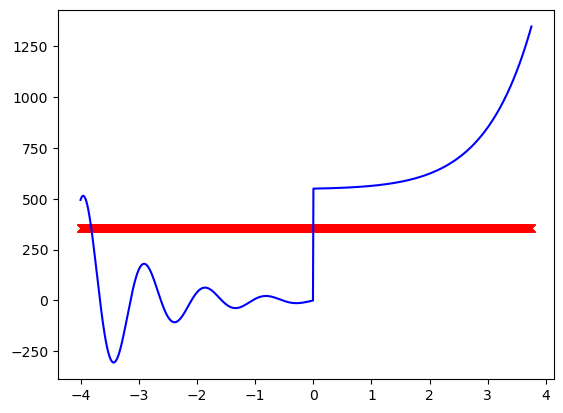

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [12]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.2753050533631516
